In [39]:
import numpy as np
from tqdm.notebook import tqdm, trange
from alive_progress import alive_bar
import time # to be used in loop iterations
import caffeine
from multiprocess import Pool
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from queue import Queue
from threading import Thread
np.random.seed(1234)

# SGD Anisotropic Gaussian Neural Net

I implemented a single layer neural network and trained in on jointly Bernoulli and anisotropic Gaussian data constructed in the 2018 paper by Mei et al. entitled 'A mean field view of the landscape of two-layer neural networks' using stochastic gradient descent. I studied limiting properties of the evolution of the network parameters, treated as interacting particles and made comparisons in monitoring losses incurred by the discretised SGD algorithm and the distributional dynamics introduced in the paper.

## SGD dynamics

In [40]:
#Ground truth data distribution
def random_sample_anisotropic(d, Delta, N, s_0):
    """
    Generate random samples from an anisotropic data distribution.

    Parameters:
    d (int): The dimensionality of the data distribution.
    Delta (float): The parameter controlling the spread of data samples.
    N (int): The number of samples to generate.
    s_0 (int): The number of dimensions with increased spread (anisotropy).

    Returns:
    tuple: A tuple containing a data matrix and corresponding labels.
           The data matrix has shape (N, d), and the labels are binary.
    """
    y = np.ones(N)
    x = np.zeros((N,d))
    successes = np.random.binomial(N, 0.5)
    y[successes:] *= -1
    x[:successes, :] = np.random.multivariate_normal([0]*d, np.diag([(1+Delta)**2]*s_0 + [1]*(d-s_0)), successes)
    x[successes:, :] = np.random.multivariate_normal([0]*d, np.diag([(1-Delta)**2]*s_0 + [1]*(d-s_0)), N-successes)
    
    return x.reshape(N,d),y

In [41]:
#Relu activation function
def neural_net_relu(a,b,w,x):
    """
    Compute the output of a neural network with ReLU activation function.

    Parameters:
    a (ndarray): Shape (1, N), the output layer weights.
    b (ndarray): Shape (1, N), the bias for the output layer.
    w (ndarray): Shape (N, d), the weights for the hidden layer.
    x (ndarray): Shape (n, d), the input data.

    Returns:
    ndarray: Shape (1, n), the network's output for the given input data.
    """
    n = x.shape[0]
    return np.mean(a.T*np.maximum(w@x.T+b.T, 0), axis = 0).reshape(1,n)

def vneural_net(a, b, w, x):
    """
    Compute the output of a neural network for multiple parameter sets.

    Parameters:
    a (ndarray): Shape (M, N), the output layer weights for M parameter sets.
    b (ndarray): Shape (M, N), the bias for the output layer for M parameter sets.
    w (ndarray): Shape (M, N, d), the weights for the hidden layer for M parameter sets.
    x (ndarray): Shape (n, d), the input data.

    Returns:
    ndarray: Shape (M, n), the network's output for the given input data and M parameter sets.
    """
    N = w.shape[1]
    d = w.shape[2]
    M = w.shape[0]
    n = x.shape[0]
    
    for m in range(M):
        out = np.array([neural_net_relu(a[m,:].reshape(1,-1),b[m,:].reshape(1,-1),w[m,:,:].reshape((N,d)), x)\
                               for m in range(M)])
    
    return out.reshape(M,n)
    
def relu(a,b,w,x):
    """
    Compute the ReLU activation of a neural network.

    Parameters:
    a (ndarray): Shape (1, N), the output layer weights.
    b (ndarray): Shape (1, N), the bias for the output layer.
    w (ndarray): Shape (N, d), the weights for the hidden layer.
    x (ndarray): Shape (n, d), the input data.

    Returns:
    ndarray: Shape (N, n), the ReLU activation of the network for the given input data.
    """
    N = w.shape[0]
    n = x.shape[0]
    return (a.T*np.maximum(w@x.T+b.T, 0)).reshape(N,n)

def vrelu(a,b,w,x):
    """
    Compute the ReLU activation of a neural network for multiple parameter sets.

    Parameters:
    a (ndarray): Shape (M, N), the output layer weights for M parameter sets.
    b (ndarray): Shape (M, N), the bias for the output layer for M parameter sets.
    w (ndarray): Shape (M, N, d), the weights for the hidden layer for M parameter sets.
    x (ndarray): Shape (n, d), the input data.

    Returns:
    ndarray: Shape (M, N, n), the ReLU activation of the network for the given input data and M parameter sets.
    """

    N = w.shape[1]
    d = w.shape[2]
    n = x.shape[0]
    M = w.shape[0]
    
    for m in range(M):
        out = np.array([relu(a[m,:].reshape(1,-1),b[m,:].reshape(1,-1),w[m,:,:].reshape((N,d)), x)\
                               for m in range(M)])
    
    return out.reshape((M,N,n))

def drelu(t):
    """
    Compute the derivative of the ReLU activation function.

    Parameters:
    t (float or ndarray): Input value(s) of the ReLU function.

    Returns:
    float or ndarray: The derivative(s) of the ReLU function at the input(s).
    """
    if t>0:
        return 1
    else:
        return 0
drelu = np.vectorize(drelu)

def grad_sigma_relu(a,b,w,x):
    """
    Compute the gradients of the ReLU activation with respect to its parameters.

    Parameters:
    a (ndarray): Shape (1, N), the output layer weights.
    b (ndarray): Shape (1, N), the bias for the output layer.
    w (ndarray): Shape (N, d), the weights for the hidden layer.
    x (ndarray): Shape (n, d), the input data.

    Returns:
    tuple: A tuple containing the gradients da, db, and dw.
           - da (ndarray): Shape (N, n), gradient of the output weights.
           - db (ndarray): Shape (N, n), gradient of the output bias.
           - dw (ndarray): Shape (N, d), gradient of the hidden layer weights.
    """
    
    n = x.shape[0]
    N = w.shape[0]
    d = w.shape[1]
    
    da = relu(a,b,w,x).reshape(n,N)
    db = a*drelu(w@x.T+b.T).reshape(n,N)
    dw = ((a.T*drelu(w@x.T+b.T))*x).reshape(N,d)
    
    return da, db, dw

def vgrad_sigma_relu(a,b,w,x):
    """
    Compute the gradients of the ReLU activation for multiple parameter sets.

    Parameters:
    a (ndarray): Shape (M, N), the output layer weights for M parameter sets.
    b (ndarray): Shape (M, N), the bias for the output layer for M parameter sets.
    w (ndarray): Shape (M, N, d), the weights for the hidden layer for M parameter sets.
    x (ndarray): Shape (n, d), the input data.

    Returns:
    tuple: A tuple containing the gradients da, db, and dw for M parameter sets.
           - da (ndarray): Shape (M, N, n), gradients of the output weights.
           - db (ndarray): Shape (M, N, n), gradients of the output bias.
           - dw (ndarray): Shape (M, N, d), gradients of the hidden layer weights.
    """

    n = x.shape[0]
    N = w.shape[1]
    d = w.shape[2]
    M = w.shape[0]
        
    da = vrelu(a,b,w,x).reshape(M,N)
    
    out_b = np.array([(a[m].reshape(1,-1))*drelu(w[m].reshape(N,d)@x.T+b[m].reshape(1,-1).T).reshape(1,N)\
                               for m in range(M)])    
    db = out_b.reshape(M,N)
    
    out_w = np.array([(a[m].reshape(1,-1).T*drelu(w[m].reshape(N,d)@x.T+b[m].reshape(1,-1).T))*x\
                               for m in range(M)])
    
    dw = out_w.reshape(M,N,d)
    
    return da, db, dw

In [42]:
def stochastic_gradient_descent(d, s_0, Delta, N, epsilon = 1e-5, num_epochs = 1000):
    """
    Train a neural network with ReLU activation using stochastic gradient descent.

    Parameters:
    d (int): Dimensionality of the data.
    s_0 (int): Number of dimensions with larger variance (anisotropy).
    Delta (float): Anisotropy factor.
    N (int): Number of neurons in the hidden layer.
    epsilon (float): Learning rate.
    num_epochs (int): Number of training epochs.

    Returns:
    ndarray: Trained weights of the neural network.
    ndarray: Mean squared errors (MSE) at each epoch.
    list: Mean values of output layer weights 'a' at each epoch.
    list: Mean values of output layer biases 'b' at each epoch.
    list: Mean Euclidean norms of the first 's_0' dimensions of weights at each epoch.
    """
    
    weights = np.random.multivariate_normal([0]*d, np.diag([(0.8)**2/d]*d), N).reshape(N, d)
    a = np.ones(N).reshape(1,N)
    b = np.ones(N).reshape(1,N)
    indices = [1,2,5,7,10]+[int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 20))]
    risk = []
    mean_a = []
    mean_b = []
    mean_r1 = []
    
    for epoch in trange(1, num_epochs+1): 
        # Update the weights
        x,y = random_sample_anisotropic(d,Delta,1,s_0)
        x = x.reshape(1,d)
        
        da, db, dw = grad_sigma_relu(a,b,weights,x)
        
        f = neural_net_relu(a, b, weights, x)
        
        weights += 2*epsilon*(epoch*epsilon)**(-0.25)*(y-f)*dw
        a += 2*epsilon*(epoch*epsilon)**(-0.25)*(y-f)*da
        b += 2*epsilon*(epoch*epsilon)**(-0.25)*(y-f)*db
        
        if epoch in indices:
        #population risk
            M = int(1e3)
            x_sample, y_sample = random_sample_anisotropic(d, Delta, M, s_0)
            mse = np.mean((y_sample-neural_net_relu(a, b, weights, x_sample))**2)
            risk.append(mse)
            avg_a = np.mean(a)
            avg_b = np.mean(b)
            avg_r1 = np.mean(np.linalg.norm(weights[:,:s_0], axis = 1))
            mean_a.append(avg_a)
            mean_b.append(avg_b)
            mean_r1.append(avg_r1)
            print('Epoch: {}, MSE: {}'.format(epoch, mse))
                
    return weights, np.array(risk), mean_a, mean_b, mean_r1

In [61]:
def nesterov_accelerated_gd(d, s_0, Delta, N, epsilon = 1e-5, r = 3, num_epochs = 1000):
    """
    Train a neural network with ReLU activation using Nesterov accelerated gradient descent.

    Parameters:
    d (int): Dimensionality of the data.
    s_0 (int): Number of dimensions with larger variance (anisotropy).
    Delta (float): Anisotropy factor.
    N (int): Number of neurons in the hidden layer.
    epsilon (float): Learning rate.
    r (int): Nesterov momentum parameter (default is 3).
    num_epochs (int): Number of training epochs.

    Returns:
    ndarray: Trained weights of the neural network.
    ndarray: Mean squared errors (MSE) at each epoch.
    list: Mean values of output layer weights 'a' at each epoch.
    list: Mean values of output layer biases 'b' at each epoch.
    list: Mean Euclidean norms of the first 's_0' dimensions of weights at each epoch.
    """
    
    weights = np.random.multivariate_normal([0]*d, np.diag([(0.8)**2/d]*d), N).reshape(N, d)
    weights_change = weights
    a = np.ones(N).reshape(1,N)
    a_change = a
    b = np.ones(N).reshape(1,N)
    b_change = b
    
    indices = [1,2,5,7,10]+[int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 20))]
    
    risk = []
    mean_a = []
    mean_b = []
    mean_r1 = []
    
    for epoch in trange(1, num_epochs+1): 
        # Update the weights
        x,y = random_sample_anisotropic(d,Delta,1,s_0)
        x = x.reshape(1,d)
        
        lr = epsilon*(epoch*epsilon)**(-0.25)
        
        da, db, dw = grad_sigma_relu(a_change,b_change,weights_change,x)
        
        f = neural_net_relu(a_change, b_change, weights_change, x)
        
        new_weights = weights_change + 2*lr*(y-f)*dw
        new_a = a_change + 2*lr*(y-f)*da
        new_b = b_change + 2*lr*(y-f)*db
        
        weights_change = new_weights + 0.9*(new_weights-weights)
        a_change = new_a + 0.9*(new_a - a)
        b_change = new_b + 0.9*(new_b - b) 
        # (epoch-1)/(epoch+r-1), r>=3

        weights = new_weights
        a = new_a
        b = new_b
        
        if epoch in indices:
        #population risk
            M = int(1e3)
            x_sample, y_sample = random_sample_anisotropic(d, Delta, M, s_0)
            mse = np.mean((y_sample-neural_net_relu(a, b, weights, x_sample))**2)
            risk.append(mse)
            avg_a = np.mean(a)
            avg_b = np.mean(b)
            avg_r1 = np.mean(np.linalg.norm(weights[:,:s_0], axis = 1))
            mean_a.append(avg_a)
            mean_b.append(avg_b)
            mean_r1.append(avg_r1)
            print('Epoch: {}, MSE: {}'.format(epoch, mse))
                
    return weights, np.array(risk), mean_a, mean_b, mean_r1

In [63]:
def Mass(d, s_0, Delta, N, epsilon = 1e-5, num_epochs = 1000):
    """
    Train a neural network with ReLU activation using the Momentum-added Stochastic Solver (MP-SGD) algorithm.

    Parameters:
    d (int): Dimensionality of the data.
    s_0 (int): Number of dimensions with larger variance (anisotropy).
    Delta (float): Anisotropy factor.
    N (int): Number of neurons in the hidden layer.
    epsilon (float): Learning rate.
    num_epochs (int): Number of training epochs.

    Returns:
    ndarray: Trained weights of the neural network.
    ndarray: Mean squared errors (MSE) at each epoch.
    list: Mean values of output layer weights 'a' at each epoch.
    list: Mean values of output layer biases 'b' at each epoch.
    list: Mean Euclidean norms of the first 's_0' dimensions of weights at each epoch.
    """

    weights = np.random.multivariate_normal([0]*d, np.diag([(0.8)**2/d]*d), N).reshape(N, d)
    weights_change = weights
    a = np.ones(N).reshape(1,N)
    a_change = a
    b = np.ones(N).reshape(1,N)
    b_change = b
    
    indices = [1,2,5,7,10]+[int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 20))]
    
    risk = []
    mean_a = []
    mean_b = []
    mean_r1 = []
    
    for epoch in trange(1, num_epochs+1): 
        # Update the weights
        x,y = random_sample_anisotropic(d,Delta,1,s_0)
        x = x.reshape(1,d)
        
        lr = epsilon*(epoch*epsilon)**(-0.25)
        
        da, db, dw = grad_sigma_relu(a_change,b_change,weights_change,x)
        
        f = neural_net_relu(a_change, b_change, weights_change, x)
        
        new_weights = weights_change + 2*lr*(y-f)*dw
        new_a = a_change + 2*lr*(y-f)*da
        new_b = b_change + 2*lr*(y-f)*db
        
        alpha = 0.05
        m = 10
        eta2 = lr/(1+alpha)/m
        
        weights_change = new_weights + 0.9*(new_weights-weights) - eta2*2*(y-f)*dw
        a_change = new_a + 0.9*(new_a - a) - eta2*2*(y-f)*da
        b_change = new_b + 0.9*(new_b - b) - eta2*2*(y-f)*db
        # (epoch-1)/(epoch+r-1), r>=3

        weights = new_weights
        a = new_a
        b = new_b
        
        if epoch in indices:
        #population risk
            M = int(1e3)
            x_sample, y_sample = random_sample_anisotropic(d, Delta, M, s_0)
            mse = np.mean((y_sample-neural_net_relu(a, b, weights, x_sample))**2)
            risk.append(mse)
            avg_a = np.mean(a)
            avg_b = np.mean(b)
            avg_r1 = np.mean(np.linalg.norm(weights[:,:s_0], axis = 1))
            mean_a.append(avg_a)
            mean_b.append(avg_b)
            mean_r1.append(avg_r1)
            print('Epoch: {}, MSE: {}'.format(epoch, mse))
                
    return weights, np.array(risk), mean_a, mean_b, mean_r1

In [64]:
def nesterov_heat_gd(d, s_0, Delta, N, epsilon = 1e-5, r = 3, num_epochs = 1000):
    """
    Train a neural network with ReLU activation using Nesterov Accelerated Gradient Descent with noise.

    Parameters:
    d (int): Dimensionality of the data.
    s_0 (int): Number of dimensions with larger variance (anisotropy).
    Delta (float): Anisotropy factor.
    N (int): Number of neurons in the hidden layer.
    epsilon (float): Learning rate.
    r (int): Parameter for Nesterov acceleration.
    num_epochs (int): Number of training epochs.

    Returns:
    ndarray: Trained weights of the neural network.
    ndarray: Mean squared errors (MSE) at each epoch.
    list: Mean values of output layer weights 'a' at each epoch.
    list: Mean values of output layer biases 'b' at each epoch.
    list: Mean Euclidean norms of the first 's_0' dimensions of weights at each epoch.
    """
    
    weights = np.random.multivariate_normal([0]*d, np.diag([(0.8)**2/d]*d), N).reshape(N, d)
    weights_change = weights
    a = np.ones(N).reshape(1,N)
    a_change = a
    b = np.ones(N).reshape(1,N)
    b_change = b
    
    indices = [1,2,5,7,10]+[int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 20))]
    
    risk = []
    mean_a = []
    mean_b = []
    mean_r1 = []
    
    for epoch in trange(1, num_epochs+1): 
        # Update the weights
        x,y = random_sample_anisotropic(d,Delta,1,s_0)
        x = x.reshape(1,d)
        
        grad_w = np.zeros((N,d))
        grad_a = np.zeros((1,N))
        grad_b = np.zeros((1,N))
        
        for i in range(10):
            heat_a = np.random.normal(0,1e-3,a_change.shape)
            heat_b = np.random.normal(0,1e-3,b_change.shape)
            heat_w = np.random.normal(0,1e-3,weights_change.shape)

            a_change_loc = a_change + heat_a
            b_change_loc = b_change + heat_b
            weights_change_loc = weights_change + heat_w

            da, db, dw = grad_sigma_relu(a_change_loc,b_change_loc,weights_change_loc,x)
        
            f = neural_net_relu(a_change_loc, b_change_loc, weights_change_loc, x)
            
            grad_w += 2*(y-f)*dw
            grad_a += 2*(y-f)*da
            grad_b += 2*(y-f)*db 
        
        new_weights = weights_change + epsilon*(epoch*epsilon)**(-0.25)*grad_w/10
        new_a = a_change + epsilon*(epoch*epsilon)**(-0.25)*grad_a/10
        new_b = b_change + epsilon*(epoch*epsilon)**(-0.25)*grad_b/10
        
        weights_change = new_weights + 0.9*(new_weights-weights) 
        a_change = new_a + 0.9*(new_a - a)
        b_change = new_b + 0.9*(new_b - b) 
        # (epoch-1)/(epoch+r-1), r>=3

        weights = new_weights
        a = new_a
        b = new_b
        
        if epoch in indices:
        #population risk
            M = int(1e3)
            x_sample, y_sample = random_sample_anisotropic(d, Delta, M, s_0)
            mse = np.mean((y_sample-neural_net_relu(a, b, weights, x_sample))**2)
            risk.append(mse)
            avg_a = np.mean(a)
            avg_b = np.mean(b)
            avg_r1 = np.mean(np.linalg.norm(weights[:,:s_0], axis = 1))
            mean_a.append(avg_a)
            mean_b.append(avg_b)
            mean_r1.append(avg_r1)
            print('Epoch: {}, MSE: {}'.format(epoch, mse))
                
    return weights, np.array(risk), mean_a, mean_b, mean_r1

In [66]:
def MF_Hom_SGLD(d, s_0, Delta, N, M = 20, λ = 10, epsilon = 1e-5, num_epochs = 1000):
    """
    Train a neural network with ReLU activation using the Discretized mean field Stochastic Gradient Langevin Dynamics with homogenization (MF-Hom-SGLD) algorithm in an anisotropic setting.

    Parameters:
    d (int): Dimensionality of the data.
    s_0 (int): Number of dimensions with larger variance (anisotropy).
    Delta (float): Anisotropy factor.
    N (int): Number of neurons in the hidden layer.
    M (int): Number of Langevin steps per epoch.
    λ (float): Regularization parameter.
    epsilon (float): Learning rate.
    num_epochs (int): Number of training epochs.

    Returns:
    ndarray: Trained weights of the neural network.
    ndarray: Mean squared errors (MSE) at each epoch.
    """
    
    indices = [1,2,5,7,10]+[int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 20))]

    #initialise params
    weights = np.random.multivariate_normal([0]*d, np.diag([(Delta)**2/d]*d), N).reshape(N, d)
    a = np.ones(N).reshape(1,N)
    b = np.ones(N).reshape(1,N)
    #initialise fast time scale variables Y as a numpy matrix with dimensions (num_epochs, N, M)
    Y_w = np.zeros((N, d))
    Y_a = np.zeros((1, N))
    Y_b = np.zeros((1, N))
    
    risk = []
    
    for epoch in trange(1, num_epochs+1): 
        
        #sample from data
        x,y = random_sample_anisotropic(d,Delta,1,s_0)
        x = x.reshape(1,d)
        
        #update Y
        Y_w_1 = np.zeros((N, d))
        Y_a_1 = np.zeros((1,N))
        Y_b_1 = np.zeros((1, N))
        Y_w_1 = Y_w
        Y_a_1 = Y_a
        Y_b_1 = Y_b
        
        cal_Y_w = np.zeros((N, d))
        cal_Y_a = np.zeros((1, N))
        cal_Y_b = np.zeros((1, N))
        
        for m in range(1,M+1):
            δ = 0.001
            γ = 0.001
            β = 10
            f = neural_net_relu(Y_a_1.reshape(1,-1), Y_b_1.reshape(1,-1),\
                                Y_w_1.reshape((N,d)) , x)
            da, db, dw = grad_sigma_relu(Y_a_1.reshape(1,-1), Y_b_1.reshape(1,-1),\
                                Y_w_1.reshape((N,d)),x)
            da *= 2*(y-f)
            db *= 2*(y-f)
            dw *= 2*(y-f)
                        
            Y_w_1 = Y_w_1 - δ*(dw-(1/γ)*(weights-Y_w_1))\
            + np.sqrt(2*(δ/β))*np.random.normal(0,1,(N,d))
            
            Y_a_1 = Y_a_1 - δ*(da-(1/γ)*(a-Y_a_1)) + np.sqrt(2*(δ/β))\
            *np.random.normal(0,1, N)
            
            Y_b_1 = Y_b_1 - δ*(db-(1/γ)*(b-Y_b_1)) + np.sqrt(2*(δ/β))\
            *np.random.normal(0,1,N)
            
            cal_Y_w += Y_w_1
            cal_Y_a += Y_a_1
            cal_Y_b += Y_b_1
            
        Y_w = Y_w_1
        Y_a = Y_a_1
        Y_b = Y_b_1
                    
        cal_Y_w /= M
        cal_Y_a /= M
        cal_Y_b /= M
        
        #update model parameters
        Δ = epsilon*(epoch*epsilon)**(-0.25)
        X = np.hstack((weights, a.T, b.T))
        mu = np.mean(X, axis = 1).reshape(1,N)
        weights = weights - 1/γ*(weights-cal_Y_w)*Δ - λ*(weights - mu.T)*Δ
        a = a - 1/γ*(a-cal_Y_a)*Δ - λ*(a - mu)*Δ
        b = b - 1/γ*(b-cal_Y_b)*Δ - λ*(b - mu)*Δ
            
        if epoch in indices:
        #population risk
            M = int(1e3)
            x_sample, y_sample = random_sample_anisotropic(d, Delta, M, s_0)
            mse = np.mean((y_sample-neural_net_relu(a, b, weights, x_sample))**2)
            risk.append(mse)
            print('Epoch: {}, MSE: {}'.format(epoch, mse))
                
    return weights, np.array(risk)

In [49]:
#simulate HomSGLD

weights_HomSGLD, risk_HomSGLD =\
MF_Hom_SGLD(32, 6, 0.4, 80, epsilon = (2e-4), num_epochs = int(1e4))

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 1, MSE: 1.9273718854965938
Epoch: 2, MSE: 1.9763587846823827
Epoch: 5, MSE: 1.7681574522616903
Epoch: 7, MSE: 1.7169187735052078
Epoch: 10, MSE: 1.6440202350255009
Epoch: 12, MSE: 1.6599292732862716
Epoch: 17, MSE: 1.5889918966123298
Epoch: 25, MSE: 1.5096938714544685
Epoch: 36, MSE: 1.3850790755236122
Epoch: 51, MSE: 1.3147479433680875
Epoch: 72, MSE: 1.1090577356466909
Epoch: 103, MSE: 1.147344554164371
Epoch: 147, MSE: 1.0470120717069626
Epoch: 209, MSE: 1.0194190035356185
Epoch: 297, MSE: 1.0115647471810936
Epoch: 422, MSE: 1.0004257069498002
Epoch: 601, MSE: 0.9977125355801306
Epoch: 854, MSE: 1.0008989116314637
Epoch: 1213, MSE: 0.998424667473116
Epoch: 1725, MSE: 0.9998211362248205
Epoch: 2451, MSE: 0.998635480581507
Epoch: 3484, MSE: 0.9977972518476065
Epoch: 4951, MSE: 0.9978979885030851
Epoch: 7036, MSE: 0.9984101572296127
Epoch: 10000, MSE: 1.0002796270070469


In [12]:
#simulate vanilla sgd

weights, risk_SGD, a_SGD, b_SGD, r1_SGD =\
stochastic_gradient_descent(32, 6, 0.4, 80, epsilon = (2e-4), num_epochs = int(1e5))

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 1, MSE: 1.9496729796104177
Epoch: 2, MSE: 2.040560843412142
Epoch: 5, MSE: 2.0845802872530528
Epoch: 7, MSE: 1.9882906548660957
Epoch: 10, MSE: 1.853397433437612
Epoch: 12, MSE: 2.043891077340202
Epoch: 20, MSE: 1.9223253604824744
Epoch: 32, MSE: 1.7828234994228291
Epoch: 51, MSE: 1.8018593453026275
Epoch: 83, MSE: 1.7378471602640713
Epoch: 133, MSE: 1.636728736691077
Epoch: 214, MSE: 1.5066837968009972
Epoch: 344, MSE: 1.3980356267202718
Epoch: 552, MSE: 1.3644687424258253
Epoch: 885, MSE: 1.1810526736407496
Epoch: 1421, MSE: 1.125255301869445
Epoch: 2279, MSE: 1.087677885559913
Epoch: 3657, MSE: 1.069041344591091
Epoch: 5867, MSE: 1.0107340089464
Epoch: 9412, MSE: 0.9892154376968497
Epoch: 15098, MSE: 0.9729107944725884
Epoch: 24222, MSE: 0.9354160347959617
Epoch: 38857, MSE: 0.8803972582047608
Epoch: 62335, MSE: 0.8240610176238455
Epoch: 100000, MSE: 0.763911545929779


In [14]:
#simulate Nesterov sgd

weights_NSGD, risk_NSGD, a_NSGD, b_NSGD, r1_NSGD =\
nesterov_accelerated_gd(32, 6, 0.4, 80, epsilon = (2e-4), num_epochs = int(1e5))

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 1, MSE: 2.14139800491572
Epoch: 2, MSE: 2.0813976636391485
Epoch: 5, MSE: 2.0546573917415833
Epoch: 7, MSE: 1.9914665435784271
Epoch: 10, MSE: 1.7162396700437303
Epoch: 12, MSE: 1.552062538043487
Epoch: 20, MSE: 1.4618134105891516
Epoch: 32, MSE: 1.3286214263604197
Epoch: 51, MSE: 1.145530291036747
Epoch: 83, MSE: 1.0662616743654423
Epoch: 133, MSE: 1.0386889746670027
Epoch: 214, MSE: 1.0218431848807081
Epoch: 344, MSE: 0.9974296354855257
Epoch: 552, MSE: 0.9974070747419793
Epoch: 885, MSE: 1.0026211273962355
Epoch: 1421, MSE: 0.9549637129807197
Epoch: 2279, MSE: 0.9385266687223558
Epoch: 3657, MSE: 0.8646059653702873
Epoch: 5867, MSE: 0.7758491488844431
Epoch: 9412, MSE: 0.7299518960720717
Epoch: 15098, MSE: 0.7021990111232803
Epoch: 24222, MSE: 0.7090785616544275
Epoch: 38857, MSE: 0.7204109556408518
Epoch: 62335, MSE: 0.692638429923385
Epoch: 100000, MSE: 0.7094966274141818


In [30]:
#simulate mass sgd

weights, risk_Mass, a_Mass, b_Mass, r1_Mass =\
Mass(32, 6, 0.4, 80, epsilon = (2e-4), num_epochs = int(1e5))

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 1, MSE: 2.112166162690278
Epoch: 2, MSE: 1.9108911280826428
Epoch: 5, MSE: 1.880942212143101
Epoch: 7, MSE: 1.9366635609001355
Epoch: 10, MSE: 1.855492555972632
Epoch: 12, MSE: 1.7504770892265735
Epoch: 20, MSE: 1.593728859921817
Epoch: 32, MSE: 1.4782544461926486
Epoch: 51, MSE: 1.1816197746709236
Epoch: 83, MSE: 1.1638713770787628
Epoch: 133, MSE: 1.1358563112285516
Epoch: 214, MSE: 1.0190197138984853
Epoch: 344, MSE: 1.0510953039648103
Epoch: 552, MSE: 0.9981329815819516
Epoch: 885, MSE: 0.9662152721770894
Epoch: 1421, MSE: 0.9732144975705717
Epoch: 2279, MSE: 0.9539373574155984
Epoch: 3657, MSE: 0.8865461263439527
Epoch: 5867, MSE: 0.8150384845253116
Epoch: 9412, MSE: 0.7791247591475232
Epoch: 15098, MSE: 0.6869124433760726
Epoch: 24222, MSE: 0.7029591318538887
Epoch: 38857, MSE: 0.7168452291975433
Epoch: 62335, MSE: 0.7046497585039383
Epoch: 100000, MSE: 0.7119235741889026


Text(0.5, 1.0, 'SGD risk for Anisotropic Gaussian')

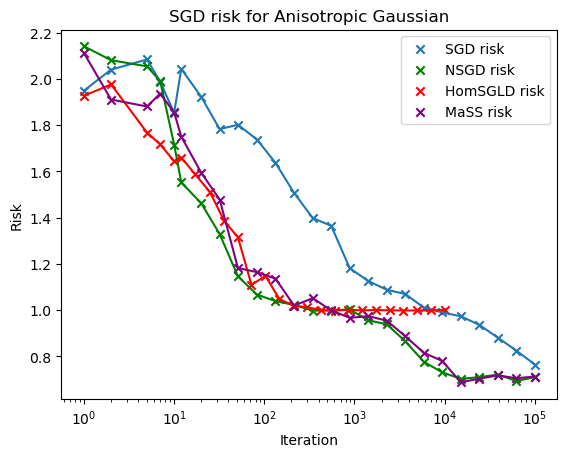

In [51]:
#plot SGD and Nesterov SGD losses
indices = [1,2,5,7,10]+[int(a) for a in 10**(np.linspace(1.1, np.log10(1e5), 20))]
plt.plot(indices, risk_SGD)
plt.scatter(indices, risk_SGD, marker = 'x', label = 'SGD risk')
plt.plot(indices, risk_NSGD, c = 'g')
plt.scatter(indices, risk_NSGD, marker = 'x', label = 'NSGD risk', c = 'g')
indices_Hom = [1,2,5,7,10]+[int(a) for a in 10**(np.linspace(1.1, np.log10(1e4), 20))]
plt.plot(indices_Hom, risk_HomSGLD, c = 'r')
plt.scatter(indices_Hom, risk_HomSGLD, marker = 'x', c = 'r', label = 'HomSGLD risk')
plt.plot(indices, risk_Mass, c = 'purple')
plt.scatter(indices, risk_Mass, marker = 'x', c = 'purple', label = 'MaSS risk')
plt.xscale('log')
plt.xlabel('Iteration')
plt.ylabel('Risk')
plt.legend()
plt.title('SGD risk for Anisotropic Gaussian')

## PDE simulation

In [67]:
from scipy.stats import norm

def q_plus(r1, r2, b, Delta):
    root_plus = np.sqrt((1+Delta)**2*r1**2+r2**2)
    return b*norm.cdf(b/(root_plus))+root_plus*norm.pdf(b/root_plus)

def q_minus(r1, r2, b, Delta):
    root_minus = np.sqrt((1-Delta)**2*r1**2+r2**2)
    return b*norm.cdf(b/(root_minus))+root_minus*norm.pdf(b/root_minus)

def dq_plus(r1, r2, b, Delta):
    from scipy.stats import norm
    d_normal = lambda x: -x*norm.pdf(x)
    
    root_plus = np.sqrt((1+Delta)**2*r1**2+r2**2)
    
    droot_plus_1 = (1+Delta)**2*r1/root_plus
    droot_plus_2 = r2/root_plus
    
    db = norm.cdf(b/(root_plus)) + b/(root_plus)*norm.pdf(b/root_plus) + d_normal(b/root_plus)
    dr1 = -droot_plus_1/(root_plus**2)*b**2*norm.pdf(b/(root_plus))\
                    +droot_plus_1*norm.pdf(b/root_plus)-b*droot_plus_1/(root_plus**2)*d_normal(b/root_plus)
    dr2 = -droot_plus_2/(root_plus**2)*b**2*norm.pdf(b/(root_plus))\
                    +droot_plus_2*norm.pdf(b/root_plus) -b*droot_plus_2/(root_plus**2)*d_normal(b/root_plus)
    return db, dr1, dr2

def dq_minus(r1, r2, b, Delta):
    from scipy.stats import norm
    d_normal = lambda x: -x*norm.pdf(x)
    
    root_minus = np.sqrt((1-Delta)**2*r1**2+r2**2)
    
    droot_minus_1 = (1-Delta)**2*r1/root_minus
    droot_minus_2 = r2/root_minus
    
    db = norm.cdf(b/(root_minus)) + b/(root_minus)*norm.pdf(b/root_minus) + d_normal(b/root_minus)
    dr1 = -droot_minus_1/(root_minus**2)*b**2*norm.pdf(b/(root_minus))\
                    +droot_minus_1*norm.pdf(b/root_minus) - b*droot_minus_1/(root_minus**2)*d_normal(b/root_minus)
    dr2 = -droot_minus_2/(root_minus**2)*b**2*norm.pdf(b/(root_minus))\
                    +droot_minus_2*norm.pdf(b/root_minus) -b*droot_minus_2/(root_minus**2)*d_normal(b/root_minus)
    return db, dr1, dr2

def R_inf(r, Delta):
    #shape of r is (J, 4)
    a = r[:,0]
    b = r[:,1]
    r1 = r[:,2]
    r2 = r[:,3]
    
    plus = a*q_plus(r1, r2, b, Delta)
    minus = a*q_minus(r1, r2, b, Delta)

    mean_q_plus = np.mean(plus)
    mean_q_minus = np.mean(minus)
    return 0.5 * (1 - mean_q_plus) ** 2 + 0.5 * (1 + mean_q_minus) ** 2

def grad_R_inf(r, Delta):
    
    #shape of r: (J, 4)
    #shape of grad: (J, 4)
    
    J = len(r)
    a = r[:,0]
    b = r[:,1]
    r1 = r[:,2]
    r2 = r[:,3]
    
    Q_plus = q_plus(r1, r2, b, Delta)
    Q_minus = q_minus(r1, r2, b, Delta)
    
    plus = a*Q_plus
    minus = a*Q_minus

    mean_q_plus = np.mean(plus)
    mean_q_minus = np.mean(minus)
    
    db_plus, dr1_plus, dr2_plus = dq_plus(r1, r2, b, Delta)
    db_minus, dr1_minus, dr2_minus = dq_minus(r1, r2, b, Delta)
    
    grad = np.zeros((J,4))
    #da
    grad[:,0] = -1/J*Q_plus*(1-mean_q_plus) + 1/J*Q_minus*(1+mean_q_minus)
    #db
    grad[:,1] = -1/J*db_plus*(1-mean_q_plus) + 1/J*db_minus*(1+mean_q_minus)
    #dr1
    grad[:,2] = -1/J*dr1_plus*(1-mean_q_plus) + 1/J*dr1_minus*(1+mean_q_minus)
    #dr2
    grad[:,3] = -1/J*dr2_plus*(1-mean_q_plus) + 1/J*dr2_minus*(1+mean_q_minus)
    
    return grad

In [76]:
#simulate pde
def pde_sim(d = 320, J = 1, epsilon = 2e-4, Delta = 0.2, s_0 = 60):
    """
    Simulate a partial differential equation (PDE) risk using Langevin dynamics.

    Parameters:
    d (int): Dimensionality of the data.
    J (int): Number of samples.
    epsilon (float): Time step.
    Delta (float): Anisotropy factor.
    s_0 (int): Number of dimensions with larger variance (anisotropy).

    Returns:
    ndarray: Risk values at different time steps.
    ndarray: Mean values of parameter 'a' at each time step.
    ndarray: Mean values of parameter 'b' at each time step.
    ndarray: Mean values of parameter 'r1' at each time step.
    """
    Interval = 10**np.linspace(-5,np.log10(epsilon*1e7), int(1e5))
    risk = []
    mean_a = []
    mean_b = []
    mean_r1 = []
    separations = [Interval[k+1]-Interval[k] for k in range(len(Interval)-1)]
    #initialise params
    Z1 = np.random.multivariate_normal([0]*s_0, np.diag([(0.8)**2/d]*s_0), J).reshape(J, s_0)
    Z2 = np.random.multivariate_normal([0]*(d-s_0), np.diag([(0.8)**2/d]*(d-s_0)), J).reshape(J, d-s_0)
    a = np.ones(J).reshape(J,1)
    b = np.ones(J).reshape(J,1)
    r1 = np.linalg.norm(Z1, axis = 1).reshape(J,1)
    r2 = np.linalg.norm(Z2, axis = 1).reshape(J,1)
    r = np.hstack((a,b,r1,r2)).reshape(J,4)

    for k in trange(len(separations)):
        dt = separations[k]
        grad = grad_R_inf(r, Delta)
        r = r - (Interval[k])**(-0.25)* J * grad * dt
        error = R_inf(r, Delta)
        a = r[:,0]
        b = r[:,1]
        r1 = r[:,2]
        mean_a.append(np.mean(a))
        mean_b.append(np.mean(b))
        mean_r1.append(np.mean(r1))
        risk.append(error)
        print(np.mean(a))
    return risk, mean_a, mean_b, mean_r1

In [68]:
weights, risk_SGD, a_SGD, b_SGD, r1_SGD = stochastic_gradient_descent(32, 6, 0.4, 80, epsilon = (2e-4), num_epochs = int(1e5))

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 1, MSE: 2.083191963694187
Epoch: 2, MSE: 2.084665294794288
Epoch: 5, MSE: 2.047985659613871
Epoch: 7, MSE: 1.9773114412944208
Epoch: 10, MSE: 1.8713947052616353
Epoch: 12, MSE: 1.9037774414526043
Epoch: 20, MSE: 2.024509585916885
Epoch: 32, MSE: 1.8659629157803683
Epoch: 51, MSE: 1.8027597792268433
Epoch: 83, MSE: 1.7172257332247405
Epoch: 133, MSE: 1.6737781055936336
Epoch: 214, MSE: 1.5065816660956608
Epoch: 344, MSE: 1.3686374930497267
Epoch: 552, MSE: 1.3785329545577039
Epoch: 885, MSE: 1.2403359680403916
Epoch: 1421, MSE: 1.1686583559415542
Epoch: 2279, MSE: 1.0696485684604276
Epoch: 3657, MSE: 1.0273932471270233
Epoch: 5867, MSE: 1.0031217115761455
Epoch: 9412, MSE: 0.9956756390430749
Epoch: 15098, MSE: 0.9740969203179418
Epoch: 24222, MSE: 0.9457792169191755
Epoch: 38857, MSE: 0.9067388515319867
Epoch: 62335, MSE: 0.855861328953962
Epoch: 100000, MSE: 0.761972386526098


In [77]:
pde_risk, mean_a_pde, mean_b_pde, mean_r1_pde = pde_sim(d = 320, J = 400, epsilon = 2e-4, Delta = 0.4, s_0 = 60)

  0%|          | 0/99999 [00:00<?, ?it/s]

0.9999999267825117
0.9999998535545409
0.9999997803160855
0.9999997070671447
0.9999996338077162
0.9999995605377989
0.9999994872573916
0.9999994139664925
0.9999993406651001
0.9999992673532127
0.9999991940308293
0.9999991206979479
0.9999990473545672
0.9999989740006859
0.999998900636302
0.9999988272614146
0.9999987538760218
0.9999986804801223
0.9999986070737146
0.9999985336567968
0.9999984602293679
0.9999983867914262
0.9999983133429702
0.9999982398839982
0.9999981664145089
0.9999980929345008
0.9999980194439726
0.9999979459429224
0.9999978724313487
0.9999977989092506
0.9999977253766258
0.9999976518334733
0.9999975782797915
0.9999975047155789
0.9999974311408337
0.9999973575555547
0.9999972839597404
0.9999972103533892
0.9999971367364996
0.9999970631090701
0.9999969894710992
0.9999969158225853
0.999996842163527
0.999996768493923
0.9999966948137714
0.999996621123071
0.99999654742182
0.9999964737100171
0.9999963999876607
0.9999963262547493
0.9999962525112815
0.9999961787572557
0.9999961049926703

0.9999640928944606
0.9999640145362766
0.9999639361668747
0.9999638577862539
0.9999637793944117
0.9999637009913471
0.9999636225770581
0.9999635441515438
0.9999634657148019
0.9999633872668309
0.9999633088076294
0.9999632303371959
0.9999631518555284
0.9999630733626258
0.9999629948584859
0.9999629163431075
0.999962837816489
0.9999627592786285
0.9999626807295248
0.9999626021691758
0.9999625235975802
0.9999624450147365
0.9999623664206428
0.9999622878152978
0.9999622091986997
0.9999621305708469
0.9999620519317378
0.9999619732813707
0.999961894619744
0.9999618159468565
0.9999617372627061
0.9999616585672914
0.9999615798606107
0.9999615011426626
0.9999614224134451
0.999961343672957
0.9999612649211963
0.9999611861581619
0.9999611073838517
0.9999610285982644
0.999960949801398
0.9999608709932514
0.9999607921738226
0.9999607133431101
0.9999606345011125
0.9999605556478278
0.9999604767832547
0.9999603979073913
0.9999603190202364
0.999960240121788
0.9999601612120448
0.9999600822910049
0.999960003358666

0.9999243216412972
0.9999242375897665
0.9999241535262045
0.9999240694506087
0.9999239853629782
0.9999239012633112
0.9999238171516056
0.99992373302786
0.9999236488920724
0.999923564744241
0.9999234805843648
0.9999233964124411
0.999923312228469
0.9999232280324462
0.9999231438243714
0.9999230596042424
0.9999229753720581
0.9999228911278163
0.9999228068715155
0.9999227226031536
0.9999226383227294
0.9999225540302409
0.9999224697256863
0.9999223854090641
0.9999223010803726
0.9999222167396098
0.9999221323867742
0.999922048021864
0.9999219636448774
0.9999218792558128
0.9999217948546684
0.9999217104414424
0.9999216260161333
0.9999215415787392
0.9999214571292583
0.9999213726676891
0.9999212881940298
0.9999212037082786
0.9999211192104337
0.9999210347004935
0.9999209501784563
0.9999208656443203
0.9999207810980838
0.9999206965397451
0.9999206119693024
0.9999205273867537
0.9999204427920979
0.9999203581853329
0.9999202735664567
0.9999201889354683
0.9999201042923653
0.9999200196371464
0.999919934969809

0.9998814805225004
0.9998813903388302
0.999881300142252
0.999881209932764
0.9998811197103644
0.9998810294750515
0.9998809392268234
0.9998808489656781
0.999880758691614
0.999880668404629
0.9998805781047213
0.9998804877918892
0.9998803974661308
0.9998803071274441
0.9998802167758275
0.9998801264112791
0.9998800360337968
0.9998799456433791
0.9998798552400239
0.9998797648237294
0.9998796743944939
0.9998795839523151
0.9998794934971919
0.9998794030291219
0.9998793125481034
0.9998792220541347
0.9998791315472135
0.9998790410273384
0.9998789504945071
0.9998788599487185
0.9998787693899699
0.9998786788182601
0.9998785882335869
0.9998784976359485
0.999878407025343
0.9998783164017686
0.9998782257652237
0.9998781351157061
0.999878044453214
0.9998779537777458
0.9998778630892993
0.9998777723878726
0.9998776816734645
0.9998775909460724
0.9998775002056948
0.9998774094523296
0.9998773186859754
0.9998772279066298
0.9998771371142915
0.9998770463089582
0.9998769554906282
0.9998768646592996
0.9998767738149706

0.9998356107850407
0.9998355140364891
0.9998354172740912
0.9998353204978457
0.9998352237077506
0.9998351269038036
0.999835030086003
0.9998349332543465
0.9998348364088323
0.9998347395494585
0.9998346426762231
0.999834545789124
0.9998344488881591
0.9998343519733268
0.999834255044625
0.9998341581020515
0.9998340611456044
0.999833964175282
0.9998338671910819
0.9998337701930023
0.9998336731810413
0.999833576155197
0.999833479115467
0.9998333820618497
0.999833284994343
0.9998331879129448
0.9998330908176533
0.9998329937084666
0.9998328965853821
0.9998327994483986
0.9998327022975139
0.9998326051327256
0.9998325079540322
0.9998324107614316
0.9998323135549215
0.9998322163345003
0.9998321191001658
0.9998320218519163
0.9998319245897491
0.9998318273136633
0.9998317300236559
0.9998316327197253
0.9998315354018698
0.999831438070087
0.999831340724375
0.999831243364732
0.9998311459911559
0.9998310486036445
0.999830951202196
0.9998308537868084
0.9998307563574798
0.9998306589142082
0.9998305614569916
0.99

0.9997902320189805
0.9997901287765935
0.9997900255194332
0.9997899222474973
0.9997898189607836
0.9997897156592904
0.9997896123430153
0.9997895090119562
0.999789405666111
0.9997893023054778
0.9997891989300542
0.9997890955398381
0.9997889921348275
0.9997888887150204
0.9997887852804145
0.9997886818310076
0.9997885783667979
0.9997884748877831
0.9997883713939609
0.9997882678853296
0.9997881643618868
0.9997880608236304
0.9997879572705586
0.9997878537026686
0.9997877501199589
0.9997876465224274
0.9997875429100713
0.9997874392828894
0.9997873356408788
0.999787231984038
0.9997871283123644
0.9997870246258561
0.9997869209245112
0.999786817208327
0.999786713477302
0.9997866097314335
0.9997865059707199
0.9997864021951588
0.9997862984047482
0.9997861945994859
0.99978609077937
0.9997859869443978
0.9997858830945678
0.9997857792298777
0.9997856753503251
0.9997855714559081
0.9997854675466249
0.9997853636224727
0.9997852596834497
0.9997851557295538
0.9997850517607831
0.9997849477771352
0.9997848437786081

0.999743787978432
0.9997436780905676
0.999743568186981
0.9997434582676695
0.999743348332631
0.9997432383818636
0.9997431284153646
0.9997430184331322
0.9997429084351637
0.9997427984214571
0.9997426883920102
0.9997425783468205
0.9997424682858859
0.9997423582092043
0.9997422481167733
0.9997421380085908
0.9997420278846542
0.9997419177449615
0.9997418075895105
0.9997416974182989
0.9997415872313243
0.9997414770285846
0.9997413668100776
0.999741256575801
0.9997411463257524
0.9997410360599298
0.9997409257783306
0.999740815480953
0.9997407051677943
0.9997405948388527
0.9997404844941254
0.9997403741336106
0.9997402637573061
0.9997401533652092
0.9997400429573179
0.9997399325336299
0.999739822094143
0.9997397116388549
0.9997396011677635
0.9997394906808662
0.9997393801781612
0.9997392696596458
0.999739159125318
0.9997390485751754
0.9997389380092159
0.9997388274274371
0.9997387168298368
0.9997386062164128
0.9997384955871627
0.9997383849420846
0.9997382742811755
0.9997381636044338
0.9997380529118572


0.9996903685873676
0.9996902510569557
0.9996901335097306
0.9996900159456894
0.9996898983648299
0.9996897807671496
0.9996896631526462
0.9996895455213174
0.9996894278731605
0.9996893102081732
0.9996891925263534
0.9996890748276982
0.9996889571122055
0.999688839379873
0.9996887216306982
0.9996886038646784
0.9996884860818116
0.9996883682820952
0.9996882504655268
0.9996881326321039
0.9996880147818246
0.9996878969146857
0.9996877790306854
0.999687661129821
0.9996875432120902
0.9996874252774908
0.9996873073260198
0.9996871893576754
0.9996870713724548
0.999686953370356
0.9996868353513761
0.9996867173155131
0.9996865992627645
0.9996864811931274
0.9996863631066003
0.9996862450031798
0.9996861268828644
0.9996860087456512
0.9996858905915376
0.9996857724205216
0.9996856542326005
0.9996855360277721
0.999685417806034
0.9996852995673836
0.9996851813118185
0.9996850630393364
0.999684944749935
0.9996848264436116
0.9996847081203639
0.9996845897801895
0.9996844714230858
0.9996843530490509
0.999684234658081

0.9996299600956797
0.9996298339241043
0.999629707734482
0.9996295815268104
0.9996294553010864
0.9996293290573083
0.9996292027954727
0.9996290765155775
0.9996289502176201
0.9996288239015976
0.9996286975675079
0.999628571215348
0.9996284448451155
0.9996283184568078
0.9996281920504225
0.9996280656259566
0.999627939183408
0.9996278127227737
0.9996276862440513
0.9996275597472385
0.9996274332323322
0.9996273066993301
0.9996271801482297
0.999627053579028
0.999626926991723
0.9996268003863116
0.9996266737627917
0.9996265471211604
0.9996264204614153
0.9996262937835535
0.9996261670875727
0.99962604037347
0.9996259136412433
0.9996257868908895
0.9996256601224066
0.9996255333357914
0.9996254065310418
0.999625279708155
0.9996251528671283
0.9996250260079591
0.9996248991306451
0.9996247722351836
0.9996246453215718
0.9996245183898074
0.9996243914398878
0.9996242644718101
0.999624137485572
0.9996240104811706
0.9996238834586034
0.9996237564178684
0.9996236293589624
0.9996235022818829
0.999623375186627
0.9

0.9995695694661338
0.9995694346573211
0.9995692998292293
0.9995691649818553
0.9995690301151967
0.9995688952292506
0.9995687603240142
0.9995686253994852
0.99956849045566
0.9995683554925366
0.9995682205101122
0.9995680855083836
0.9995679504873481
0.9995678154470033
0.9995676803873463
0.9995675453083744
0.9995674102100846
0.9995672750924743
0.9995671399555408
0.9995670047992813
0.999566869623693
0.9995667344287733
0.9995665992145192
0.9995664639809282
0.9995663287279973
0.9995661934557236
0.999566058164105
0.9995659228531382
0.9995657875228204
0.9995656521731492
0.9995655168041214
0.9995653814157347
0.999565246007986
0.9995651105808727
0.999564975134392
0.9995648396685413
0.9995647041833174
0.9995645686787179
0.9995644331547399
0.9995642976113808
0.9995641620486375
0.9995640264665078
0.9995638908649883
0.9995637552440766
0.9995636196037698
0.9995634839440654
0.9995633482649601
0.9995632125664514
0.999563076848537
0.9995629411112134
0.9995628053544782
0.9995626695783286
0.9995625337827617


0.9995008596589049
0.9995007150246904
0.999500570369795
0.9995004256942164
0.9995002809979511
0.9995001362809964
0.9994999915433492
0.9994998467850067
0.9994997020059658
0.9994995572062237
0.9994994123857773
0.9994992675446239
0.9994991226827604
0.9994989778001836
0.999498832896891
0.9994986879728793
0.9994985430281457
0.9994983980626871
0.9994982530765009
0.9994981080695837
0.9994979630419328
0.9994978179935451
0.9994976729244179
0.9994975278345479
0.9994973827239323
0.9994972375925684
0.9994970924404529
0.999496947267583
0.9994968020739554
0.9994966568595676
0.9994965116244162
0.999496366368499
0.9994962210918122
0.9994960757943532
0.999495930476119
0.9994957851371069
0.9994956397773135
0.9994954943967359
0.9994953489953713
0.9994952035732166
0.9994950581302693
0.9994949126665257
0.9994947671819834
0.999494621676639
0.9994944761504901
0.9994943306035331
0.9994941850357657
0.9994940394471841
0.9994938938377862
0.9994937482075684
0.9994936025565281
0.999493456884662
0.9994933111919674


0.9994331769967527
0.999433022685752
0.9994328683526907
0.9994327139975661
0.9994325596203748
0.9994324052211138
0.99943225079978
0.9994320963563701
0.999431941890881
0.9994317874033095
0.9994316328936526
0.9994314783619069
0.9994313238080695
0.9994311692321373
0.9994310146341069
0.9994308600139752
0.999430705371739
0.9994305507073953
0.9994303960209412
0.9994302413123731
0.999430086581688
0.9994299318288824
0.9994297770539541
0.9994296222568988
0.9994294674377141
0.9994293125963968
0.9994291577329435
0.999429002847351
0.9994288479396164
0.9994286930097362
0.9994285380577078
0.9994283830835274
0.9994282280871922
0.9994280730686992
0.9994279180280446
0.9994277629652261
0.9994276078802399
0.9994274527730831
0.9994272976437525
0.9994271424922448
0.999426987318557
0.9994268321226859
0.9994266769046284
0.9994265216643812
0.9994263664019414
0.9994262111173055
0.9994260558104705
0.999425900481433
0.9994257451301902
0.999425589756739
0.999425434361076
0.9994252789431977
0.9994251235031015
0.99

0.9993588243703982
0.9993586594309726
0.9993584944679715
0.999358329481392
0.9993581644712307
0.999357999437484
0.9993578343801491
0.999357669299222
0.9993575041946996
0.9993573390665784
0.9993571739148552
0.9993570087395267
0.9993568435405895
0.99935667831804
0.999356513071875
0.9993563478020911
0.9993561825086852
0.9993560171916536
0.9993558518509932
0.9993556864867
0.9993555210987715
0.9993553556872038
0.9993551902519937
0.9993550247931379
0.9993548593106328
0.9993546938044752
0.9993545282746615
0.9993543627211888
0.9993541971440533
0.9993540315432519
0.9993538659187812
0.9993537002706373
0.9993535345988175
0.9993533689033183
0.999353203184136
0.9993530374412676
0.9993528716747094
0.9993527058844583
0.9993525400705107
0.9993523742328637
0.9993522083715132
0.9993520424864561
0.9993518765776893
0.9993517106452091
0.9993515446890125
0.9993513787090955
0.9993512127054553
0.9993510466780883
0.9993508806269911
0.9993507145521605
0.9993505484535927
0.9993503823312847
0.9993502161852328
0.9

0.9992789984979512
0.9992788221500346
0.9992786457769172
0.9992784693785959
0.9992782929550669
0.9992781165063266
0.9992779400323716
0.9992777635331979
0.9992775870088022
0.9992774104591808
0.9992772338843303
0.999277057284247
0.9992768806589271
0.9992767040083674
0.9992765273325641
0.9992763506315134
0.9992761739052121
0.9992759971536563
0.9992758203768426
0.9992756435747672
0.9992754667474266
0.9992752898948172
0.9992751130169356
0.9992749361137778
0.9992747591853405
0.99927458223162
0.9992744052526126
0.9992742282483149
0.9992740512187234
0.9992738741638341
0.9992736970836436
0.9992735199781484
0.9992733428473447
0.999273165691229
0.9992729885097976
0.9992728113030472
0.999272634070974
0.999272456813574
0.9992722795308443
0.9992721022227807
0.99927192488938
0.9992717475306384
0.9992715701465523
0.9992713927371182
0.9992712153023322
0.9992710378421912
0.9992708603566911
0.9992706828458284
0.9992705053095996
0.9992703277480013
0.9992701501610293
0.9992699725486804
0.9992697949109509
0

0.9991996710357607
0.999199483352958
0.9991992956433403
0.9991991079069042
0.999198920143646
0.9991987323535614
0.999198544536647
0.9991983566928986
0.9991981688223128
0.9991979809248854
0.9991977930006131
0.9991976050494915
0.999197417071517
0.999197229066686
0.9991970410349942
0.9991968529764381
0.9991966648910139
0.9991964767787178
0.9991962886395456
0.9991961004734938
0.9991959122805588
0.9991957240607361
0.9991955358140225
0.999195347540414
0.9991951592399065
0.9991949709124964
0.9991947825581801
0.9991945941769532
0.9991944057688121
0.9991942173337535
0.9991940288717727
0.9991938403828664
0.9991936518670306
0.9991934633242616
0.9991932747545555
0.9991930861579086
0.9991928975343165
0.9991927088837761
0.999192520206283
0.9991923315018338
0.9991921427704245
0.999191954012051
0.9991917652267099
0.9991915764143969
0.9991913875751086
0.9991911987088409
0.99919100981559
0.999190820895352
0.9991906319481234
0.9991904429739
0.9991902539726779
0.9991900649444535
0.9991898758892229
0.99918

0.9991114452996902
0.99911124501333
0.9991110446983612
0.9991108443547795
0.9991106439825808
0.9991104435817612
0.9991102431523166
0.9991100426942429
0.999109842207536
0.9991096416921919
0.9991094411482063
0.9991092405755754
0.999109039974295
0.9991088393443611
0.9991086386857697
0.9991084379985165
0.9991082372825975
0.9991080365380084
0.9991078357647456
0.9991076349628049
0.9991074341321817
0.9991072332728725
0.999107032384873
0.9991068314681795
0.999106630522787
0.9991064295486922
0.9991062285458909
0.9991060275143788
0.999105826454152
0.9991056253652063
0.9991054242475377
0.9991052231011419
0.9991050219260151
0.999104820722153
0.9991046194895516
0.9991044182282068
0.9991042169381146
0.9991040156192708
0.9991038142716714
0.9991036128953121
0.999103411490189
0.9991032100562979
0.9991030085936348
0.9991028071021957
0.9991026055819762
0.9991024040329723
0.9991022024551802
0.9991020008485952
0.999101799213214
0.9991015975490319
0.9991013958560453
0.9991011941342494
0.9991009923836407
0.9

0.9990170818959734
0.9990168681324935
0.9990166543384876
0.999016440513951
0.9990162266588795
0.9990160127732688
0.9990157988571144
0.9990155849104121
0.9990153709331576
0.9990151569253465
0.9990149428869742
0.9990147288180369
0.9990145147185298
0.9990143005884486
0.9990140864277893
0.9990138722365469
0.9990136580147179
0.9990134437622972
0.9990132294792808
0.9990130151656643
0.9990128008214433
0.9990125864466134
0.9990123720411707
0.9990121576051101
0.9990119431384278
0.9990117286411191
0.99901151411318
0.9990112995546059
0.9990110849653924
0.9990108703455353
0.9990106556950302
0.9990104410138727
0.9990102263020585
0.9990100115595831
0.9990097967864422
0.9990095819826316
0.9990093671481469
0.9990091522829835
0.999008937387137
0.9990087224606036
0.9990085075033783
0.999008292515457
0.9990080774968354
0.9990078624475092
0.9990076473674736
0.9990074322567248
0.9990072171152581
0.999007001943069
0.9990067867401535
0.9990065715065071
0.9990063562421251
0.9990061409470036
0.999005925621138


0.9989113429977425
0.9989111141364561
0.9989108852424964
0.9989106563158591
0.9989104273565391
0.9989101983645321
0.9989099693398336
0.9989097402824385
0.9989095111923425
0.9989092820695409
0.9989090529140289
0.9989088237258019
0.9989085945048553
0.9989083652511843
0.9989081359647847
0.9989079066456513
0.9989076772937797
0.9989074479091653
0.9989072184918032
0.9989069890416892
0.9989067595588181
0.9989065300431857
0.998906300494787
0.9989060709136175
0.9989058412996726
0.9989056116529476
0.9989053819734376
0.9989051522611382
0.9989049225160449
0.9989046927381527
0.998904462927457
0.9989042330839533
0.9989040032076367
0.9989037732985028
0.9989035433565467
0.998903313381764
0.9989030833741498
0.9989028533336992
0.9989026232604081
0.9989023931542718
0.9989021630152851
0.9989019328434438
0.9989017026387428
0.9989014724011779
0.9989012421307442
0.998901011827437
0.9989007814912515
0.9989005511221835
0.9989003207202279
0.9989000902853801
0.9988998598176354
0.9988996293169895
0.99889939878343

0.9988066907532313
0.9988064469534339
0.9988062031188405
0.9988059592494457
0.9988057153452451
0.9988054714062331
0.9988052274324053
0.9988049834237563
0.9988047393802816
0.9988044953019761
0.9988042511888348
0.9988040070408527
0.998803762858025
0.9988035186403466
0.9988032743878125
0.998803030100418
0.9988027857781581
0.9988025414210273
0.9988022970290216
0.9988020526021352
0.9988018081403635
0.9988015636437017
0.9988013191121445
0.9988010745456871
0.9988008299443248
0.9988005853080523
0.9988003406368645
0.9988000959307568
0.9987998511897243
0.9987996064137615
0.9987993616028642
0.9987991167570267
0.9987988718762444
0.9987986269605124
0.9987983820098256
0.998798137024179
0.9987978920035677
0.9987976469479868
0.9987974018574312
0.998797156731896
0.9987969115713762
0.9987966663758668
0.9987964211453629
0.9987961758798596
0.9987959305793518
0.9987956852438346
0.9987954398733028
0.9987951944677519
0.9987949490271762
0.9987947035515716
0.9987944580409325
0.998794212495254
0.998793966914531

0.9986936497131612
0.9986933897820266
0.9986931298138048
0.9986928698084899
0.9986926097660771
0.9986923496865611
0.9986920895699362
0.9986918294161978
0.9986915692253401
0.9986913089973579
0.9986910487322461
0.9986907884299996
0.9986905280906125
0.9986902677140802
0.9986900073003971
0.998689746849558
0.9986894863615575
0.9986892258363906
0.9986889652740517
0.9986887046745357
0.9986884440378371
0.9986881833639509
0.9986879226528719
0.9986876619045943
0.9986874011191135
0.9986871402964238
0.9986868794365199
0.9986866185393967
0.9986863576050488
0.9986860966334709
0.9986858356246577
0.9986855745786039
0.9986853134953043
0.9986850523747538
0.9986847912169469
0.9986845300218781
0.9986842687895424
0.9986840075199345
0.9986837462130489
0.9986834848688804
0.998683223487424
0.998682962068674
0.9986827006126253
0.9986824391192723
0.9986821775886102
0.9986819160206335
0.998681654415337
0.998681392772715
0.9986811310927625
0.9986808693754742
0.9986806076208449
0.9986803458288689
0.998680083999541

0.9985653559053032
0.9985650776720308
0.998564799399073
0.9985645210864242
0.998564242734079
0.9985639643420311
0.9985636859102752
0.9985634074388057
0.9985631289276168
0.998562850376703
0.9985625717860587
0.9985622931556781
0.9985620144855559
0.9985617357756863
0.9985614570260634
0.9985611782366817
0.9985608994075358
0.9985606205386199
0.9985603416299281
0.998560062681455
0.998559783693195
0.9985595046651425
0.9985592255972918
0.998558946489637
0.9985586673421727
0.9985583881548932
0.9985581089277928
0.998557829660866
0.9985575503541071
0.9985572710075103
0.9985569916210701
0.9985567121947807
0.9985564327286366
0.9985561532226321
0.9985558736767615
0.9985555940910191
0.9985553144653995
0.9985550347998966
0.9985547550945053
0.9985544753492195
0.9985541955640335
0.9985539157389421
0.9985536358739392
0.9985533559690194
0.9985530760241766
0.9985527960394058
0.9985525160147009
0.9985522359500564
0.9985519558454663
0.9985516757009253
0.9985513955164279
0.9985511152919679
0.9985508350275399


0.9984384272606966
0.9984381309261287
0.9984378345493073
0.9984375381302267
0.998437241668881
0.9984369451652642
0.9984366486193701
0.9984363520311931
0.9984360554007268
0.9984357587279651
0.9984354620129026
0.9984351652555327
0.9984348684558497
0.9984345716138477
0.9984342747295204
0.9984339778028621
0.9984336808338666
0.998433383822528
0.9984330867688402
0.9984327896727971
0.9984324925343931
0.9984321953536218
0.9984318981304773
0.9984316008649536
0.9984313035570446
0.9984310062067445
0.9984307088140472
0.9984304113789466
0.9984301139014369
0.9984298163815117
0.9984295188191653
0.9984292212143917
0.9984289235671848
0.9984286258775386
0.9984283281454469
0.9984280303709039
0.9984277325539037
0.9984274346944397
0.9984271367925066
0.9984268388480981
0.9984265408612081
0.9984262428318305
0.9984259447599594
0.9984256466455887
0.9984253484887126
0.9984250502893249
0.9984247520474194
0.9984244537629904
0.9984241554360317
0.9984238570665371
0.998423558654501
0.9984232601999171
0.9984229617027

0.9983004002828372
0.998300084271115
0.9982997682143504
0.998299452112537
0.9982991359656682
0.998298819773738
0.9982985035367397
0.9982981872546668
0.9982978709275133
0.9982975545552726
0.9982972381379384
0.9982969216755041
0.9982966051679635
0.9982962886153102
0.9982959720175377
0.9982956553746398
0.9982953386866099
0.9982950219534418
0.9982947051751289
0.9982943883516648
0.9982940714830434
0.9982937545692581
0.9982934376103023
0.99829312060617
0.9982928035568546
0.9982924864623496
0.9982921693226487
0.9982918521377455
0.9982915349076338
0.9982912176323065
0.998290900311758
0.9982905829459817
0.9982902655349707
0.9982899480787194
0.9982896305772206
0.9982893130304683
0.9982889954384561
0.9982886778011775
0.9982883601186259
0.9982880423907952
0.9982877246176788
0.9982874067992704
0.9982870889355635
0.9982867710265517
0.9982864530722287
0.9982861350725878
0.9982858170276228
0.9982854989373273
0.9982851808016946
0.9982848626207186
0.998284544394393
0.9982842261227108
0.9982839078056659


0.9981413866686009
0.9981410479967456
0.9981407092766383
0.9981403705082722
0.9981400316916403
0.9981396928267359
0.998139353913552
0.998139014952082
0.9981386759423188
0.9981383368842558
0.9981379977778859
0.9981376586232025
0.9981373194201987
0.9981369801688674
0.9981366408692024
0.998136301521196
0.9981359621248421
0.9981356226801336
0.9981352831870635
0.998134943645625
0.9981346040558114
0.9981342644176157
0.9981339247310312
0.998133584996051
0.9981332452126682
0.9981329053808758
0.9981325655006671
0.9981322255720354
0.9981318855949738
0.9981315455694753
0.9981312054955329
0.9981308653731401
0.9981305252022898
0.9981301849829751
0.9981298447151894
0.9981295043989256
0.9981291640341771
0.9981288236209366
0.9981284831591976
0.9981281426489531
0.9981278020901965
0.9981274614829203
0.9981271208271184
0.9981267801227832
0.9981264393699084
0.998126098568487
0.9981257577185119
0.9981254168199762
0.9981250758728735
0.9981247348771964
0.9981243938329382
0.9981240527400922
0.9981237115986513

0.9979666145189701
0.9979662509522896
0.9979658873338341
0.9979655236635958
0.9979651599415681
0.9979647961677434
0.9979644323421144
0.9979640684646737
0.9979637045354136
0.9979633405543277
0.9979629765214078
0.997962612436647
0.997962248300038
0.9979618841115732
0.9979615198712455
0.9979611555790473
0.9979607912349714
0.9979604268390105
0.9979600623911574
0.9979596978914046
0.9979593333397447
0.9979589687361705
0.9979586040806745
0.9979582393732497
0.9979578746138881
0.997957509802583
0.9979571449393267
0.9979567800241119
0.9979564150569316
0.9979560500377778
0.9979556849666438
0.9979553198435218
0.9979549546684047
0.9979545894412847
0.9979542241621553
0.9979538588310082
0.9979534934478367
0.9979531280126333
0.9979527625253902
0.9979523969861006
0.9979520313947572
0.997951665751352
0.9979513000558781
0.9979509343083283
0.9979505685086946
0.9979502026569702
0.9979498367531476
0.9979494707972194
0.9979491047891781
0.9979487387290163
0.9979483726167271
0.9979480064523025
0.99794764023573

0.9977864032716514
0.9977860140474187
0.9977856247677838
0.9977852354327382
0.9977848460422746
0.9977844565963849
0.9977840670950614
0.9977836775382962
0.9977832879260814
0.9977828982584094
0.997782508535272
0.9977821187566616
0.9977817289225704
0.9977813390329905
0.9977809490879141
0.9977805590873331
0.9977801690312401
0.9977797789196271
0.997779388752486
0.9977789985298089
0.9977786082515885
0.9977782179178166
0.9977778275284851
0.9977774370835868
0.9977770465831132
0.997776656027057
0.9977762654154099
0.9977758747481641
0.9977754840253119
0.9977750932468455
0.9977747024127569
0.9977743115230383
0.997773920577682
0.9977735295766798
0.9977731385200239
0.9977727474077066
0.99777235623972
0.9977719650160563
0.9977715737367073
0.9977711824016654
0.9977707910109228
0.9977703995644717
0.9977700080623038
0.9977696165044115
0.9977692248907869
0.9977688332214223
0.9977684414963095
0.9977680497154406
0.9977676578788082
0.9977672659864041
0.9977668740382204
0.9977664820342491
0.9977660899744828

0.9975951435481321
0.9975947271066797
0.9975943106059808
0.9975938940460267
0.9975934774268095
0.9975930607483201
0.9975926440105508
0.9975922272134929
0.9975918103571381
0.997591393441478
0.9975909764665042
0.9975905594322085
0.9975901423385823
0.9975897251856174
0.9975893079733054
0.9975888907016377
0.9975884733706063
0.9975880559802025
0.9975876385304181
0.9975872210212446
0.9975868034526735
0.997586385824697
0.997585968137306
0.9975855503904926
0.9975851325842481
0.9975847147185641
0.9975842967934325
0.9975838788088448
0.9975834607647925
0.9975830426612673
0.9975826244982607
0.9975822062757643
0.9975817879937701
0.9975813696522693
0.9975809512512533
0.9975805327907142
0.9975801142706433
0.9975796956910322
0.9975792770518727
0.9975788583531563
0.9975784395948745
0.997578020777019
0.997577601899581
0.9975771829625529
0.9975767639659255
0.9975763449096908
0.9975759257938404
0.9975755066183656
0.9975750873832583
0.9975746680885098
0.9975742487341119
0.9975738293200561
0.997573409846334

0.9973896220892943
0.9973891764164375
0.99738873068021
0.9973882848806024
0.9973878390176061
0.997387393091212
0.9973869471014111
0.9973865010481944
0.9973860549315533
0.9973856087514786
0.9973851625079614
0.9973847162009928
0.9973842698305636
0.9973838233966652
0.9973833768992884
0.9973829303384245
0.9973824837140642
0.997382037026199
0.9973815902748195
0.997381143459917
0.9973806965814824
0.9973802496395072
0.9973798026339817
0.9973793555648973
0.9973789084322451
0.997378461236016
0.9973780139762013
0.9973775666527916
0.9973771192657784
0.9973766718151523
0.9973762243009048
0.9973757767230265
0.9973753290815087
0.9973748813763421
0.9973744336075182
0.9973739857750276
0.9973735378788615
0.997373089919011
0.997372641895467
0.9973721938082205
0.9973717456572628
0.9973712974425846
0.9973708491641768
0.9973704008220307
0.9973699524161375
0.9973695039464876
0.9973690554130725
0.997368606815883
0.9973681581549103
0.9973677094301451
0.9973672606415787
0.9973668117892021
0.997366362873006
0.9

0.9971787275395266
0.9971782518875603
0.9971777761679976
0.9971773003808295
0.9971768245260462
0.9971763486036384
0.9971758726135963
0.9971753965559108
0.9971749204305721
0.9971744442375703
0.9971739679768967
0.9971734916485411
0.9971730152524942
0.9971725387887466
0.9971720622572886
0.9971715856581105
0.997171108991203
0.9971706322565567
0.9971701554541617
0.9971696785840086
0.9971692016460879
0.9971687246403902
0.9971682475669056
0.9971677704256249
0.9971672932165382
0.9971668159396362
0.9971663385949092
0.9971658611823478
0.9971653837019425
0.9971649061536837
0.9971644285375615
0.9971639508535668
0.9971634731016898
0.9971629952819211
0.9971625173942509
0.9971620394386699
0.9971615614151682
0.9971610833237365
0.9971606051643651
0.9971601269370447
0.9971596486417655
0.9971591702785179
0.9971586918472923
0.9971582133480793
0.9971577347808693
0.9971572561456525
0.9971567774424196
0.997156298671161
0.997155819831867
0.9971553409245278
0.9971548619491343
0.9971543829056765
0.9971539037941

0.9969475546394321
0.9969470461449592
0.9969465375782669
0.9969460289393453
0.9969455202281844
0.9969450114447739
0.9969445025891034
0.996943993661163
0.9969434846609425
0.9969429755884317
0.9969424664436204
0.9969419572264985
0.9969414479370556
0.996940938575282
0.996940429141167
0.9969399196347006
0.9969394100558729
0.9969389004046735
0.996938390681092
0.9969378808851185
0.9969373710167428
0.9969368610759548
0.996936351062744
0.9969358409771004
0.996935330819014
0.9969348205884743
0.9969343102854711
0.9969337999099944
0.996933289462034
0.9969327789415796
0.9969322683486209
0.996931757683148
0.9969312469451507
0.9969307361346182
0.9969302252515411
0.9969297142959087
0.9969292032677108
0.9969286921669375
0.9969281809935783
0.9969276697476233
0.9969271584290618
0.9969266470378841
0.9969261355740795
0.9969256240376382
0.9969251124285498
0.9969246007468041
0.9969240889923909
0.9969235771653001
0.9969230652655212
0.9969225532930441
0.9969220412478585
0.9969215291299546
0.9969210169393216
0

0.9966928079042645
0.996692263241448
0.9966917185013274
0.9966911736838923
0.9966906287891316
0.9966900838170346
0.9966895387675904
0.9966889936407878
0.9966884484366164
0.996687903155065
0.9966873577961232
0.9966868123597795
0.9966862668460236
0.9966857212548441
0.9966851755862305
0.9966846298401717
0.9966840840166569
0.9966835381156752
0.996682992137216
0.996682446081268
0.9966818999478206
0.9966813537368625
0.9966808074483834
0.9966802610823722
0.9966797146388177
0.9966791681177094
0.9966786215190362
0.9966780748427871
0.9966775280889513
0.9966769812575181
0.9966764343484765
0.9966758873618156
0.9966753402975241
0.9966747931555918
0.9966742459360072
0.9966736986387597
0.9966731512638383
0.9966726038112321
0.9966720562809301
0.9966715086729218
0.9966709609871955
0.9966704132237411
0.9966698653825472
0.9966693174636029
0.9966687694668976
0.9966682213924202
0.9966676732401595
0.9966671250101049
0.9966665767022452
0.99666602831657
0.9966654798530677
0.9966649313117278
0.9966643826925394

0.9964304346309276
0.9964298527424799
0.9964292707715026
0.9964286887179837
0.9964281065819119
0.9964275243632755
0.9964269420620631
0.996426359678263
0.9964257772118634
0.996425194662853
0.9964246120312202
0.9964240293169531
0.9964234465200406
0.9964228636404706
0.996422280678232
0.9964216976333128
0.9964211145057017
0.9964205312953868
0.9964199480023568
0.9964193646265999
0.9964187811681043
0.996418197626859
0.9964176140028519
0.9964170302960715
0.9964164465065062
0.9964158626341444
0.9964152786789745
0.9964146946409849
0.9964141105201639
0.9964135263164999
0.9964129420299812
0.9964123576605965
0.996411773208334
0.9964111886731818
0.9964106040551286
0.9964100193541628
0.9964094345702726
0.9964088497034463
0.9964082647536725
0.9964076797209392
0.9964070946052354
0.996406509406549
0.9964059241248683
0.9964053387601817
0.9964047533124778
0.9964041677817448
0.996403582167971
0.9964029964711449
0.9964024106912547
0.9964018248282888
0.9964012388822354
0.9964006528530831
0.9964000667408203


0.9961582089515213
0.9961575884669426
0.9961569678944238
0.9961563472339523
0.9961557264855156
0.9961551056491017
0.996154484724698
0.9961538637122922
0.9961532426118722
0.9961526214234254
0.9961520001469398
0.9961513787824028
0.9961507573298019
0.9961501357891251
0.99614951416036
0.9961488924434942
0.9961482706385154
0.9961476487454113
0.9961470267641692
0.9961464046947772
0.9961457825372229
0.9961451602914936
0.9961445379575774
0.9961439155354617
0.9961432930251342
0.9961426704265824
0.9961420477397942
0.9961414249647569
0.9961408021014587
0.9961401791498866
0.9961395561100287
0.9961389329818724
0.9961383097654053
0.9961376864606152
0.9961370630674896
0.9961364395860163
0.9961358160161828
0.9961351923579765
0.9961345686113855
0.996133944776397
0.9961333208529989
0.9961326968411786
0.9961320727409239
0.9961314485522224
0.9961308242750613
0.9961301999094289
0.9961295754553123
0.9961289509126995
0.9961283262815777
0.9961277015619345
0.9961270767537579
0.9961264518570352
0.99612582687175

0.9958487089741475
0.9958480446425455
0.995847380216866
0.995846715697096
0.9958460510832222
0.9958453863752316
0.9958447215731107
0.9958440566768465
0.995843391686426
0.9958427266018357
0.9958420614230629
0.995841396150094
0.9958407307829161
0.9958400653215159
0.9958393997658803
0.9958387341159959
0.9958380683718496
0.9958374025334286
0.9958367366007193
0.9958360705737087
0.9958354044523834
0.9958347382367303
0.9958340719267365
0.9958334055223884
0.9958327390236731
0.9958320724305771
0.9958314057430877
0.9958307389611911
0.9958300720848746
0.9958294051141245
0.9958287380489281
0.9958280708892719
0.9958274036351429
0.9958267362865277
0.9958260688434128
0.9958254013057859
0.9958247336736329
0.995824065946941
0.9958233981256968
0.9958227302098871
0.9958220621994986
0.9958213940945184
0.9958207258949332
0.9958200576007294
0.9958193892118942
0.995818720728414
0.9958180521502759
0.9958173834774665
0.9958167147099727
0.9958160458477809
0.9958153768908783
0.9958147078392513
0.9958140386928868

0.995534387046143
0.9955336782212589
0.9955329692960804
0.9955322602705935
0.9955315511447842
0.995530841918638
0.9955301325921417
0.9955294231652809
0.9955287136380414
0.9955280040104095
0.9955272942823712
0.9955265844539122
0.9955258745250185
0.9955251644956763
0.9955244543658718
0.9955237441355902
0.9955230338048183
0.9955223233735415
0.9955216128417461
0.9955209022094179
0.9955201914765429
0.9955194806431072
0.9955187697090965
0.995518058674497
0.9955173475392943
0.9955166363034749
0.9955159249670245
0.9955152135299288
0.995514501992174
0.9955137903537462
0.995513078614631
0.9955123667748146
0.9955116548342826
0.9955109427930213
0.9955102306510168
0.9955095184082545
0.9955088060647208
0.9955080936204012
0.995507381075282
0.9955066684293492
0.9955059556825882
0.9955052428349853
0.9955045298865265
0.9955038168371977
0.9955031036869844
0.9955023904358731
0.9955016770838492
0.9955009636308989
0.9955002500770084
0.9954995364221628
0.9954988226663488
0.9954981088095519
0.9954973948517583

0.9952126172583265
0.9952118629243784
0.9952111084837876
0.9952103539365398
0.9952095992826195
0.9952088445220124
0.9952080896547034
0.9952073346806776
0.9952065795999203
0.9952058244124163
0.9952050691181511
0.9952043137171094
0.9952035582092768
0.9952028025946382
0.9952020468731785
0.9952012910448829
0.9952005351097368
0.995199779067725
0.9951990229188331
0.9951982666630456
0.9951975103003476
0.9951967538307248
0.9951959972541619
0.9951952405706439
0.995194483780156
0.9951937268826834
0.9951929698782113
0.9951922127667244
0.9951914555482081
0.9951906982226473
0.9951899407900271
0.9951891832503327
0.9951884256035493
0.9951876678496616
0.9951869099886551
0.9951861520205142
0.9951853939452249
0.9951846357627716
0.9951838774731395
0.9951831190763138
0.9951823605722795
0.9951816019610217
0.9951808432425254
0.9951800844167755
0.9951793254837574
0.9951785664434558
0.9951778072958561
0.9951770480409431
0.995176288678702
0.9951755292091176
0.9951747696321752
0.9951740099478598
0.9951732501561

0.9948323473999523
0.9948315393332637
0.9948307311524522
0.9948299228575013
0.9948291144483954
0.9948283059251191
0.9948274972876557
0.9948266885359898
0.9948258796701055
0.9948250706899867
0.9948242615956177
0.9948234523869826
0.9948226430640655
0.9948218336268505
0.9948210240753216
0.994820214409463
0.9948194046292588
0.9948185947346931
0.99481778472575
0.9948169746024135
0.9948161643646678
0.9948153540124969
0.9948145435458849
0.9948137329648161
0.9948129222692743
0.9948121114592438
0.9948113005347085
0.9948104894956525
0.99480967834206
0.9948088670739148
0.9948080556912013
0.9948072441939035
0.9948064325820054
0.9948056208554911
0.9948048090143444
0.9948039970585498
0.9948031849880912
0.9948023728029523
0.9948015605031175
0.994800748088571
0.9947999355592966
0.9947991229152783
0.9947983101565001
0.9947974972829465
0.994796684294601
0.994795871191448
0.9947950579734711
0.994794244640655
0.9947934311929832
0.9947926176304399
0.9947918039530091
0.994790990160675
0.9947901762534213
0.9

0.9944284658367144
0.994427600760469
0.9944267355621801
0.9944258702418309
0.9944250047994049
0.9944241392348846
0.9944232735482536
0.9944224077394942
0.9944215418085901
0.9944206757555242
0.9944198095802794
0.994418943282839
0.9944180768631857
0.9944172103213027
0.9944163436571732
0.99441547687078
0.9944146099621062
0.9944137429311352
0.9944128757778492
0.994412008502232
0.9944111411042662
0.9944102735839351
0.9944094059412216
0.9944085381761087
0.9944076702885792
0.9944068022786167
0.9944059341462037
0.9944050658913233
0.9944041975139587
0.9944033290140925
0.9944024603917083
0.9944015916467884
0.9944007227793165
0.9943998537892752
0.9943989846766474
0.9943981154414163
0.994397246083565
0.9943963766030763
0.9943955069999332
0.9943946372741186
0.9943937674256158
0.9943928974544073
0.9943920273604764
0.9943911571438059
0.994390286804379
0.9943894163421786
0.9943885457571875
0.9943876750493889
0.9943868042187654
0.9943859332653002
0.9943850621889766
0.9943841909897767
0.9943833196676845


0.9939970324877505
0.9939961065806693
0.9939951805431133
0.9939942543750644
0.9939933280765041
0.993992401647415
0.9939914750877787
0.9939905483975771
0.9939896215767923
0.9939886946254061
0.9939877675434002
0.9939868403307568
0.993985912987458
0.9939849855134852
0.9939840579088206
0.9939831301734463
0.9939822023073438
0.9939812743104953
0.9939803461828827
0.9939794179244876
0.9939784895352923
0.9939775610152782
0.9939766323644278
0.9939757035827225
0.9939747746701443
0.993973845626675
0.993972916452297
0.9939719871469915
0.9939710577107408
0.9939701281435266
0.9939691984453307
0.9939682686161353
0.9939673386559218
0.9939664085646724
0.9939654783423691
0.9939645479889933
0.9939636175045271
0.9939626868889525
0.9939617561422511
0.993960825264405
0.9939598942553957
0.9939589631152052
0.9939580318438155
0.9939571004412083
0.9939561689073654
0.9939552372422688
0.9939543054459002
0.9939533735182414
0.9939524414592742
0.9939515092689806
0.9939505769473425
0.9939496444943413
0.993948711909959

0.9935688890045075
0.9935679027996608
0.9935669164560013
0.9935659299735095
0.9935649433521665
0.993563956591953
0.9935629696928497
0.9935619826548375
0.9935609954778974
0.9935600081620101
0.9935590207071562
0.9935580331133167
0.9935570453804723
0.9935560575086041
0.9935550694976925
0.9935540813477186
0.993553093058663
0.9935521046305066
0.9935511160632301
0.9935501273568142
0.9935491385112399
0.9935481495264881
0.9935471604025393
0.9935461711393743
0.993545181736974
0.9935441921953191
0.9935432025143902
0.9935422126941684
0.9935412227346343
0.9935402326357686
0.9935392423975522
0.9935382520199657
0.9935372615029899
0.9935362708466056
0.9935352800507937
0.9935342891155347
0.9935332980408093
0.9935323068265984
0.9935313154728825
0.9935303239796431
0.9935293323468599
0.9935283405745142
0.9935273486625866
0.9935263566110579
0.9935253644199088
0.9935243720891199
0.9935233796186721
0.993522387008546
0.9935213942587224
0.993520401369182
0.9935194083399052
0.9935184151708731
0.993517421862066

0.9930855233361882
0.9930844691391953
0.993083414794011
0.9930823603006147
0.9930813056589858
0.9930802508691046
0.9930791959309501
0.9930781408445017
0.9930770856097394
0.9930760302266427
0.9930749746951909
0.9930739190153639
0.9930728631871412
0.9930718072105023
0.9930707510854265
0.9930696948118937
0.9930686383898834
0.9930675818193752
0.9930665251003482
0.9930654682327825
0.9930644112166574
0.9930633540519526
0.9930622967386472
0.9930612392767212
0.9930601816661541
0.993059123906925
0.9930580659990139
0.9930570079423999
0.993055949737063
0.9930548913829824
0.9930538328801376
0.9930527742285082
0.9930517154280739
0.9930506564788136
0.9930495973807077
0.9930485381337348
0.993047478737875
0.9930464191931075
0.993045359499412
0.9930442996567678
0.9930432396651545
0.9930421795245516
0.9930411192349385
0.9930400587962944
0.9930389982085995
0.9930379374718328
0.9930368765859737
0.9930358155510018
0.9930347543668967
0.9930336930336375
0.9930326315512041
0.9930315699195758
0.993030508138731

0.9925857385267267
0.9925846141204153
0.992583489556254
0.9925823648342214
0.9925812399542958
0.9925801149164556
0.9925789897206792
0.9925778643669443
0.9925767388552296
0.9925756131855136
0.9925744873577743
0.9925733613719901
0.9925722352281394
0.9925711089262
0.992569982466151
0.99256885584797
0.9925677290716354
0.9925666021371258
0.9925654750444192
0.9925643477934938
0.9925632203843281
0.9925620928169003
0.9925609650911886
0.9925598372071712
0.9925587091648265
0.9925575809641327
0.9925564526050681
0.9925553240876107
0.9925541954117392
0.9925530665774314
0.9925519375846656
0.9925508084334203
0.9925496791236736
0.9925485496554037
0.9925474200285888
0.9925462902432072
0.9925451602992371
0.9925440301966567
0.9925428999354443
0.9925417695155778
0.9925406389370357
0.9925395081997963
0.9925383773038378
0.9925372462491379
0.9925361150356755
0.9925349836634283
0.9925338521323747
0.9925327204424927
0.9925315885937607
0.9925304565861568
0.9925293244196592
0.9925281920942461
0.9925270596098957


0.9920250680252107
0.992023864968236
0.9920226617426241
0.9920214583483518
0.9920202547853961
0.9920190510537337
0.9920178471533418
0.9920166430841971
0.9920154388462763
0.9920142344395566
0.9920130298640149
0.9920118251196278
0.9920106202063724
0.9920094151242257
0.9920082098731642
0.992007004453165
0.992005798864205
0.9920045931062609
0.9920033871793098
0.992002181083328
0.9920009748182932
0.9919997683841817
0.9919985617809703
0.9919973550086363
0.991996148067156
0.9919949409565066
0.9919937336766648
0.9919925262276078
0.9919913186093118
0.9919901108217539
0.9919889028649109
0.9919876947387598
0.9919864864432774
0.9919852779784403
0.9919840693442253
0.9919828605406095
0.9919816515675692
0.9919804424250819
0.991979233113124
0.9919780236316723
0.9919768139807036
0.9919756041601946
0.9919743941701223
0.9919731840104634
0.9919719736811947
0.991970763182293
0.991969552513735
0.9919683416754975
0.9919671306675574
0.9919659194898911
0.9919647081424756
0.9919634966252879
0.9919622849383043
0

0.9914226365453278
0.9914213491112611
0.9914200614970216
0.9914187737025842
0.9914174857279248
0.9914161975730187
0.9914149092378411
0.9914136207223678
0.9914123320265739
0.9914110431504346
0.9914097540939255
0.9914084648570222
0.9914071754396997
0.9914058858419336
0.9914045960636991
0.9914033061049718
0.9914020159657271
0.9914007256459401
0.9913994351455864
0.991398144464641
0.9913968536030796
0.9913955625608775
0.9913942713380098
0.9913929799344523
0.9913916883501799
0.9913903965851683
0.9913891046393926
0.991387812512828
0.9913865202054502
0.9913852277172343
0.9913839350481557
0.9913826421981898
0.9913813491673116
0.9913800559554967
0.9913787625627204
0.9913774689889578
0.9913761752341844
0.9913748812983755
0.9913735871815063
0.991372292883552
0.9913709984044883
0.99136970374429
0.9913684089029325
0.9913671138803914
0.9913658186766418
0.9913645232916586
0.9913632277254177
0.9913619319778939
0.9913606360490629
0.9913593399388995
0.9913580436473791
0.991356747174477
0.9913554505201685

0.9907807442547726
0.9907793670669284
0.9907779896866831
0.9907766121140102
0.990775234348884
0.990773856391278
0.9907724782411662
0.9907710998985223
0.9907697213633202
0.9907683426355337
0.9907669637151364
0.9907655846021022
0.9907642052964052
0.9907628257980189
0.9907614461069172
0.9907600662230738
0.9907586861464627
0.9907573058770575
0.990755925414832
0.9907545447597599
0.9907531639118153
0.9907517828709718
0.9907504016372031
0.9907490202104827
0.990747638590785
0.9907462567780834
0.9907448747723516
0.9907434925735634
0.9907421101816928
0.9907407275967133
0.9907393448185984
0.9907379618473223
0.9907365786828586
0.9907351953251811
0.9907338117742631
0.9907324280300788
0.9907310440926017
0.9907296599618056
0.9907282756376642
0.9907268911201516
0.9907255064092406
0.9907241215049056
0.9907227364071203
0.9907213511158581
0.9907199656310928
0.9907185799527983
0.9907171940809478
0.9907158080155156
0.990714421756475
0.9907130353037996
0.9907116486574634
0.9907102618174399
0.990708874783702

0.9900911972825551
0.9900897238502202
0.9900882502124203
0.9900867763691278
0.9900853023203147
0.990083828065953
0.9900823536060153
0.9900808789404735
0.9900794040692997
0.990077928992466
0.9900764537099449
0.9900749782217082
0.9900735025277281
0.9900720266279768
0.9900705505224263
0.990069074211049
0.9900675976938166
0.9900661209707015
0.9900646440416758
0.9900631669067116
0.9900616895657808
0.9900602120188557
0.9900587342659084
0.990057256306911
0.9900557781418354
0.9900542997706542
0.9900528211933388
0.9900513424098617
0.990049863420195
0.9900483842243105
0.9900469048221803
0.9900454252137767
0.9900439453990717
0.9900424653780374
0.9900409851506455
0.9900395047168686
0.9900380240766783
0.990036543230047
0.9900350621769464
0.9900335809173487
0.9900320994512259
0.9900306177785501
0.9900291358992933
0.9900276538134275
0.9900261715209249
0.9900246890217571
0.9900232063158964
0.9900217234033147
0.9900202402839843
0.9900187569578768
0.9900172734249644
0.990015789685219
0.9900143057386128


0.9893739798944733
0.9893724065453017
0.9893708329771568
0.9893692591900088
0.9893676851838284
0.9893661109585861
0.9893645365142524
0.9893629618507973
0.9893613869681918
0.9893598118664059
0.9893582365454101
0.989356661005175
0.989355085245671
0.9893535092668685
0.9893519330687378
0.9893503566512494
0.9893487800143737
0.9893472031580811
0.989345626082342
0.9893440487871268
0.9893424712724058
0.9893408935381497
0.9893393155843284
0.9893377374109126
0.9893361590178726
0.989334580405179
0.9893330015728017
0.9893314225207115
0.9893298432488783
0.989328263757273
0.9893266840458657
0.9893251041146266
0.9893235239635263
0.989321943592535
0.9893203630016231
0.989318782190761
0.9893172011599188
0.9893156199090671
0.989314038438176
0.9893124567472161
0.9893108748361575
0.9893092927049705
0.9893077103536254
0.9893061277820927
0.9893045449903426
0.9893029619783452
0.9893013787460709
0.9892997952934904
0.9892982116205734
0.9892966277272904
0.989295043613612
0.989293459279508
0.9892918747249488
0.9

0.9886115354704924
0.9886098561160505
0.9886081765283636
0.9886064967074003
0.9886048166531295
0.9886031363655196
0.9886014558445391
0.9885997750901571
0.9885980941023419
0.9885964128810625
0.9885947314262871
0.9885930497379846
0.9885913678161233
0.9885896856606723
0.9885880032716001
0.9885863206488753
0.9885846377924663
0.9885829547023418
0.9885812713784707
0.9885795878208211
0.9885779040293622
0.988576220004062
0.9885745357448894
0.988572851251813
0.9885711665248013
0.9885694815638228
0.9885677963688465
0.9885661109398405
0.9885644252767735
0.9885627393796139
0.9885610532483308
0.9885593668828924
0.988557680283267
0.9885559934494235
0.9885543063813305
0.9885526190789562
0.9885509315422694
0.9885492437712385
0.9885475557658322
0.9885458675260189
0.9885441790517672
0.9885424903430454
0.9885408013998223
0.9885391122220661
0.9885374228097459
0.9885357331628293
0.9885340432812856
0.9885323531650829
0.9885306628141897
0.9885289722285745
0.988527281408206
0.9885255903530524
0.98852389906308

0.9878013611309914
0.9877995693749168
0.987797777370532
0.9877959851178038
0.9877941926166989
0.9877923998671844
0.9877906068692266
0.9877888136227927
0.9877870201278491
0.987785226384363
0.9877834323923012
0.9877816381516297
0.987779843662316
0.9877780489243264
0.987776253937628
0.9877744587021877
0.9877726632179717
0.9877708674849469
0.9877690715030805
0.9877672752723385
0.9877654787926882
0.9877636820640961
0.987761885086529
0.9877600878599533
0.9877582903843363
0.987756492659644
0.9877546946858439
0.9877528964629019
0.9877510979907852
0.9877492992694604
0.9877475002988941
0.9877457010790529
0.9877439016099037
0.9877421018914131
0.9877403019235477
0.9877385017062741
0.9877367012395593
0.9877349005233695
0.9877330995576716
0.9877312983424323
0.9877294968776181
0.9877276951631958
0.9877258931991318
0.987724090985393
0.9877222885219459
0.9877204858087572
0.9877186828457931
0.9877168796330209
0.9877150761704067
0.9877132724579173
0.9877114684955194
0.9877096642831793
0.9877078598208638


0.9869427566775082
0.9869408460702922
0.9869389351989122
0.9869370240633336
0.9869351126635206
0.9869332009994385
0.9869312890710517
0.9869293768783253
0.9869274644212241
0.9869255516997129
0.9869236387137567
0.9869217254633199
0.9869198119483678
0.9869178981688649
0.9869159841247759
0.9869140698160659
0.9869121552426996
0.9869102404046418
0.9869083253018571
0.9869064099343106
0.9869044943019667
0.9869025784047903
0.9869006622427466
0.9868987458157998
0.9868968291239151
0.9868949121670565
0.9868929949451897
0.986891077458279
0.986889159706289
0.9868872416891845
0.9868853234069307
0.9868834048594917
0.9868814860468327
0.986879566968918
0.9868776476257126
0.9868757280171812
0.9868738081432883
0.9868718880039989
0.9868699675992775
0.9868680469290888
0.9868661259933976
0.9868642047921686
0.9868622833253664
0.9868603615929555
0.986858439594901
0.9868565173311672
0.986854594801719
0.9868526720065208
0.9868507489455376
0.9868488256187338
0.9868469020260742
0.9868449781675233
0.986843054043045

0.9860170818614153
0.9860150434296964
0.9860130047168503
0.9860109657228401
0.9860089264476284
0.9860068868911782
0.9860048470534521
0.9860028069344131
0.9860007665340237
0.9859987258522467
0.9859966848890452
0.9859946436443816
0.9859926021182188
0.9859905603105196
0.9859885182212466
0.9859864758503625
0.9859844331978301
0.9859823902636122
0.9859803470476717
0.9859783035499712
0.985976259770473
0.9859742157091401
0.9859721713659354
0.9859701267408214
0.985968081833761
0.9859660366447167
0.9859639911736511
0.985961945420527
0.9859598993853073
0.9859578530679542
0.9859558064684308
0.9859537595866997
0.9859517124227233
0.9859496649764646
0.9859476172478862
0.9859455692369502
0.9859435209436199
0.9859414723678579
0.9859394235096265
0.9859373743688884
0.9859353249456064
0.9859332752397431
0.9859312252512611
0.9859291749801227
0.985927124426291
0.9859250735897285
0.9859230224703975
0.9859209710682606
0.9859189193832809
0.9859168674154206
0.9859148151646423
0.9859127626309084
0.98591070981418

0.9850034471461295
0.9850012691135913
0.9849990907815044
0.9849969121498292
0.984994733218526
0.9849925539875563
0.9849903744568796
0.9849881946264568
0.984986014496249
0.9849838340662163
0.9849816533363193
0.9849794723065185
0.9849772909767744
0.9849751093470478
0.9849729274172989
0.9849707451874887
0.9849685626575774
0.9849663798275253
0.9849641966972936
0.9849620132668423
0.9849598295361318
0.9849576455051229
0.9849554611737762
0.9849532765420517
0.9849510916099105
0.9849489063773125
0.9849467208442186
0.9849445350105893
0.9849423488763847
0.9849401624415655
0.984937975706092
0.9849357886699253
0.9849336013330248
0.9849314136953518
0.9849292257568664
0.9849270375175289
0.9849248489773
0.9849226601361403
0.9849204709940098
0.9849182815508689
0.9849160918066784
0.9849139017613985
0.9849117114149896
0.9849095207674119
0.9849073298186264
0.9849051385685926
0.9849029470172718
0.9849007551646238
0.9848985630106091
0.9848963705551884
0.9848941777983216
0.9848919847399691
0.9848897913800917

0.9839274750817651
0.983925149286213
0.983922823171732
0.9839204967382801
0.9839181699858159
0.9839158429142977
0.9839135155236833
0.9839111878139315
0.9839088597850004
0.9839065314368481
0.9839042027694334
0.9839018737827138
0.9838995444766482
0.9838972148511945
0.9838948849063109
0.9838925546419561
0.983890224058088
0.9838878931546648
0.9838855619316448
0.9838832303889863
0.9838808985266475
0.9838785663445865
0.9838762338427613
0.9838739010211309
0.9838715678796527
0.9838692344182851
0.9838669006369866
0.9838645665357149
0.9838622321144287
0.9838598973730858
0.9838575623116443
0.9838552269300627
0.9838528912282992
0.9838505552063114
0.983848218864058
0.9838458822014969
0.9838435452185864
0.9838412079152846
0.9838388702915494
0.9838365323473391
0.9838341940826117
0.9838318554973258
0.9838295165914388
0.9838271773649094
0.9838248378176954
0.9838224979497551
0.9838201577610461
0.9838178172515271
0.9838154764211557
0.9838131352698903
0.9838107937976889
0.9838084520045095
0.98380610989031

0.9828059126952471
0.9828034333396084
0.9828009536450303
0.9827984736114687
0.9827959932388793
0.9827935125272188
0.9827910314764423
0.9827885500865066
0.9827860683573667
0.9827835862889792
0.9827811038812999
0.9827786211342848
0.9827761380478897
0.9827736546220706
0.9827711708567834
0.9827686867519841
0.9827662023076286
0.9827637175236726
0.9827612324000722
0.9827587469367833
0.9827562611337618
0.9827537749909636
0.9827512885083445
0.9827488016858603
0.9827463145234671
0.9827438270211205
0.9827413391787766
0.9827388509963914
0.9827363624739202
0.9827338736113193
0.9827313844085442
0.9827288948655513
0.9827264049822958
0.9827239147587339
0.9827214241948213
0.9827189332905141
0.9827164420457676
0.982713950460538
0.9827114585347809
0.9827089662684522
0.9827064736615075
0.9827039807139031
0.9827014874255942
0.9826989937965368
0.9826964998266868
0.9826940055159997
0.9826915108644316
0.9826890158719379
0.9826865205384746
0.9826840248639972
0.9826815288484618
0.9826790324918239
0.98267653579

0.9815680973499596
0.981565449066984
0.9815628004232099
0.9815601514185905
0.9815575020530798
0.9815548523266306
0.9815522022391971
0.9815495517907322
0.9815469009811898
0.981544249810523
0.9815415982786853
0.9815389463856302
0.9815362941313112
0.9815336415156816
0.9815309885386949
0.9815283352003047
0.981525681500464
0.9815230274391269
0.9815203730162461
0.9815177182317751
0.9815150630856678
0.981512407577877
0.9815097517083566
0.9815070954770596
0.9815044388839393
0.9815017819289497
0.9814991246120434
0.9814964669331744
0.9814938088922954
0.9814911504893602
0.9814884917243222
0.9814858325971345
0.9814831731077507
0.9814805132561236
0.9814778530422071
0.9814751924659544
0.9814725315273184
0.981469870226253
0.9814672085627109
0.9814645465366459
0.981461884148011
0.9814592213967598
0.9814565582828453
0.9814538948062206
0.9814512309668393
0.9814485667646548
0.98144590219962
0.9814432372716883
0.981440571980813
0.981437906326947
0.981435240310044
0.9814325739300571
0.9814299071869396
0.98

0.9803138571294997
0.9803110382659859
0.9803082190197651
0.9803053993907881
0.9803025793790061
0.9802997589843702
0.9802969382068311
0.9802941170463402
0.9802912955028482
0.9802884735763064
0.9802856512666653
0.9802828285738765
0.9802800054978907
0.9802771820386585
0.9802743581961317
0.9802715339702607
0.9802687093609964
0.98026588436829
0.9802630589920924
0.9802602332323547
0.9802574070890273
0.9802545805620619
0.9802517536514088
0.9802489263570193
0.980246098678844
0.980243270616834
0.9802404421709405
0.9802376133411141
0.9802347841273056
0.9802319545294657
0.9802291245475458
0.9802262941814965
0.9802234634312689
0.9802206322968138
0.9802178007780816
0.9802149688750239
0.9802121365875911
0.980209303915734
0.9802064708594037
0.9802036374185509
0.9802008035931264
0.9801979693830812
0.980195134788366
0.9801922998089316
0.9801894644447287
0.9801866286957082
0.980183792561821
0.9801809560430179
0.9801781191392496
0.980175281850467
0.9801724441766205
0.9801696061176615
0.9801667676735402
0

0.9788586706105992
0.9788556545794482
0.978852638140474
0.9788496212936247
0.9788466040388489
0.9788435863760947
0.9788405683053102
0.978837549826444
0.9788345309394441
0.9788315116442586
0.9788284919408364
0.978825471829125
0.9788224513090731
0.9788194303806287
0.9788164090437399
0.9788133872983553
0.9788103651444229
0.9788073425818906
0.9788043196107071
0.9788012962308202
0.9787982724421787
0.9787952482447299
0.9787922236384226
0.9787891986232049
0.9787861731990245
0.97878314736583
0.9787801211235697
0.9787770944721914
0.9787740674116434
0.9787710399418736
0.9787680120628305
0.9787649837744619
0.9787619550767162
0.9787589259695412
0.9787558964528853
0.9787528665266965
0.9787498361909226
0.9787468054455123
0.9787437742904131
0.9787407427255732
0.9787377107509411
0.9787346783664645
0.9787316455720915
0.9787286123677703
0.9787255787534486
0.9787225447290747
0.9787195102945967
0.9787164754499625
0.9787134401951202
0.978710404530018
0.9787073684546034
0.9787043319688249
0.9787012950726302

0.9773309347942907
0.9773277126235577
0.9773244900189815
0.9773212669805074
0.9773180435080809
0.9773148196016479
0.9773115952611533
0.9773083704865428
0.9773051452777622
0.9773019196347564
0.9772986935574712
0.977295467045852
0.9772922400998444
0.9772890127193935
0.9772857849044451
0.9772825566549441
0.9772793279708364
0.977276098852067
0.9772728692985819
0.9772696393103263
0.9772664088872451
0.9772631780292843
0.9772599467363889
0.9772567150085046
0.9772534828455766
0.9772502502475501
0.9772470172143709
0.9772437837459839
0.9772405498423348
0.9772373155033688
0.9772340807290312
0.9772308455192672
0.9772276098740227
0.9772243737932423
0.9772211372768718
0.9772179003248564
0.9772146629371412
0.9772114251136719
0.9772081868543936
0.9772049481592512
0.9772017090281905
0.9771984694611566
0.977195229458095
0.9771919890189507
0.9771887481436689
0.9771855068321949
0.9771822650844741
0.9771790229004518
0.9771757802800729
0.9771725372232829
0.977169293730027
0.9771660498002503
0.97716280543389

0.9758773370848174
0.9758739195940762
0.9758705016450642
0.9758670832377245
0.9758636643720001
0.9758602450478335
0.975856825265168
0.9758534050239465
0.9758499843241117
0.9758465631656068
0.9758431415483745
0.9758397194723578
0.9758362969374994
0.9758328739437425
0.9758294504910299
0.9758260265793042
0.9758226022085086
0.9758191773785857
0.9758157520894787
0.97581232634113
0.975808900133483
0.9758054734664802
0.9758020463400644
0.9757986187541783
0.9757951907087653
0.9757917622037676
0.9757883332391285
0.9757849038147903
0.9757814739306963
0.9757780435867889
0.9757746127830111
0.9757711815193058
0.9757677497956155
0.975764317611883
0.9757608849680511
0.9757574518640628
0.9757540182998606
0.9757505842753873
0.9757471497905857
0.9757437148453986
0.9757402794397683
0.9757368435736382
0.9757334072469505
0.9757299704596479
0.9757265332116735
0.9757230955029698
0.9757196573334794
0.9757162187031451
0.9757127796119094
0.9757093400597153
0.9757059000465051
0.975702459572222
0.975699018636808


0.9741503861421892
0.9741467376353407
0.9741430886416166
0.9741394391609571
0.9741357891933022
0.9741321387385917
0.9741284877967661
0.9741248363677648
0.9741211844515283
0.9741175320479966
0.9741138791571092
0.9741102257788069
0.9741065719130289
0.9741029175597157
0.974099262718807
0.9740956073902428
0.9740919515739634
0.9740882952699085
0.9740846384780179
0.9740809811982316
0.9740773234304899
0.9740736651747323
0.974070006430899
0.9740663471989299
0.9740626874787648
0.9740590272703438
0.9740553665736065
0.974051705388493
0.9740480437149432
0.9740443815528969
0.974040718902294
0.9740370557630746
0.9740333921351784
0.974029728018545
0.9740260634131148
0.9740223983188272
0.9740187327356223
0.9740150666634401
0.9740114001022198
0.9740077330519017
0.9740040655124256
0.9740003974837311
0.9739967289657585
0.9739930599584471
0.9739893904617367
0.9739857204755674
0.9739820499998788
0.9739783790346109
0.9739747075797033
0.9739710356350958
0.9739673632007277
0.9739636902765395
0.973960016862470

0.9725049016927181
0.9725010341128327
0.9724971660192352
0.972493297411863
0.9724894282906535
0.9724855586555443
0.9724816885064724
0.9724778178433755
0.9724739466661907
0.9724700749748556
0.9724662027693074
0.9724623300494837
0.9724584568153215
0.9724545830667582
0.9724507088037316
0.9724468340261785
0.9724429587340364
0.9724390829272426
0.9724352066057346
0.9724313297694493
0.9724274524183244
0.9724235745522969
0.9724196961713044
0.9724158172752838
0.9724119378641728
0.9724080579379083
0.9724041774964277
0.9724002965396684
0.9723964150675674
0.9723925330800621
0.9723886505770898
0.9723847675585874
0.9723808840244927
0.9723769999747424
0.972373115409274
0.9723692303280242
0.9723653447309312
0.9723614586179312
0.972357571988962
0.9723536848439605
0.972349797182864
0.9723459090056095
0.9723420203121345
0.9723381311023758
0.9723342413762708
0.9723303511337565
0.9723264603747701
0.9723225690992489
0.9723186773071296
0.9723147849983498
0.9723108921728465
0.9723069988305565
0.97230310497141

0.9706541166548257
0.9706500038880073
0.9706458905777781
0.9706417767240726
0.9706376623268256
0.9706335473859713
0.9706294319014446
0.9706253158731798
0.9706211993011116
0.9706170821851744
0.9706129645253029
0.9706088463214314
0.9706047275734947
0.9706006082814272
0.9705964884451633
0.9705923680646376
0.9705882471397846
0.970584125670539
0.9705800036568348
0.9705758810986067
0.9705717579957894
0.970567634348317
0.9705635101561242
0.9705593854191454
0.970555260137315
0.9705511343105675
0.9705470079388374
0.9705428810220589
0.9705387535601665
0.9705346255530949
0.9705304970007782
0.9705263679031509
0.9705222382601474
0.970518108071702
0.970513977337749
0.9705098460582233
0.9705057142330586
0.9705015818621899
0.9704974489455512
0.9704933154830768
0.9704891814747012
0.9704850469203586
0.9704809118199834
0.9704767761735101
0.9704726399808729
0.9704685032420061
0.9704643659568442
0.9704602281253208
0.9704560897473712
0.970451950822929
0.9704478113519288
0.9704436713343049
0.9704395307699911

0.968572468050184
0.9685680810546053
0.9685636934828241
0.9685593053347723
0.9685549166103814
0.968550527309583
0.9685461374323086
0.9685417469784897
0.9685373559480581
0.9685329643409449
0.9685285721570821
0.9685241793964009
0.9685197860588329
0.9685153921443097
0.9685109976527626
0.9685066025841235
0.9685022069383235
0.9684978107152942
0.9684934139149672
0.9684890165372737
0.9684846185821456
0.9684802200495138
0.9684758209393105
0.9684714212514666
0.9684670209859136
0.9684626201425831
0.9684582187214064
0.968453816722315
0.9684494141452404
0.9684450109901138
0.9684406072568668
0.9684362029454305
0.968431798055737
0.968427392587717
0.968422986541302
0.9684185799164235
0.9684141727130131
0.9684097649310017
0.9684053565703209
0.9684009476309022
0.9683965381126767
0.9683921280155758
0.9683877173395308
0.9683833060844733
0.9683788942503342
0.9683744818370453
0.9683700688445376
0.9683656552727423
0.9683612411215909
0.9683568263910146
0.9683524110809449
0.968347995191313
0.9683435787220498


0.9663898595403398
0.9663851867698693
0.9663805133895066
0.9663758393991805
0.9663711647988191
0.9663664895883515
0.9663618137677062
0.9663571373368117
0.9663524602955968
0.9663477826439899
0.9663431043819195
0.9663384255093144
0.9663337460261033
0.9663290659322143
0.9663243852275762
0.9663197039121179
0.9663150219857674
0.9663103394484535
0.9663056563001047
0.9663009725406497
0.9662962881700168
0.9662916031881346
0.9662869175949315
0.9662822313903362
0.9662775445742773
0.9662728571466829
0.9662681691074817
0.9662634804566023
0.966258791193973
0.9662541013195224
0.9662494108331788
0.9662447197348709
0.9662400280245271
0.9662353357020755
0.9662306427674449
0.9662259492205638
0.9662212550613603
0.966216560289763
0.9662118649057004
0.9662071689091006
0.9662024722998924
0.9661977750780042
0.9661930772433639
0.9661883787959001
0.9661836797355418
0.9661789800622165
0.9661742797758529
0.9661695788763796
0.9661648773637245
0.9661601752378164
0.9661554724985832
0.9661507691459537
0.966146065179

0.9640605725114859
0.9640555967420764
0.9640506203275971
0.9640456432679738
0.9640406655631324
0.9640356872129981
0.964030708217497
0.9640257285765547
0.9640207482900968
0.9640157673580491
0.9640107857803372
0.9640058035568865
0.964000820687623
0.9639958371724723
0.9639908530113601
0.9639858682042117
0.9639808827509532
0.9639758966515098
0.9639709099058074
0.9639659225137714
0.9639609344753278
0.9639559457904018
0.963950956458919
0.9639459664808052
0.9639409758559858
0.9639359845843868
0.9639309926659331
0.9639260001005507
0.963921006888165
0.9639160130287019
0.9639110185220865
0.9639060233682446
0.9639010275671015
0.9638960311185829
0.9638910340226142
0.9638860362791213
0.9638810378880293
0.9638760388492638
0.9638710391627504
0.9638660388284144
0.9638610378461817
0.9638560362159773
0.9638510339377269
0.9638460310113559
0.9638410274367899
0.9638360232139543
0.9638310183427743
0.9638260128231758
0.9638210066550837
0.9638159998384243
0.963810992373122
0.9638059842591028
0.963800975496292

0.9615330985435616
0.961527796308994
0.9615224933920872
0.9615171897927641
0.9615118855109476
0.9615065805465605
0.9615012748995252
0.9614959685697648
0.9614906615572022
0.9614853538617599
0.9614800454833606
0.9614747364219273
0.9614694266773828
0.9614641162496492
0.9614588051386501
0.9614534933443076
0.9614481808665448
0.9614428677052842
0.9614375538604486
0.9614322393319605
0.9614269241197431
0.9614216082237185
0.9614162916438096
0.9614109743799392
0.96140565643203
0.9614003378000046
0.9613950184837856
0.9613896984832955
0.9613843777984573
0.9613790564291933
0.9613737343754265
0.9613684116370793
0.9613630882140746
0.9613577641063344
0.961352439313782
0.9613471138363395
0.96134178767393
0.9613364608264756
0.9613311332938992
0.9613258050761233
0.9613204761730705
0.9613151465846634
0.9613098163108247
0.9613044853514765
0.9612991537065417
0.9612938213759431
0.9612884883596027
0.9612831546574432
0.9612778202693875
0.9612724851953577
0.9612671494352765
0.9612618129890664
0.96125647585665
0

0.9590151567886843
0.959009531716057
0.9590039059248882
0.9589982794150981
0.958992652186607
0.9589870242393346
0.9589813955732015
0.9589757661881276
0.9589701360840333
0.9589645052608384
0.9589588737184629
0.9589532414568274
0.9589476084758516
0.9589419747754556
0.9589363403555597
0.9589307052160839
0.9589250693569484
0.9589194327780731
0.9589137954793782
0.9589081574607836
0.9589025187222094
0.9588968792635759
0.9588912390848029
0.9588855981858103
0.9588799565665185
0.9588743142268474
0.9588686711667171
0.9588630273860471
0.9588573828847582
0.9588517376627699
0.9588460917200023
0.9588404450563757
0.9588347976718096
0.9588291495662241
0.9588235007395396
0.9588178511916756
0.9588122009225524
0.9588065499320894
0.9588008982202072
0.9587952457868255
0.9587895926318644
0.9587839387552435
0.958778284156883
0.9587726288367029
0.9587669727946229
0.9587613160305628
0.958755658544443
0.9587500003361831
0.9587443414057029
0.9587386817529225
0.9587330213777618
0.9587273602801403
0.95872169845997

0.9563385408432679
0.9563325752110349
0.9563266088227834
0.956320641678431
0.9563146737778954
0.956308705121094
0.9563027357079446
0.9562967655383647
0.9562907946122721
0.956284822929584
0.9562788504902183
0.9562728772940926
0.9562669033411244
0.956260928631231
0.9562549531643305
0.9562489769403402
0.9562429999591773
0.9562370222207599
0.9562310437250052
0.956225064471831
0.9562190844611546
0.9562131036928935
0.9562071221669656
0.9562011398832879
0.9561951568417786
0.9561891730423545
0.9561831884849334
0.9561772031694329
0.9561712170957702
0.9561652302638631
0.9561592426736288
0.9561532543249851
0.9561472652178492
0.9561412753521388
0.9561352847277711
0.9561292933446636
0.9561233012027338
0.9561173083018992
0.9561113146420774
0.9561053202231855
0.956099325045141
0.9560933291078615
0.956087332411264
0.9560813349552666
0.9560753367397861
0.9560693377647403
0.9560633380300462
0.9560573375356216
0.9560513362813835
0.9560453342672497
0.9560393314931374
0.9560333279589637
0.9560273236646463


0.9534372811851657
0.9534309494645092
0.9534246169483745
0.953418283636677
0.953411949529332
0.9534056146262543
0.9533992789273594
0.9533929424325625
0.9533866051417788
0.9533802670549231
0.953373928171911
0.9533675884926575
0.9533612480170777
0.9533549067450866
0.9533485646765999
0.9533422218115323
0.9533358781497988
0.9533295336913148
0.9533231884359955
0.9533168423837557
0.953310495534511
0.953304147888176
0.953297799444666
0.9532914502038962
0.9532851001657815
0.9532787493302374
0.9532723976971783
0.95326604526652
0.9532596920381772
0.9532533380120648
0.9532469831880982
0.9532406275661925
0.9532342711462627
0.9532279139282235
0.9532215559119902
0.953215197097478
0.9532088374846017
0.9532024770732765
0.9531961158634173
0.9531897538549393
0.9531833910477572
0.9531770274417863
0.9531706630369414
0.9531642978331378
0.95315793183029
0.9531515650283137
0.9531451974271232
0.953138829026634
0.9531324598267608
0.9531260898274185
0.9531197190285222
0.953113347429987
0.9531069750317275
0.9531

0.9503453660010893
0.9503386476325622
0.9503319284278252
0.9503252083867916
0.9503184875093743
0.9503117657954862
0.9503050432450402
0.9502983198579493
0.9502915956341265
0.9502848705734848
0.9502781446759369
0.9502714179413959
0.9502646903697749
0.9502579619609864
0.9502512327149436
0.9502445026315596
0.950237771710747
0.9502310399524185
0.9502243073564877
0.950217573922867
0.9502108396514692
0.9502041045422076
0.9501973685949949
0.950190631809744
0.9501838941863676
0.9501771557247786
0.9501704164248901
0.9501636762866148
0.9501569353098657
0.9501501934945554
0.950143450840597
0.9501367073479033
0.9501299630163871
0.9501232178459611
0.9501164718365385
0.9501097249880317
0.9501029773003538
0.9500962287734174
0.9500894794071355
0.950082729201421
0.9500759781561865
0.950069226271345
0.950062473546809
0.9500557199824914
0.9500489655783053
0.9500422103341631
0.9500354542499778
0.9500286973256619
0.9500219395611285
0.9500151809562901
0.9500084215110598
0.95000166122535
0.9499949000990736
0.

0.9469300584728708
0.946922917212735
0.946915775072968
0.9469086320534805
0.9469014881541835
0.9468943433749879
0.9468871977158047
0.9468800511765448
0.9468729037571193
0.9468657554574385
0.9468586062774139
0.946851456216956
0.946844305275976
0.9468371534543846
0.9468300007520927
0.9468228471690112
0.9468156927050511
0.9468085373601229
0.9468013811341381
0.9467942240270069
0.9467870660386404
0.9467799071689496
0.9467727474178455
0.9467655867852381
0.9467584252710393
0.9467512628751592
0.946744099597509
0.9467369354379994
0.9467297703965414
0.9467226044730456
0.9467154376674229
0.9467082699795841
0.9467011014094402
0.9466939319569017
0.9466867616218796
0.9466795904042846
0.9466724183040276
0.9466652453210195
0.9466580714551707
0.9466508967063924
0.9466437210745952
0.9466365445596895
0.946629367161587
0.9466221888801978
0.9466150097154327
0.9466078296672024
0.9466006487354179
0.9465934669199904
0.9465862842208296
0.946579100637847
0.9465719161709529
0.9465647308200584
0.9465575445850741


0.9436564519659392
0.9436489094967936
0.9436413661079294
0.9436338217992563
0.9436262765706834
0.9436187304221201
0.9436111833534758
0.9436036353646599
0.9435960864555816
0.94358853662615
0.9435809858762753
0.9435734342058659
0.9435658816148316
0.9435583281030816
0.9435507736705252
0.943543218317072
0.9435356620426308
0.9435281048471116
0.9435205467304228
0.9435129876924748
0.9435054277331761
0.9434978668524363
0.9434903050501646
0.9434827423262704
0.9434751786806628
0.9434676141132513
0.9434600486239453
0.9434524822126537
0.943444914879286
0.9434373466237514
0.9434297774459592
0.9434222073458188
0.9434146363232395
0.9434070643781303
0.9433994915104007
0.9433919177199599
0.9433843430067169
0.9433767673705813
0.9433691908114622
0.9433616133292689
0.9433540349239107
0.9433464555952966
0.9433388753433359
0.9433312941679383
0.9433237120690123
0.9433161290464678
0.9433085451002134
0.9433009602301587
0.943293374436213
0.9432857877182852
0.943278200076285
0.943270611510121
0.9432630220197027


0.9398326726176225
0.9398246666406156
0.939816659698947
0.9398086517925247
0.9398006429212563
0.9397926330850503
0.9397846222838147
0.939776610517457
0.9397685977858857
0.9397605840890085
0.9397525694267337
0.9397445537989689
0.9397365372056222
0.939728519646602
0.9397205011218158
0.9397124816311719
0.939704461174578
0.9396964397519422
0.9396884173631724
0.939680394008177
0.9396723696868634
0.9396643443991398
0.9396563181449145
0.9396482909240947
0.9396402627365892
0.9396322335823054
0.9396242034611515
0.9396161723730353
0.939608140317865
0.9396001072955484
0.9395920733059933
0.939584038349108
0.9395760024248002
0.9395679655329778
0.939559927673549
0.9395518888464214
0.9395438490515033
0.9395358082887023
0.9395277665579266
0.9395197238590839
0.9395116801920824
0.9395036355568298
0.939495589953234
0.9394875433812032
0.939479495840645
0.9394714473314676
0.9394633978535788
0.9394553474068863
0.9394472959912983
0.9394392436067227
0.9394311902530671
0.9394231359302398
0.9394150806381484
0.9

0.9356308974010458
0.9356223884738734
0.9356138785349646
0.935605367584227
0.9355968556215675
0.9355883426468931
0.9355798286601114
0.9355713136611287
0.935562797649853
0.9355542806261906
0.9355457625900491
0.9355372435413354
0.9355287234799567
0.9355202024058198
0.9355116803188324
0.935503157218901
0.935494633105933
0.9354861079798354
0.9354775818405152
0.9354690546878799
0.9354605265218359
0.935451997342291
0.9354434671491518
0.9354349359423254
0.9354264037217191
0.9354178704872399
0.9354093362387949
0.935400800976291
0.9353922646996358
0.9353837274087357
0.9353751891034983
0.9353666497838303
0.9353581094496388
0.9353495681008315
0.9353410257373145
0.9353324823589955
0.9353239379657814
0.9353153925575792
0.9353068461342963
0.9352982986958392
0.9352897502421155
0.935281200773032
0.9352726502884957
0.9352640987884139
0.9352555462726935
0.9352469927412415
0.9352384381939651
0.9352298826307712
0.9352213260515672
0.9352127684562597
0.9352042098447558
0.9351956502169628
0.9351870895727878


0.9313835626147613
0.9313745520748153
0.9313655404779803
0.9313565278241623
0.9313475141132683
0.9313384993452054
0.9313294835198801
0.931320466637199
0.9313114486970693
0.9313024296993977
0.9312934096440907
0.9312843885310553
0.9312753663601986
0.9312663431314268
0.931257318844647
0.9312482934997658
0.93123926709669
0.9312302396353269
0.9312212111155825
0.9312121815373641
0.9312031509005785
0.9311941192051321
0.931185086450932
0.9311760526378849
0.9311670177658976
0.931157981834877
0.9311489448447294
0.9311399067953622
0.931130867686682
0.9311218275185954
0.9311127862910094
0.9311037440038307
0.9310947006569656
0.9310856562503218
0.9310766107838058
0.9310675642573238
0.9310585166707834
0.9310494680240907
0.9310404183171528
0.9310313675498766
0.9310223157221688
0.931013262833936
0.9310042088850851
0.9309951538755229
0.9309860978051563
0.9309770406738919
0.9309679824816365
0.9309589232282971
0.9309498629137803
0.9309408015379929
0.9309317391008416
0.9309226756022333
0.9309136110420749
0

0.9273345023677803
0.9273250199924256
0.9273155365193843
0.9273060519485631
0.9272965662798691
0.9272870795132094
0.9272775916484909
0.9272681026856208
0.9272586126245058
0.9272491214650532
0.9272396292071698
0.927230135850763
0.9272206413957395
0.9272111458420063
0.9272016491894705
0.9271921514380392
0.9271826525876193
0.927173152638118
0.9271636515894423
0.927154149441499
0.9271446461941955
0.9271351418474384
0.927125636401135
0.9271161298551925
0.9271066222095175
0.9270971134640175
0.9270876036185992
0.9270780926731698
0.927068580627636
0.9270590674819056
0.9270495532358848
0.9270400378894812
0.9270305214426017
0.9270210038951532
0.9270114852470431
0.9270019654981779
0.9269924446484652
0.9269829226978118
0.9269733996461247
0.926963875493311
0.9269543502392779
0.9269448238839323
0.9269352964271812
0.926925767868932
0.9269162382090914
0.9269067074475665
0.9268971755842647
0.9268876426190925
0.9268781085519575
0.9268685733827664
0.9268590371114266
0.926849499737845
0.9268399612619285
0

0.9227852271175532
0.922775222029189
0.9227652157998857
0.922755208429551
0.9227451999180929
0.922735190265419
0.9227251794714374
0.9227151675360559
0.9227051544591824
0.922695140240725
0.9226851248805911
0.9226751083786886
0.922665090734926
0.9226550719492107
0.9226450520214508
0.922635030951554
0.9226250087394283
0.9226149853849815
0.922604960888122
0.9225949352487569
0.9225849084667948
0.9225748805421432
0.9225648514747102
0.9225548212644037
0.9225447899111314
0.9225347574148016
0.922524723775322
0.9225146889926006
0.9225046530665452
0.9224946159970638
0.9224845777840645
0.9224745384274549
0.9224644979271431
0.9224544562830375
0.9224444134950451
0.9224343695630747
0.9224243244870337
0.9224142782668305
0.9224042309023727
0.9223941823935684
0.9223841327403254
0.9223740819425521
0.922364030000156
0.9223539769130454
0.922343922681128
0.9223338673043119
0.9223238107825051
0.9223137531156156
0.9223036943035513
0.9222936343462202
0.9222835732435304
0.9222735109953899
0.9222634476017063
0.9

0.9182715015321918
0.918260985573228
0.9182504684330786
0.9182399501116529
0.9182294306088606
0.9182189099246107
0.9182083880588127
0.9181978650113757
0.9181873407822093
0.9181768153712226
0.9181662887783252
0.9181557610034261
0.918145232046435
0.918134701907261
0.9181241705858136
0.918113638082002
0.9181031043957355
0.9180925695269241
0.9180820334754765
0.9180714962413021
0.9180609578243107
0.9180504182244112
0.9180398774415136
0.9180293354755267
0.91801879232636
0.9180082479939231
0.9179977024781255
0.9179871557788764
0.9179766078960852
0.9179660588296613
0.9179555085795141
0.9179449571455532
0.917934404527688
0.9179238507258279
0.9179132957398823
0.9179027395697605
0.9178921822153723
0.9178816236766266
0.9178710639534335
0.9178605030457021
0.9178499409533418
0.9178393776762626
0.9178288132143733
0.9178182475675833
0.9178076807358031
0.917797112718941
0.917786543516907
0.9177759731296107
0.9177654015569615
0.9177548287988688
0.9177442548552424
0.9177336797259912
0.9177231034110253
0.

0.9134628440590009
0.9134517923570644
0.9134407394339499
0.913429685289569
0.9134186299238329
0.9134075733366536
0.9133965155279418
0.9133854564976096
0.9133743962455684
0.9133633347717297
0.913352272076005
0.9133412081583054
0.9133301430185432
0.9133190766566295
0.9133080090724761
0.9132969402659942
0.9132858702370953
0.9132747989856914
0.9132637265116937
0.913252652815014
0.9132415778955638
0.9132305017532548
0.9132194243879984
0.9132083457997061
0.9131972659882898
0.9131861849536608
0.9131751026957309
0.9131640192144118
0.9131529345096149
0.9131418485812521
0.9131307614292348
0.9131196730534745
0.9131085834538833
0.9130974926303724
0.913086400582854
0.9130753073112392
0.9130642128154399
0.9130531170953678
0.9130420201509346
0.913030921982052
0.9130198225886315
0.9130087219705849
0.9129976201278243
0.9129865170602608
0.9129754127678064
0.9129643072503727
0.9129532005078715
0.9129420925402146
0.9129309833473138
0.9129198729290806
0.9129087612854272
0.9128976484162646
0.912886534321505

0.9080276790329527
0.9080160323653104
0.9080043844348151
0.9079927352413811
0.9079810847849232
0.9079694330653559
0.9079577800825942
0.9079461258365527
0.9079344703271457
0.9079228135542885
0.9079111555178955
0.9078994962178817
0.9078878356541615
0.9078761738266499
0.9078645107352615
0.9078528463799114
0.9078411807605139
0.9078295138769841
0.9078178457292367
0.9078061763171863
0.907794505640748
0.9077828336998367
0.907771160494367
0.9077594860242536
0.9077478102894116
0.9077361332897556
0.9077244550252007
0.9077127754956617
0.9077010947010532
0.9076894126412904
0.9076777293162881
0.9076660447259612
0.9076543588702246
0.9076426717489932
0.9076309833621817
0.9076192937097054
0.9076076027914789
0.9075959106074172
0.9075842171574354
0.9075725224414484
0.9075608264593711
0.9075491292111186
0.9075374306966055
0.9075257309157473
0.9075140298684587
0.9075023275546548
0.9074906239742504
0.9074789191271607
0.9074672130133007
0.9074555056325855
0.90744379698493
0.9074320870702494
0.90742037588845

0.9023028168703624
0.9022905556766884
0.9022782931802468
0.9022660293809562
0.9022537642787356
0.9022414978735037
0.9022292301651795
0.9022169611536819
0.90220469083893
0.9021924192208423
0.902180146299338
0.9021678720743357
0.9021555965457548
0.9021433197135138
0.9021310415775321
0.9021187621377282
0.9021064813940214
0.9020941993463307
0.9020819159945748
0.9020696313386732
0.9020573453785444
0.9020450581141075
0.9020327695452818
0.9020204796719861
0.9020081884941398
0.9019958960116615
0.9019836022244706
0.9019713071324861
0.9019590107356268
0.9019467130338126
0.9019344140269616
0.9019221137149936
0.9019098120978276
0.9018975091753825
0.901885204947578
0.9018728994143325
0.901860592575566
0.901848284431197
0.9018359749811448
0.9018236642253291
0.9018113521636686
0.9017990387960828
0.9017867241224906
0.9017744081428117
0.9017620908569648
0.9017497722648699
0.9017374523664455
0.9017251311616115
0.9017128086502868
0.9017004848323908
0.901688159707843
0.9016758332765624
0.9016635055384685


0.8968579662910838
0.8968451322103488
0.8968322967926096
0.8968194600377898
0.8968066219458126
0.8967937825166021
0.8967809417500813
0.8967680996461742
0.8967552562048042
0.896742411425895
0.8967295653093703
0.8967167178551534
0.8967038690631685
0.8966910189333387
0.896678167465588
0.8966653146598401
0.8966524605160184
0.8966396050340469
0.8966267482138491
0.896613890055349
0.8966010305584703
0.8965881697231365
0.8965753075492715
0.8965624440367992
0.8965495791856434
0.8965367129957275
0.8965238454669759
0.896510976599312
0.8964981063926598
0.8964852348469432
0.8964723619620859
0.896459487738012
0.8964466121746452
0.8964337352719093
0.8964208570297286
0.8964079774480268
0.8963950965267279
0.8963822142657554
0.896369330665034
0.8963564457244871
0.8963435594440392
0.8963306718236137
0.896317782863135
0.896304892562527
0.8962920009217139
0.8962791079406194
0.8962662136191678
0.8962533179572831
0.8962404209548896
0.896227522611911
0.8962146229282716
0.8962017219038958
0.896188819538707
0.8

0.8910942119325156
0.8910807837299264
0.8910673541579787
0.8910539232166016
0.8910404909057246
0.8910270572252769
0.8910136221751875
0.891000185755386
0.8909867479658016
0.8909733088063636
0.8909598682770014
0.890946426377644
0.8909329831082213
0.8909195384686625
0.8909060924588968
0.8908926450788539
0.8908791963284628
0.8908657462076532
0.8908522947163546
0.8908388418544965
0.890825387622008
0.890811932018819
0.8907984750448589
0.8907850167000569
0.8907715569843433
0.8907580958976468
0.8907446334398972
0.8907311696110244
0.8907177044109577
0.8907042378396268
0.8906907698969614
0.8906773005828909
0.8906638298973449
0.8906503578402536
0.890636884411546
0.8906234096111522
0.8906099334390017
0.8905964558950246
0.8905829769791501
0.8905694966913081
0.8905560150314287
0.8905425319994411
0.8905290475952756
0.8905155618188619
0.8905020746701297
0.8904885861490086
0.890475096255429
0.8904616049893204
0.8904481123506127
0.8904346183392358
0.8904211229551197
0.8904076261981941
0.8903941280683892

0.8850946783812981
0.8850806452301364
0.885066610680108
0.8850525747311484
0.8850385373831936
0.8850244986361795
0.8850104584900422
0.8849964169447178
0.8849823740001418
0.8849683296562506
0.8849542839129799
0.8849402367702663
0.8849261882280451
0.8849121382862529
0.8848980869448256
0.8848840342036993
0.8848699800628103
0.8848559245220943
0.8848418675814881
0.8848278092409272
0.8848137495003481
0.8847996883596869
0.88478562581888
0.8847715618778635
0.8847574965365734
0.8847434297949465
0.8847293616529187
0.8847152921104265
0.884701221167406
0.8846871488237937
0.8846730750795256
0.8846589999345386
0.8846449233887688
0.8846308454421526
0.8846167660946266
0.8846026853461268
0.88458860319659
0.8845745196459527
0.8845604346941512
0.8845463483411219
0.8845322605868016
0.8845181714311267
0.8845040808740336
0.8844899889154592
0.8844758955553397
0.884461800793612
0.8844477046302126
0.884433607065078
0.884419508098145
0.8844054077293504
0.8843913059586305
0.8843772027859222
0.8843630982111622
0.

0.8786814993642759
0.8786668347822386
0.8786521687744024
0.8786375013407117
0.8786228324811094
0.8786081621955398
0.8785934904839469
0.8785788173462743
0.8785641427824661
0.8785494667924659
0.878534789376218
0.8785201105336662
0.8785054302647546
0.8784907485694269
0.8784760654476272
0.8784613808992999
0.8784466949243886
0.8784320075228377
0.8784173186945909
0.8784026284395927
0.8783879367577869
0.8783732436491178
0.8783585491135298
0.8783438531509666
0.8783291557613728
0.8783144569446926
0.8782997567008698
0.8782850550298492
0.8782703519315747
0.8782556474059909
0.8782409414530419
0.878226234072672
0.8782115252648259
0.8781968150294475
0.8781821033664815
0.878167390275872
0.8781526757575641
0.8781379598115016
0.8781232424376293
0.8781085236358913
0.8780938034062324
0.8780790817485975
0.8780643586629304
0.8780496341491761
0.8780349082072791
0.8780201808371841
0.8780054520388356
0.8779907218121781
0.8779759901571567
0.8779612570737158
0.8779465225617997
0.8779317866213538
0.8779170492523

0.8719375811118476
0.8719222695385126
0.8719069565160907
0.8718916420445351
0.8718763261237978
0.8718610087538329
0.8718456899345927
0.8718303696660306
0.8718150479480989
0.8717997247807514
0.8717844001639409
0.8717690740976205
0.8717537465817432
0.8717384176162623
0.8717230872011307
0.8717077553363017
0.8716924220217286
0.8716770872573645
0.8716617510431627
0.8716464133790762
0.8716310742650586
0.8716157337010632
0.8716003916870431
0.8715850482229517
0.8715697033087424
0.8715543569443688
0.871539009129784
0.8715236598649415
0.8715083091497948
0.8714929569842973
0.8714776033684027
0.8714622483020643
0.8714468917852358
0.8714315338178704
0.8714161743999224
0.8714008135313446
0.8713854512120911
0.8713700874421153
0.8713547222213711
0.8713393555498121
0.8713239874273921
0.8713086178540647
0.8712932468297835
0.8712778743545025
0.8712625004281755
0.8712471250507565
0.8712317482221991
0.8712163699424568
0.8712009902114843
0.8711856090292349
0.8711702263956628
0.8711548423107218
0.87113945677

0.8641963209922886
0.8641802882809224
0.8641642540999507
0.8641482184493375
0.8641321813290476
0.8641161427390449
0.8641001026792938
0.8640840611497588
0.8640680181504043
0.8640519736811947
0.8640359277420945
0.8640198803330682
0.8640038314540803
0.8639877811050951
0.8639717292860775
0.8639556759969917
0.8639396212378029
0.8639235650084751
0.8639075073089731
0.8638914481392618
0.8638753874993057
0.8638593253890696
0.8638432618085184
0.8638271967576167
0.863811130236329
0.8637950622446209
0.8637789927824566
0.8637629218498012
0.8637468494466195
0.8637307755728765
0.8637147002285371
0.8636986234135665
0.8636825451279296
0.863666465371591
0.8636503841445162
0.8636343014466701
0.863618217278018
0.8636021316385247
0.8635860445281555
0.8635699559468756
0.8635538658946501
0.8635377743714446
0.8635216813772238
0.8635055869119533
0.8634894909755982
0.863473393568124
0.863457294689496
0.8634411943396795
0.8634250925186397
0.8634089892263423
0.8633928844627529
0.8633767782278366
0.863360670521559

0.8569327897950765
0.8569161014310097
0.8568994115839774
0.8568827202539546
0.8568660274409173
0.8568493331448416
0.8568326373657029
0.8568159401034776
0.8567992413581412
0.8567825411296698
0.8567658394180393
0.8567491362232253
0.8567324315452046
0.8567157253839527
0.8566990177394456
0.8566823086116598
0.856665598000571
0.8566488859061556
0.8566321723283895
0.8566154572672491
0.8565987407227107
0.8565820226947503
0.8565653031833445
0.8565485821884694
0.8565318597101012
0.8565151357482164
0.8564984103027915
0.8564816833738028
0.8564649549612267
0.8564482250650397
0.8564314936852183
0.8564147608217393
0.8563980264745787
0.8563812906437136
0.8563645533291202
0.8563478145307754
0.8563310742486556
0.8563143324827378
0.8562975892329985
0.8562808444994146
0.8562640982819627
0.8562473505806198
0.8562306013953624
0.8562138507261677
0.8561970985730124
0.8561803449358735
0.8561635898147278
0.8561468332095523
0.8561300751203241
0.8561133155470201
0.8560965544896174
0.8560797919480934
0.85606302792

0.8485774181949206
0.8485600008178641
0.8485425819493405
0.84852516158934
0.8485077397378521
0.8484903163948669
0.8484728915603742
0.8484554652343639
0.8484380374168261
0.8484206081077506
0.8484031773071276
0.8483857450149469
0.848368311231199
0.848350875955874
0.8483334391889613
0.8483160009304521
0.8482985611803359
0.8482811199386032
0.8482636772052443
0.8482462329802491
0.8482287872636087
0.848211340055313
0.8481938913553521
0.8481764411637168
0.8481589894803975
0.8481415363053848
0.8481240816386688
0.8481066254802405
0.8480891678300903
0.8480717086882086
0.8480542480545864
0.8480367859292142
0.8480193223120824
0.8480018572031821
0.8479843906025039
0.8479669225100386
0.8479494529257772
0.8479319818497103
0.8479145092818289
0.8478970352221237
0.8478795596705857
0.8478620826272061
0.8478446040919759
0.8478271240648857
0.8478096425459271
0.8477921595350907
0.8477746750323678
0.8477571890377499
0.8477397015512276
0.8477222125727922
0.8477047221024355
0.8476872301401482
0.847669736685921

0.8398640927259317
0.8398459439121266
0.839827793605596
0.8398096418063452
0.8397914885143796
0.8397733337297043
0.8397551774523251
0.8397370196822471
0.839718860419476
0.8397006996640173
0.8396825374158765
0.8396643736750591
0.8396462084415708
0.8396280417154172
0.8396098734966043
0.8395917037851374
0.8395735325810224
0.839555359884265
0.8395371856948713
0.8395190100128471
0.839500832838198
0.8394826541709298
0.8394644740110491
0.8394462923585613
0.8394281092134728
0.8394099245757893
0.8393917384455171
0.8393735508226621
0.8393553617072307
0.8393371710992292
0.8393189789986633
0.8393007854055398
0.8392825903198645
0.8392643937416443
0.8392461956708851
0.8392279961075931
0.8392097950517753
0.8391915925034377
0.8391733884625872
0.8391551829292296
0.8391369759033722
0.8391187673850211
0.8391005573741833
0.8390823458708653
0.8390641328750735
0.839045918386815
0.8390277024060963
0.8390094849329242
0.8389912659673058
0.8389730455092477
0.8389548235587566
0.8389366001158399
0.838918375180504

0.8309434996825186
0.8309246326187847
0.830905764068836
0.8308868940326946
0.8308680225103825
0.8308491495019217
0.8308302750073341
0.830811399026642
0.8307925215598675
0.8307736426070329
0.8307547621681601
0.8307358802432715
0.8307169968323896
0.8306981119355362
0.8306792255527342
0.8306603376840056
0.8306414483293729
0.8306225574888587
0.8306036651624855
0.8305847713502758
0.8305658760522519
0.8305469792684366
0.8305280809988527
0.8305091812435228
0.8304902800024694
0.8304713772757154
0.8304524730632835
0.8304335673651968
0.8304146601814779
0.8303957515121496
0.830376841357235
0.830357929716757
0.8303390165907387
0.8303201019792033
0.8303011858821734
0.8302822682996722
0.830263349231723
0.8302444286783492
0.8302255066395736
0.8302065831154198
0.8301876581059108
0.8301687316110702
0.830149803630921
0.830130874165487
0.8301119432147912
0.8300930107788573
0.830074076857709
0.8300551414513697
0.8300362045598628
0.8300172661832118
0.8299983263214411
0.8299793849745734
0.8299604421426333
0

0.821560276394492
0.8215406873712748
0.8215210968769316
0.8215015049115033
0.8214819114750291
0.8214623165675496
0.8214427201891056
0.8214231223397368
0.8214035230194835
0.8213839222283865
0.8213643199664858
0.821344716233822
0.8213251110304357
0.8213055043563674
0.8212858962116573
0.8212662865963466
0.8212466755104755
0.8212270629540848
0.8212074489272153
0.8211878334299076
0.8211682164622026
0.8211485980241412
0.8211289781157644
0.8211093567371125
0.821089733888227
0.821070109569149
0.821050483779919
0.8210308565205787
0.8210112277911685
0.82099159759173
0.8209719659223044
0.8209523327829328
0.8209326981736563
0.8209130620945166
0.8208934245455546
0.820873785526812
0.8208541450383302
0.8208345030801505
0.8208148596523144
0.8207952147548636
0.8207755683878395
0.8207559205512838
0.820736271245238
0.8207166204697439
0.8206969682248436
0.8206773145105782
0.8206576593269898
0.8206380026741203
0.8206183445520117
0.8205986849607055
0.8205790239002441
0.8205593613706693
0.8205396973720229
0.

0.8118268861098572
0.8118065847022424
0.8117862818477769
0.8117659775465202
0.811745671798532
0.8117253646038718
0.8117050559625996
0.8116847458747748
0.8116644343404574
0.8116441213597073
0.8116238069325843
0.8116034910591484
0.8115831737394593
0.8115628549735774
0.8115425347615622
0.8115222131034743
0.8115018899993737
0.8114815654493203
0.8114612394533744
0.8114409120115966
0.8114205831240469
0.8114002527907858
0.8113799210118732
0.81135958778737
0.8113392531173365
0.8113189170018331
0.8112985794409207
0.8112782404346592
0.8112578999831098
0.811237558086333
0.8112172147443896
0.8111968699573402
0.8111765237252453
0.8111561760481664
0.8111358269261639
0.8111154763592987
0.8110951243476319
0.8110747708912244
0.8110544159901373
0.8110340596444316
0.8110137018541687
0.8109933426194093
0.8109729819402147
0.8109526198166463
0.8109322562487655
0.8109118912366334
0.8108915247803112
0.8108711568798606
0.810850787535343
0.8108304167468199
0.8108100445143527
0.8107896708380031
0.810769295717832

0.8016441048153243
0.801623098164155
0.8016020901005888
0.8015810806247056
0.8015600697365861
0.8015390574363107
0.8015180437239598
0.8014970285996142
0.8014760120633545
0.8014549941152614
0.8014339747554154
0.8014129539838974
0.8013919318007882
0.8013709082061686
0.8013498832001197
0.801328856782722
0.801307828954057
0.8012867997142052
0.801265769063248
0.8012447370012663
0.8012237035283414
0.8012026686445544
0.8011816323499865
0.8011605946447193
0.8011395555288335
0.801118515002411
0.801097473065533
0.8010764297182809
0.8010553849607365
0.8010343387929808
0.8010132912150959
0.8009922422271631
0.800971191829264
0.800950140021481
0.800929086803895
0.800908032176588
0.8008869761396423
0.8008659186931394
0.8008448598371609
0.8008237995717897
0.8008027378971069
0.800781674813195
0.8007606103201361
0.8007395444180122
0.8007184771069058
0.8006974083868985
0.8006763382580732
0.800655266720512
0.8006341937742973
0.8006131194195114
0.8005920436562368
0.800570966484556
0.8005498879045515
0.8005

0.7909663603649848
0.7909446584540916
0.7909229551764955
0.7909012505322994
0.790879544521606
0.7908578371445175
0.7908361284011369
0.7908144182915668
0.7907927068159103
0.7907709939742702
0.790749279766749
0.79072756419345
0.790705847254476
0.7906841289499301
0.7906624092799156
0.7906406882445353
0.7906189658438925
0.7905972420780902
0.790575516947232
0.790553790451421
0.7905320625907608
0.7905103333653546
0.7904886027753054
0.7904668708207174
0.7904451375016939
0.7904234028183384
0.7904016667707543
0.7903799293590457
0.7903581905833162
0.7903364504436695
0.7903147089402092
0.7902929660730392
0.7902712218422636
0.7902494762479862
0.7902277292903114
0.7902059809693424
0.7901842312851838
0.7901624802379397
0.7901407278277142
0.7901189740546115
0.790097218918736
0.7900754624201918
0.7900537045590833
0.7900319453355149
0.7900101847495913
0.7899884228014163
0.7899666594910951
0.7899448948187319
0.7899231287844316
0.7899013613882986
0.7898795926304376
0.7898578225109538
0.7898360510299516
0

0.781019440638182
0.7809971321311636
0.7809748223084749
0.7809525111702391
0.7809301987165795
0.78090788494762
0.7808855698634841
0.7808632534642949
0.7808409357501762
0.7808186167212517
0.7807962963776456
0.7807739747194808
0.7807516517468817
0.780729327459972
0.7807070018588754
0.7806846749437163
0.7806623467146183
0.7806400171717055
0.7806176863151019
0.780595354144932
0.7805730206613197
0.7805506858643892
0.7805283497542649
0.7805060123310709
0.780483673594932
0.7804613335459721
0.7804389921843162
0.7804166495100883
0.7803943055234132
0.7803719602244152
0.7803496136132196
0.7803272656899506
0.7803049164547329
0.7802825659076916
0.7802602140489515
0.780237860878637
0.7802155063968736
0.780193150603786
0.7801707934994991
0.7801484350841384
0.7801260753578286
0.780103714320695
0.7800813519728629
0.7800589883144575
0.7800366233456042
0.780014257066428
0.7799918894770547
0.7799695205776094
0.7799471503682177
0.7799247788490056
0.7799024060200981
0.7798800318816208
0.7798576564336998
0.7

0.7699790355670515
0.7699561005801027
0.7699331643432982
0.769910226856784
0.7698872881207071
0.7698643481352135
0.7698414069004506
0.7698184644165644
0.7697955206837019
0.7697725757020103
0.7697496294716356
0.7697266819927252
0.7697037332654258
0.7696807832898845
0.7696578320662485
0.7696348795946645
0.7696119258752799
0.7695889709082415
0.769566014693697
0.7695430572317932
0.7695200985226777
0.7694971385664977
0.7694741773634004
0.7694512149135337
0.7694282512170452
0.7694052862740817
0.7693823200847915
0.7693593526493219
0.7693363839678207
0.7693134140404354
0.7692904428673141
0.7692674704486043
0.7692444967844543
0.769221521875012
0.7691985457204251
0.7691755683208416
0.7691525896764095
0.7691296097872774
0.769106628653593
0.7690836462755049
0.7690606626531609
0.7690376777867095
0.7690146916762995
0.7689917043220786
0.7689687157241957
0.7689457258827992
0.7689227347980375
0.7688997424700597
0.7688767488990138
0.7688537540850487
0.7688307580283132
0.7688077607289564
0.76878476218712

0.7598160065120407
0.7597925387766324
0.759769069860139
0.7597455997627285
0.7597221284845682
0.7596986560258264
0.7596751823866703
0.759651707567268
0.7596282315677871
0.7596047543883961
0.7595812760292624
0.7595577964905541
0.7595343157724395
0.7595108338750868
0.7594873507986639
0.7594638665433391
0.7594403811092806
0.7594168944966568
0.7593934067056359
0.7593699177363868
0.7593464275890774
0.7593229362638765
0.7592994437609524
0.759275950080474
0.7592524552226098
0.7592289591875285
0.759205461975399
0.7591819635863897
0.7591584640206698
0.7591349632784081
0.7591114613597736
0.7590879582649354
0.7590644539940621
0.7590409485473234
0.759017441924888
0.758993934126925
0.758970425153604
0.7589469150050939
0.7589234036815649
0.7588998911831851
0.7588763775101246
0.7588528626625529
0.7588293466406397
0.7588058294445542
0.7587823110744663
0.7587587915305453
0.7587352708129613
0.758711748921884
0.7586882258574832
0.7586647016199284
0.75864117620939
0.7586176496260378
0.7585941218700419
0.7

0.7491867772955491
0.7491627979435296
0.7491388174904026
0.7491148359363575
0.749090853281584
0.7490668695262719
0.7490428846706101
0.7490188987147889
0.7489949116589976
0.7489709235034266
0.7489469342482653
0.7489229438937034
0.7488989524399312
0.7488749598871384
0.7488509662355153
0.7488269714852517
0.7488029756365379
0.7487789786895638
0.7487549806445198
0.7487309815015968
0.7487069812609838
0.7486829799228721
0.7486589774874518
0.7486349739549135
0.7486109693254478
0.748586963599245
0.7485629567764959
0.7485389488573908
0.7485149398421208
0.7484909297308766
0.748466918523849
0.7484429062212286
0.7484188928232065
0.7483948783299738
0.7483708627417213
0.7483468460586401
0.7483228282809213
0.7482988094087559
0.7482747894423355
0.748250768381851
0.7482267462274936
0.7482027229794549
0.7481786986379261
0.748154673203099
0.7481306466751646
0.7481066190543149
0.748082590340741
0.7480585605346348
0.7480345296361883
0.7480104976455928
0.74798646456304
0.747962430388722
0.7479383951228307
0.

0.7377495280868996
0.7377250509263965
0.7377005727596601
0.7376760935869032
0.7376516134083387
0.7376271322241789
0.7376026500346368
0.7375781668399247
0.7375536826402557
0.7375291974358427
0.7375047112268988
0.7374802240136364
0.7374557357962691
0.7374312465750096
0.737406756350071
0.7373822651216667
0.7373577728900099
0.7373332796553137
0.7373087854177913
0.7372842901776562
0.7372597939351218
0.7372352966904017
0.7372107984437091
0.7371862991952577
0.737161798945261
0.7371372976939327
0.7371127954414866
0.7370882921881363
0.7370637879340959
0.7370392826795787
0.7370147764247992
0.7369902691699707
0.7369657609153076
0.736941251661024
0.7369167414073337
0.7368922301544509
0.73686771790259
0.736843204651965
0.7368186904027902
0.73679417515528
0.736769658909649
0.7367451416661112
0.7367206234248811
0.7366961041861737
0.7366715839502029
0.736647062717184
0.7366225404873313
0.7365980172608595
0.7365734930379836
0.7365489678189181
0.736524441603878
0.7364999143930783
0.7364753861867338
0.73

0.7264122379630572
0.7263873220659088
0.7263624052652193
0.7263374875612237
0.7263125689541571
0.7262876494442542
0.7262627290317499
0.7262378077168798
0.726212885499879
0.7261879623809824
0.7261630383604252
0.7261381134384429
0.726113187615271
0.7260882608911445
0.7260633332662991
0.7260384047409701
0.7260134753153931
0.7259885449898037
0.7259636137644379
0.7259386816395306
0.7259137486153179
0.7258888146920357
0.72586387986992
0.7258389441492062
0.7258140075301305
0.7257890700129286
0.7257641315978369
0.7257391922850911
0.7257142520749278
0.7256893109675828
0.7256643689632923
0.7256394260622925
0.7256144822648202
0.725589537571111
0.7255645919814018
0.7255396454959289
0.725514698114929
0.7254897498386385
0.7254648006672939
0.7254398506011319
0.7254148996403891
0.7253899477853025
0.7253649950361089
0.7253400413930449
0.7253150868563475
0.7252901314262533
0.7252651751030001
0.7252402178868244
0.725215259777963
0.7251903007766535
0.7251653408831329
0.7251403800976385
0.7251154184204074


0.7141252207627045
0.7140998919956865
0.7140745624457401
0.7140492321131241
0.7140239009980965
0.7139985691009164
0.7139732364218417
0.7139479029611314
0.7139225687190438
0.7138972336958378
0.713871897891772
0.7138465613071051
0.713821223942096
0.7137958857970035
0.7137705468720865
0.7137452071676043
0.7137198666838154
0.7136945254209789
0.713669183379354
0.7136438405591999
0.713618496960776
0.713593152584341
0.7135678074301545
0.7135424614984757
0.7135171147895641
0.7134917673036795
0.7134664190410805
0.7134410700020272
0.7134157201867791
0.7133903695955957
0.7133650182287369
0.7133396660864619
0.7133143131690309
0.7132889594767039
0.7132636050097401
0.7132382497684
0.7132128937529433
0.7131875369636296
0.7131621794007197
0.7131368210644732
0.7131114619551504
0.7130861020730115
0.7130607414183164
0.7130353799913258
0.7130100177923001
0.7129846548214992
0.712959291079184
0.7129339265656145
0.7129085612810513
0.7128831952257556
0.7128578283999871
0.7128324608040072
0.7128070924380762
0.

0.7016254738847061
0.7015997933593152
0.7015741121832545
0.7015484303568047
0.7015227478802478
0.7014970647538652
0.7014713809779384
0.7014456965527492
0.7014200114785787
0.7013943257557089
0.7013686393844216
0.7013429523649986
0.7013172646977216
0.7012915763828724
0.7012658874207329
0.7012401978115852
0.7012145075557114
0.7011888166533935
0.7011631251049131
0.701137432910553
0.7011117400705951
0.7010860465853216
0.7010603524550149
0.7010346576799571
0.7010089622604309
0.7009832661967184
0.7009575694891026
0.7009318721378653
0.7009061741432895
0.7008804755056576
0.7008547762252525
0.7008290763023567
0.700803375737253
0.700777674530224
0.700751972681553
0.7007262701915223
0.7007005670604155
0.7006748632885151
0.7006491588761041
0.7006234538234658
0.7005977481308833
0.7005720417986394
0.7005463348270179
0.7005206272163015
0.7004949189667738
0.7004692100787182
0.7004435005524178
0.7004177903881561
0.7003920795862169
0.7003663681468835
0.7003406560704396
0.7003149433571685
0.70028923000735

0.6889436915611953
0.6889177263104079
0.6888917605526415
0.6888657942881992
0.6888398275173855
0.688813860240504
0.6887878924578584
0.6887619241697531
0.6887359553764919
0.6887099860783792
0.6886840162757193
0.6886580459688154
0.6886320751579729
0.6886061038434952
0.6885801320256871
0.688554159704853
0.688528186881297
0.6885022135553239
0.6884762397272378
0.6884502653973437
0.688424290565946
0.6883983152333489
0.688372339399858
0.6883463630657769
0.6883203862314113
0.688294408897066
0.6882684310630451
0.6882424527296541
0.6882164738971978
0.6881904945659814
0.6881645147363096
0.6881385344084873
0.6881125535828204
0.6880865722596137
0.688060590439172
0.6880346081218011
0.6880086253078059
0.6879826419974924
0.6879566581911654
0.6879306738891303
0.6879046890916931
0.6878787037991588
0.6878527180118335
0.6878267317300225
0.6878007449540313
0.6877747576841661
0.6877487699207321
0.6877227816640357
0.6876967929143822
0.6876708036720777
0.6876448139374284
0.6876188237107397
0.6875928329923184


0.6760612993176156
0.6760351215066285
0.6760089433441658
0.6759827648305528
0.6759565859661154
0.6759304067511793
0.6759042271860707
0.6758780472711149
0.6758518670066378
0.6758256863929658
0.6757995054304241
0.6757733241193397
0.675747142460038
0.6757209604528447
0.675694778098087
0.6756685953960901
0.6756424123471811
0.6756162289516857
0.6755900452099302
0.675563861122241
0.6755376766889445
0.6755114919103675
0.6754853067868364
0.6754591213186771
0.6754329355062169
0.6754067493497817
0.6753805628496992
0.6753543760062952
0.6753281888198966
0.6753020012908305
0.6752758134194233
0.6752496252060024
0.6752234366508947
0.6751972477544262
0.6751710585169252
0.6751448689387181
0.6751186790201318
0.675092488761494
0.6750662981631314
0.6750401072253714
0.6750139159485413
0.6749877243329682
0.6749615323789798
0.6749353400869034
0.6749091474570662
0.674882954489796
0.6748567611854197
0.6748305675442658
0.6748043735666611
0.674778179252934
0.6747519846034119
0.6747257896184219
0.6746995942982927

0.6636983697563923
0.6636720631914719
0.6636457564332168
0.6636194494819727
0.6635931423380859
0.6635668350019017
0.6635405274737666
0.6635142197540259
0.6634879118430261
0.6634616037411132
0.6634352954486328
0.6634089869659318
0.6633826782933555
0.6633563694312508
0.663330060379964
0.6633037511398405
0.6632774417112276
0.6632511320944713
0.6632248222899176
0.6631985122979137
0.6631722021188056
0.66314589175294
0.6631195812006638
0.6630932704623228
0.6630669595382644
0.6630406484288351
0.6630143371343817
0.6629880256552511
0.6629617139917895
0.6629354021443445
0.6629090901132628
0.6628827778988913
0.6628564655015771
0.6628301529216668
0.6628038401595083
0.662777527215448
0.6627512140898335
0.6627249007830119
0.6626985872953302
0.6626722736271361
0.6626459597787766
0.6626196457505995
0.662593331542952
0.6625670171561812
0.6625407025906351
0.6625143878466611
0.6624880729246067
0.6624617578248199
0.6624354425476475
0.6624091270934384
0.6623828114625394
0.6623564956552989
0.662330179672064

0.6510027001363761
0.6509763412418311
0.6509499823254452
0.6509236233875842
0.6508972644286135
0.6508709054488991
0.6508445464488071
0.6508181874287032
0.6507918283889538
0.650765469329924
0.6507391102519806
0.6507127511554893
0.6506863920408165
0.6506600329083281
0.6506336737583905
0.6506073145913698
0.6505809554076322
0.6505545962075445
0.6505282369914728
0.6505018777597832
0.6504755185128426
0.6504491592510169
0.6504227999746734
0.6503964406841782
0.650370081379898
0.6503437220621996
0.6503173627314495
0.6502910033880142
0.650264644032261
0.6502382846645562
0.6502119252852674
0.6501855658947607
0.6501592064934033
0.6501328470815625
0.6501064876596048
0.6500801282278976
0.6500537687868083
0.6500274093367031
0.6500010498779502
0.6499746904109159
0.6499483309359684
0.6499219714534746
0.6498956119638012
0.6498692524673166
0.6498428929643878
0.6498165334553822
0.6497901739406674
0.6497638144206108
0.6497374548955804
0.6497110953659433
0.6496847358320675
0.6496583762943209
0.6496320167530

0.6381704255359206
0.6381441000662531
0.6381177747576704
0.6380914496105575
0.6380651246253005
0.6380387998022843
0.6380124751418951
0.6379861506445182
0.637959826310539
0.6379335021403439
0.637907178134318
0.6378808542928476
0.6378545306163182
0.6378282071051156
0.6378018837596261
0.6377755605802349
0.6377492375673289
0.6377229147212938
0.6376965920425153
0.63767026953138
0.6376439471882736
0.6376176250135827
0.6375913030076934
0.6375649811709916
0.6375386595038642
0.637512338006697
0.637486016679877
0.6374596955237903
0.6374333745388231
0.6374070537253624
0.6373807330837942
0.6373544126145056
0.6373280923178832
0.6373017721943133
0.6372754522441829
0.6372491324678787
0.6372228128657873
0.637196493438296
0.6371701741857909
0.6371438551086598
0.6371175362072892
0.6370912174820657
0.637064898933377
0.6370385805616099
0.6370122623671516
0.6369859443503891
0.6369596265117096
0.6369333088515006
0.6369069913701488
0.6368806740680424
0.636854356945568
0.6368280400031131
0.6368017232410655
0.

0.6259529549171938
0.6259267466039594
0.62590053863538
0.625874331011859
0.625848123733801
0.6258219168016105
0.6257957102156908
0.625769503976447
0.625743298084283
0.6257170925396036
0.6256908873428131
0.6256646824943154
0.6256384779945157
0.6256122738438179
0.6255860700426271
0.6255598665913479
0.6255336634903843
0.625507460740142
0.6254812583410246
0.6254550562934378
0.6254288545977862
0.625402653254474
0.625376452263907
0.6253502516264898
0.6253240513426269
0.6252978514127241
0.6252716518371857
0.6252454526164175
0.6252192537508242
0.6251930552408109
0.6251668570867832
0.6251406592891459
0.6251144618483048
0.625088264764665
0.6250620680386314
0.6250358716706103
0.6250096756610063
0.6249834800102256
0.6249572847186736
0.6249310897867553
0.6249048952148771
0.624878701003444
0.6248525071528622
0.6248263136635371
0.6248001205358746
0.6247739277702806
0.6247477353671607
0.6247215433269212
0.6246953516499678
0.6246691603367062
0.624642969387543
0.6246167788028838
0.624590588583135
0.6245

0.6136280615523299
0.6136020615407892
0.6135760620691505
0.6135500631378373
0.6135240647472727
0.61349806689788
0.613472069590083
0.6134460728243047
0.6134200766009692
0.6133940809204997
0.6133680857833197
0.6133420911898533
0.6133160971405235
0.6132901036357548
0.6132641106759705
0.6132381182615942
0.6132121263930504
0.6131861350707624
0.6131601442951545
0.6131341540666507
0.6131081643856746
0.6130821752526507
0.6130561866680027
0.6130301986321554
0.6130042111455323
0.6129782242085577
0.6129522378216563
0.612926251985252
0.6129002666997694
0.6128742819656329
0.6128482977832664
0.6128223141530951
0.6127963310755429
0.6127703485510351
0.6127443665799956
0.6127183851628492
0.6126924043000208
0.6126664239919348
0.6126404442390163
0.61261446504169
0.6125884864003804
0.6125625083155131
0.6125365307875125
0.6125105538168033
0.6124845774038111
0.6124586015489606
0.6124326262526774
0.612406651515386
0.6123806773375117
0.6123547037194801
0.6123287306617158
0.612302758164645
0.6122767862286923
0

0.6017319529227959
0.6017062466280947
0.6016805410724448
0.6016548362562887
0.6016291321800695
0.6016034288442298
0.6015777262492128
0.6015520243954614
0.6015263232834182
0.6015006229135268
0.6014749232862296
0.6014492244019705
0.6014235262611922
0.6013978288643378
0.6013721322118508
0.6013464363041743
0.6013207411417519
0.6012950467250269
0.6012693530544424
0.6012436601304424
0.6012179679534697
0.6011922765239686
0.6011665858423824
0.6011408959091544
0.601115206724729
0.601089518289549
0.6010638306040592
0.6010381436687028
0.6010124574839236
0.6009867720501658
0.600961087367873
0.6009354034374897
0.6009097202594598
0.6008840378342267
0.6008583561622354
0.6008326752439297
0.6008069950797535
0.6007813156701518
0.600755637015568
0.6007299591164473
0.6007042819732337
0.6006786055863712
0.6006529299563051
0.6006272550834793
0.6006015809683387
0.6005759076113278
0.600550235012891
0.6005245631734735
0.6004988920935194
0.6004732217734741
0.6004475522137821
0.6004218834148881
0.600396215377237

0.5897644607886298
0.589739150459503
0.5897138410819925
0.589688532656563
0.5896632251836779
0.5896379186638019
0.589612613097399
0.589587308484933
0.5895620048268689
0.5895367021236705
0.5895114003758026
0.5894860995837293
0.589460799747915
0.5894355008688248
0.5894102029469225
0.5893849059826733
0.5893596099765418
0.5893343149289921
0.5893090208404899
0.5892837277114994
0.5892584355424854
0.5892331443339133
0.5892078540862474
0.5891825647999533
0.5891572764754959
0.5891319891133397
0.5891067027139508
0.5890814172777936
0.589056132805334
0.589030849297037
0.5890055667533673
0.5889802851747915
0.5889550045617739
0.5889297249147808
0.5889044462342773
0.5888791685207289
0.5888538917746016
0.5888286159963606
0.588803341186472
0.5887780673454015
0.5887527944736147
0.5887275225715778
0.5887022516397562
0.5886769816786165
0.5886517126886243
0.5886264446702453
0.5886011776239465
0.5885759115501932
0.5885506464494522
0.5885253823221896
0.5885001191688712
0.588474856989964
0.5884495957859339
0.

0.5778575208894177
0.5778327156849674
0.5778079116581074
0.5777831088093257
0.5777583071391108
0.5777335066479499
0.5777087073363322
0.577683909204745
0.5776591122536767
0.5776343164836161
0.5776095218950505
0.5775847284884693
0.5775599362643605
0.5775351452232124
0.577510355365514
0.5774855666917533
0.5774607792024194
0.5774359928980011
0.5774112077789866
0.5773864238458652
0.5773616410991254
0.5773368595392566
0.5773120791667473
0.5772872999820867
0.577262521985764
0.577237745178268
0.5772129695600883
0.5771881951317139
0.5771634218936339
0.5771386498463381
0.5771138789903154
0.5770891093260557
0.5770643408540486
0.5770395735747829
0.577014807488749
0.576990042596436
0.5769652788983342
0.576940516394933
0.5769157550867221
0.5768909949741918
0.5768662360578319
0.576841478338132
0.5768167218155827
0.5767919664906738
0.5767672123638957
0.5767424594357383
0.5767177077066918
0.5766929571772471
0.5766682078478939
0.576643459719123
0.576618712791425
0.5765939670652899
0.5765692225412089
0.5

0.5669669793778952
0.5669427458126864
0.5669185136472182
0.5668942828820035
0.5668700535175553
0.5668458255543881
0.5668215989930148
0.5667973738339488
0.5667731500777043
0.5667489277247946
0.5667247067757339
0.5667004872310359
0.5666762690912142
0.5666520523567832
0.5666278370282565
0.5666036231061488
0.5665794105909738
0.5665551994832456
0.566530989783479
0.5665067814921878
0.5664825746098869
0.5664583691370906
0.566434165074313
0.5664099624220694
0.5663857611808737
0.5663615613512413
0.5663373629336867
0.5663131659287245
0.5662889703368701
0.5662647761586378
0.5662405833945433
0.5662163920451014
0.566192202110827
0.5661680135922357
0.5661438264898425
0.566119640804163
0.5660954565357124
0.5660712736850059
0.5660470922525597
0.5660229122388886
0.565998733644509
0.5659745564699361
0.5659503807156857
0.5659262063822738
0.565902033470216
0.5658778619800288
0.5658536919122278
0.5658295232673289
0.5658053560458488
0.5657811902483034
0.5657570258752087
0.5657328629270815
0.5657087014044379

0.555622856038704
0.5555993462745792
0.555575838161327
0.5555523316994928
0.5555288268896211
0.5555053237322573
0.5554818222279464
0.5554583223772337
0.5554348241806649
0.5554113276387851
0.5553878327521395
0.5553643395212743
0.5553408479467344
0.5553173580290662
0.5552938697688152
0.5552703831665271
0.555246898222748
0.5552234149380235
0.5551999333129003
0.5551764533479242
0.555152975043641
0.5551294984005978
0.5551060234193403
0.5550825501004154
0.5550590784443693
0.5550356084517485
0.5550121401230999
0.5549886734589701
0.5549652084599057
0.554941745126454
0.5549182834591615
0.5548948234585754
0.554871365125243
0.5548479084597109
0.5548244534625268
0.5548010001342378
0.5547775484753915
0.5547540984865352
0.5547306501682161
0.5547072035209824
0.5546837585453811
0.5546603152419607
0.5546368736112685
0.5546134336538522
0.5545899953702603
0.5545665587610406
0.5545431238267412
0.5545196905679102
0.5544962589850959
0.5544728290788467
0.5544494008497108
0.5544259742982373
0.5544025494249739

0.5451958785559828
0.5451731697809185
0.5451504629102635
0.5451277579445988
0.5451050548845044
0.5450823537305617
0.5450596544833509
0.5450369571434525
0.5450142617114476
0.5449915681879172
0.5449688765734423
0.5449461868686041
0.5449234990739833
0.5449008131901619
0.5448781292177206
0.5448554471572414
0.5448327670093055
0.5448100887744944
0.5447874124533902
0.5447647380465742
0.5447420655546289
0.5447193949781358
0.544696726317677
0.5446740595738347
0.544651394747191
0.5446287318383287
0.5446060708478296
0.5445834117762763
0.5445607546242516
0.544538099392338
0.544515446081118
0.544492794691175
0.5444701452230912
0.5444474976774504
0.544424852054835
0.5444022083558283
0.5443795665810139
0.5443569267309748
0.5443342888062946
0.5443116528075568
0.5442890187353447
0.5442663865902425
0.5442437563728335
0.544221128083702
0.5441985017234316
0.5441758772926063
0.5441532547918106
0.5441306342216283
0.5441080155826441
0.544085398875442
0.5440627841006065
0.5440401712587225
0.5440175603503742
0

0.5352218182218074
0.5352000220640702
0.5351782280798144
0.5351564362696627
0.5351346466342365
0.5351128591741587
0.5350910738900513
0.5350692907825366
0.5350475098522375
0.5350257310997764
0.5350039545257762
0.5349821801308597
0.5349604079156498
0.5349386378807698
0.5349168700268424
0.5348951043544914
0.53487334086434
0.5348515795570112
0.5348298204331293
0.5348080634933173
0.5347863087381994
0.5347645561683995
0.5347428057845411
0.5347210575872489
0.5346993115771465
0.5346775677548586
0.5346558261210095
0.5346340866762234
0.5346123494211251
0.5345906143563391
0.5345688814824906
0.5345471508002043
0.5345254223101049
0.5345036960128179
0.5344819719089682
0.5344602499991811
0.5344385302840823
0.5344168127642969
0.5343950974404508
0.5343733843131697
0.5343516733830791
0.5343299646508053
0.5343082581169739
0.5342865537822115
0.5342648516471439
0.5342431517123977
0.5342214539785991
0.5341997584463746
0.5341780651163511
0.5341563739891552
0.5341346850654136
0.5341129983457534
0.534091313830

0.5248764444123117
0.5248557823731274
0.5248351228230413
0.5248144657627288
0.5247938111928662
0.5247731591141291
0.5247525095271939
0.5247318624327371
0.5247112178314343
0.5246905757239629
0.5246699361109993
0.5246492989932199
0.5246286643713021
0.5246080322459225
0.5245874026177583
0.524566775487487
0.5245461508557855
0.5245255287233318
0.524504909090803
0.5244842919588772
0.5244636773282323
0.5244430651995458
0.5244224555734963
0.5244018484507617
0.5243812438320203
0.5243606417179509
0.5243400421092317
0.5243194450065416
0.5242988504105591
0.5242782583219637
0.5242576687414341
0.5242370816696493
0.5242164971072891
0.5241959150550324
0.5241753355135592
0.5241547584835489
0.5241341839656811
0.5241136119606362
0.5240930424690939
0.5240724754917343
0.524051911029238
0.524031349082285
0.524010789651556
0.5239902327377318
0.5239696783414928
0.5239491264635202
0.5239285771044948
0.5239080302650979
0.5238874859460108
0.5238669441479145
0.5238464048714908
0.523825868117421
0.5238053338863874

0.515354440977824
0.5153350395595231
0.5153156409656023
0.5152962451967992
0.5152768522538514
0.5152574621374971
0.515238074848474
0.5152186903875208
0.5151993087553756
0.5151799299527765
0.5151605539804627
0.5151411808391725
0.5151218105296455
0.5151024430526199
0.5150830784088353
0.515063716599031
0.5150443576239465
0.5150250014843212
0.5150056481808951
0.5149862977144078
0.5149669500855997
0.5149476052952108
0.5149282633439811
0.5149089242326517
0.5148895879619624
0.5148702545326548
0.514850923945469
0.5148315962011464
0.5148122713004282
0.5147929492440554
0.5147736300327699
0.514754313667313
0.5147350001484261
0.5147156894768518
0.5146963816533314
0.5146770766786075
0.5146577745534223
0.5146384752785179
0.5146191788546375
0.5145998852825231
0.5145805945629182
0.5145613066965654
0.5145420216842079
0.5145227395265891
0.5145034602244523
0.5144841837785412
0.5144649101895993
0.5144456394583706
0.5144263715855991
0.5144071065720287
0.5143878444184041
0.5143685851254695
0.514349328693969

0.506344363871856
0.5063264120056714
0.5063084633364298
0.5062905178649408
0.5062725755920152
0.5062546365184626
0.5062367006450939
0.5062187679727195
0.5062008385021499
0.5061829122341966
0.5061649891696702
0.5061470693093824
0.506129152654144
0.5061112392047669
0.5060933289620629
0.5060754219268435
0.5060575180999213
0.506039617482108
0.506021720074216
0.5060038258770583
0.5059859348914467
0.5059680471181949
0.5059501625581155
0.5059322812120216
0.5059144030807268
0.5058965281650442
0.5058786564657877
0.5058607879837709
0.5058429227198079
0.5058250606747128
0.5058072018492998
0.5057893462443833
0.5057714938607784
0.505753644699299
0.5057357987607607
0.5057179560459782
0.505700116555767
0.5056822802909422
0.5056644472523195
0.5056466174407148
0.5056287908569439
0.5056109675018226
0.5055931473761673
0.5055753304807944
0.5055575168165203
0.5055397063841618
0.5055218991845355
0.5055040952184588
0.5054862944867484
0.5054684969902222
0.5054507027296974
0.5054329117059914
0.5054151239199223

0.497930844715796
0.49791456318744765
0.4978982852735428
0.4978820109749734
0.49786574029263186
0.49784947322741024
0.4978332097802013
0.4978169499518975
0.4978006937433916
0.49778444115557674
0.49776819218934604
0.4977519468455931
0.4977357051252112
0.4977194670290938
0.49770323255813537
0.4976870017132294
0.4976707744952706
0.49765455090515304
0.49763833094377125
0.49762211461202027
0.4976059019107947
0.4975896928409898
0.49757348740350094
0.4975572855992232
0.4975410874290526
0.4975248928938845
0.4975087019946152
0.4974925147321409
0.4974763311073574
0.49746015112116176
0.4974439747744502
0.4974278020681199
0.4974116330030677
0.4973954675801904
0.49737930580038603
0.49736314766455164
0.49734699317358505
0.4973308423283842
0.49731469512984694
0.4972985515788719
0.49728241167635706
0.497266275423201
0.4972501428203027
0.4972340138685608
0.4972178885688747
0.4972017669221435
0.49718564892926653
0.4971695345911435
0.4971534239086741
0.4971373168827586
0.4971212135142969
0.49710511380418

0.4905046366839575
0.49049020802237586
0.4904757834264416
0.4904613628971309
0.4904469464354213
0.4904325340422895
0.49041812571871257
0.4904037214656682
0.4903893212841337
0.4903749251750871
0.4903605331395061
0.4903461451783687
0.49033176129265355
0.4903173814833386
0.49030300575140295
0.4902886340978252
0.4902742665235841
0.4902599030296591
0.49024554361702927
0.49023118828667434
0.49021683703957386
0.49020248987670745
0.4901881467990556
0.490173807807598
0.4901594729033154
0.49014514208718823
0.490130815360197
0.4901164927233229
0.49010217417754676
0.49008785972385
0.4900735493632139
0.49005924309661997
0.4900449409250502
0.4900306428494863
0.49001634887091067
0.49000205899030536
0.4899877732086527
0.48997349152693576
0.48995921394613673
0.4899449404672393
0.4899306710912261
0.48991640581908064
0.48990214465178655
0.48988788759032714
0.48987363463568656
0.48985938578884897
0.4898451410507982
0.4898309004225188
0.4898166639049954
0.4898024314992125
0.4897882032061554
0.4897739790268

0.4847387998965101
0.4847261938241575
0.4847135922490512
0.48470099517224036
0.4846884025947736
0.48467581451769987
0.4846632309420687
0.48465065186892914
0.48463807729933095
0.48462550723432374
0.4846129416749571
0.4846003806222814
0.48458782407734646
0.484575272041203
0.48456272451490107
0.48455018149949153
0.48453764299602525
0.48452510900555296
0.48451257952912613
0.48450005456779566
0.484487534122613
0.48447501819463007
0.48446250678489833
0.48444999989446985
0.48443749752439674
0.4844249996757308
0.4844125063495251
0.48440001754683165
0.4843875332687033
0.4843750535161931
0.4843625782903538
0.48435010759223873
0.4843376414229013
0.48432517978339473
0.484312722674773
0.4843002700980897
0.484287822054399
0.4842753785447549
0.4842629395702116
0.4842505051318237
0.48423807523064566
0.48422564986773253
0.484213229044139
0.4842008127609201
0.48418840101913135
0.4841759938198277
0.48416359116406504
0.48415119305289905
0.48413879948738553
0.4841264104685805
0.4841140259975401
0.484101646

0.479183167757693
0.4791728637848918
0.4791625648342851
0.47915227090699036
0.47914198200412456
0.47913169812680556
0.47912141927615076
0.4791111454532778
0.4791008766593048
0.4790906128953493
0.4790803541625298
0.47907010046196435
0.479059851794771
0.47904960816206854
0.47903936956497517
0.4790291360046099
0.47901890748209125
0.4790086839985382
0.4789984655550697
0.4789882521528048
0.4789780437928631
0.4789678404763636
0.4789576422044257
0.4789474489781693
0.478937260798714
0.47892707766717946
0.4789168995846859
0.478906726552353
0.4788965585713012
0.4788863956426507
0.4788762377675219
0.4788660849470353
0.4788559371823115
0.4788457944744713
0.47883565682463547
0.47882552423392505
0.478815396703461
0.4788052742343647
0.4787951568277575
0.47878504448476045
0.4787749372064954
0.47876483499408395
0.4787547378486478
0.47874464577130893
0.47873455876318927
0.47872447682541086
0.4787143999590961
0.47870432816536707
0.47869426144534644
0.47868419980015664
0.47867414323092033
0.47866409173876

0.47481203614498624
0.47480428985835693
0.47479654914483854
0.4747888140055895
0.47478108444176825
0.47477336045453344
0.4747656420450433
0.4747579292144566
0.4747502219639319
0.4747425202946279
0.4747348242077032
0.4747271337043168
0.4747194487856272
0.4747117694527936
0.47470409570697464
0.47469642754932934
0.4746887649810167
0.47468110800319574
0.4746734566170256
0.4746658108236653
0.4746581706242741
0.4746505360200112
0.4746429070120358
0.4746352836015074
0.4746276657895852
0.4746200535774285
0.47461244696619687
0.4746048459570497
0.47459725055114665
0.4745896607496472
0.474582076553711
0.47457449796449763
0.4745669249831668
0.47455935761087836
0.4745517958487921
0.4745442396980675
0.47453668915986497
0.47452914423534404
0.47452160492566475
0.47451407123198713
0.47450654315547114
0.4744990206972769
0.4744915038585645
0.47448399264049423
0.4744764870442261
0.47446898707092033
0.47446149272173743
0.4744540039978375
0.47444652090038103
0.47443904343052834
0.47443157158943977
0.4744241

0.47189652428176343
0.47189141553131064
0.4718863128796463
0.4718812163279313
0.47187612587732713
0.47187104152899484
0.4718659632840956
0.4718608911437903
0.47185582510923996
0.47185076518160574
0.4718457113620484
0.47184066365172883
0.4718356220518079
0.47183058656344656
0.4718255571878055
0.47182053392604545
0.47181551677932704
0.4718105057488111
0.47180550083565803
0.47180050204102864
0.4717955093660834
0.4717905228119825
0.4717855423798869
0.4717805680709566
0.47177559988635226
0.4717706378272341
0.47176568189476226
0.4717607320900973
0.47175578841439914
0.4717508508688282
0.4717459194545443
0.47174099417270765
0.47173607502447834
0.47173116201101645
0.47172625513348165
0.47172135439303403
0.47171645979083343
0.4717115713280397
0.4717066890058125
0.4717018128253116
0.4716969427876968
0.4716920788941276
0.47168722114576367
0.47168236954376447
0.47167752408928953
0.4716726847834984
0.4716678516275503
0.47166302462260495
0.47165820376982126
0.47165338907035875
0.4716485805253765
0.47

0.4702311418483429
0.470228893961349
0.4702266526888894
0.4702244180320886
0.4702221899920705
0.4702199685699591
0.4702177537668782
0.4702155455839517
0.47021334402230297
0.47021114908305556
0.4702089607673329
0.47020677907625796
0.47020460401095404
0.47020243557254404
0.47020027376215073
0.47019811858089683
0.47019597002990493
0.4701938281102974
0.47019169282319667
0.4701895641697248
0.47018744215100383
0.47018532676815566
0.4701832180223022
0.4701811159145651
0.47017902044606574
0.4701769316179256
0.4701748494312661
0.47017277388720813
0.47017070498687275
0.4701686427313809
0.47016658712185333
0.4701645381594106
0.47016249584517317
0.4701604601802615
0.4701584311657956
0.4701564088028957
0.4701543930926818
0.47015238403627363
0.4701503816347909
0.47014838588935304
0.4701463968010796
0.47014441437108984
0.470142438600503
0.47014046949043786
0.47013850704201343
0.47013655125634857
0.4701346021345617
0.47013265967777146
0.47013072388709604
0.4701287947636537
0.4701268723085626
0.4701249

0.4699392686094748
0.4699403650455817
0.46994146862412356
0.46994257934614114
0.4699436972126746
0.4699448222247641
0.4699459543834496
0.46994709368977083
0.4699482401447672
0.46994939374947803
0.46995055450494233
0.46995172241219885
0.4699528974722862
0.4699540796862427
0.4699552690551066
0.4699564655799156
0.4699576692617077
0.46995888010152
0.46996009810038997
0.46996132325935464
0.46996255557945077
0.4699637950617148
0.46996504170718323
0.4699662955168921
0.4699675564918772
0.4699688246331744
0.4699700999418191
0.4699713824188463
0.46997267206529114
0.46997396888218845
0.4699752728705725
0.4699765840314779
0.46997790236593856
0.46997922787498825
0.46998056055966075
0.4699819004209893
0.4699832474600072
0.46998460167774725
0.46998596307524226
0.46998733165352446
0.4699887074136264
0.46999009035658007
0.4699914804834169
0.46999287779516874
0.46999428229286694
0.46999569397754226
0.469997112850226
0.4699985389119483
0.4699999721637399
0.47000141260663075
0.470002860241651
0.4700043150

0.47120947219293624
0.4712139519574262
0.4712184393082242
0.4712229342461548
0.47122743677204154
0.4712319468867068
0.4712364645909712
0.47124098988565477
0.47124552277157605
0.4712500632495523
0.4712546113203996
0.47125916698493275
0.47126373024396556
0.4712683010983104
0.47127287954877867
0.47127746559618044
0.4712820592413247
0.47128666048501944
0.47129126932807125
0.4712958857712859
0.4713005098154679
0.4713051414614208
0.47130978070994717
0.47131442756184855
0.47131908201792533
0.47132374407897737
0.47132841374580325
0.4713330910192008
0.4713377758999671
0.4713424683888983
0.47134716848679004
0.47135187619443714
0.47135659151263354
0.4713613144421731
0.4713660449838487
0.47137078313845293
0.4713755289067778
0.4713802822896154
0.4713850432877571
0.47138981190199414
0.4713945881331179
0.47139937198191945
0.47140416344919006
0.47140896253572095
0.4714137692423039
0.4714185835697306
0.47142340551879364
0.47142823509028586
0.47143307228500075
0.47143791710373295
0.4714427695472775
0.47

0.473950676899045
0.47395861275664514
0.473966556622062
0.47397450849615125
0.473982468379768
0.47399043627376775
0.4739984121790052
0.4740063960963351
0.4740143880266119
0.47402238797069
0.4740303959294234
0.47403841190366597
0.4740464358942715
0.47405446790209305
0.47406250792798416
0.4740705559727978
0.4740786120373866
0.47408667612260347
0.47409474822930037
0.47410282835832973
0.4741109165105435
0.4741190126867933
0.4741271168879307
0.474135229114807
0.4741433493682732
0.4741514776491805
0.47415961395837913
0.47416775829671975
0.4741759106650528
0.47418407106422805
0.4741922394950954
0.47420041595850454
0.4742086004553048
0.47421679298634545
0.4742249935524752
0.47423320215454323
0.4742414187933979
0.4742496434698873
0.47425787618486
0.47426611693916354
0.474274365733646
0.4742826225691546
0.4742908874465367
0.4742991603666395
0.47430744133030955
0.47431573033839386
0.4743240273917387
0.4743323324911903
0.4743406456375947
0.47434896683179767
0.4743572960746451
0.47436563336698184
0

0.4786128060567577
0.47862462121977417
0.47863644476689515
0.47864827669888327
0.47866011701650046
0.478671965720509
0.47868382281167043
0.4786956882907467
0.47870756215849947
0.47871944441568964
0.4787313350630788
0.4787432341014275
0.47875514153149695
0.4787670573540476
0.4787789815698399
0.4787909141796342
0.4788028551841904
0.4788148045842686
0.4788267623806287
0.4788387285740299
0.478850703165232
0.47886268615499383
0.47887467754407465
0.47888667733323337
0.4788986855232285
0.4789107021148189
0.47892272710876244
0.4789347605058175
0.4789468023067424
0.4789588525122944
0.4789709111232316
0.47898297814031116
0.47899505356429045
0.4790071373959268
0.4790192296359768
0.4790313302851976
0.4790434393443455
0.47905555681417694
0.4790676826954484
0.4790798169889158
0.47909195969533497
0.47910411081546156
0.47911627035005144
0.4791284382998599
0.47914061466564284
0.47915279945080597
0.4791649943099713
0.47917719757605526
0.47918940924981135
0.47920162933199206
0.47921385782334963
0.4792260

0.48508629746275955
0.4851021179928728
0.48511794722530593
0.4851337851607421
0.48514963179986487
0.485165487143357
0.4851813511919015
0.48519722394618126
0.48521310540687873
0.4852289955746765
0.48524489445025665
0.4852608020343016
0.4852767183274935
0.4852926433305138
0.4853085770440447
0.4853245194687673
0.4853404706053634
0.4853564304545143
0.48537239901690094
0.4853883762932045
0.4854043622841058
0.4854203569902854
0.4854363604124241
0.48545237255120205
0.4854683934072998
0.4854844229813973
0.48550046127417446
0.4855165082863114
0.4855325640184875
0.48554862847138236
0.4855647016456757
0.48558078354204626
0.48559687416117364
0.4856129735037363
0.48562908157041335
0.4856451983618835
0.4856613238788252
0.4856774581219168
0.48569360109183646
0.48570975278926226
0.48572591321487235
0.4857420823693444
0.485758260253356
0.4857744468675847
0.4857906422127078
0.4858068462894026
0.48582305909834617
0.4858392806402155
0.485855510915687
0.4858717499254378
0.4858879976701441
0.485904254150482

0.4939140811257813
0.4939342539186593
0.4939544357324975
0.49397462656791064
0.49399482642551484
0.49401503530592505
0.49403525320975655
0.4940554801376246
0.4940757160901439
0.49409596106792947
0.49411621507159564
0.4941364781017572
0.4941567501590287
0.49417703124402396
0.4941973213573576
0.49421762049964324
0.49423792867149474
0.49425824587352635
0.4942785721063511
0.49429890737058274
0.49431925166683444
0.49433960499571955
0.49435996735785115
0.4943803387538419
0.49440071918430517
0.4944211086498531
0.4944415071510983
0.4944619146886535
0.49448233126313057
0.49450275687514206
0.4945231915252995
0.4945436352142151
0.4945640879425007
0.4945845497107675
0.4946050205196271
0.4946255003696912
0.4946459892615705
0.4946664871958767
0.49468699417322
0.49470751019421155
0.49472803525946235
0.49474856936958234
0.49476911252518235
0.49478966472687247
0.49481022597526275
0.4948307962709637
0.4948513756145846
0.49487196400673555
0.49489256144802596
0.49491316793906526
0.4949337834804632
0.49495

0.5044243330395891
0.5044488205231993
0.5044733173028085
0.5044978233789682
0.5045223387522302
0.5045468634231447
0.5045713973922633
0.5045959406601365
0.5046204932273147
0.5046450550943491
0.5046696262617894
0.5046942067301863
0.5047187965000893
0.5047433955720487
0.5047680039466145
0.5047926216243358
0.5048172486057625
0.504841884891444
0.5048665304819292
0.5048911853777674
0.5049158495795073
0.5049405230876978
0.5049652059028878
0.5049898980256254
0.5050145994564592
0.5050393101959372
0.5050640302446074
0.5050887596030182
0.5051134982717168
0.5051382462512513
0.5051630035421687
0.5051877701450165
0.5052125460603424
0.5052373312886926
0.5052621258306148
0.5052869296866551
0.5053117428573605
0.5053365653432776
0.5053613971449522
0.505386238262931
0.5054110886977596
0.5054359484499842
0.5054608175201508
0.5054856959088042
0.5055105836164907
0.505535480643755
0.5055603869911424
0.5055853026591983
0.5056102276484671
0.5056351619594941
0.5056601055928232
0.5056850585489989
0.5057100208285

0.5171118620185238
0.5171408245293615
0.5171697965810982
0.5171987781742109
0.517227769309177
0.5172567699864742
0.5172857802065788
0.5173147999699682
0.5173438292771185
0.5173728681285067
0.5174019165246091
0.5174309744659014
0.5174600419528603
0.517489118985961
0.5175182055656791
0.5175473016924907
0.5175764073668706
0.5176055225892944
0.5176346473602363
0.5176637816801716
0.5176929255495751
0.5177220789689209
0.5177512419386836
0.5177804144593368
0.5178095965313547
0.5178387881552114
0.5178679893313801
0.5178972000603345
0.5179264203425474
0.5179556501784923
0.5179848895686421
0.5180141385134692
0.5180433970134465
0.5180726650690466
0.518101942680741
0.5181312298490024
0.5181605265743022
0.5181898328571124
0.5182191486979049
0.5182484740971502
0.5182778090553203
0.5183071535728856
0.5183365076503172
0.5183658712880861
0.5183952444866622
0.5184246272465165
0.5184540195681184
0.5184834214519383
0.5185128328984462
0.5185422539081113
0.5185716844814037
0.5186011246187917
0.5186305743207

0.53195122790687
0.5319847729441536
0.5320183277288205
0.5320518922612603
0.5320854665418606
0.5321190505710112
0.5321526443490996
0.5321862478765145
0.5322198611536443
0.532253484180876
0.5322871169585979
0.5323207594871974
0.5323544117670612
0.5323880737985769
0.5324217455821308
0.5324554271181098
0.5324891184069006
0.5325228194488888
0.5325565302444609
0.532590250794002
0.5326239810978984
0.5326577211565354
0.5326914709702979
0.5327252305395711
0.5327589998647396
0.5327927789461878
0.5328265677843008
0.5328603663794618
0.5328941747320556
0.5329279928424653
0.5329618207110746
0.5329956583382672
0.5330295057244259
0.5330633628699338
0.5330972297751733
0.533131106440527
0.5331649928663779
0.5331988890531071
0.5332327950010973
0.5332667107107296
0.5333006361823857
0.5333345714164472
0.5333685164132946
0.5334024711733095
0.5334364356968717
0.5334704099843622
0.5335043940361615
0.533538387852649
0.5335723914342051
0.5336064047812089
0.5336404278940401
0.5336744607730783
0.5337085034187018

0.5493331910945368
0.5493714953692135
0.549409809554543
0.5494481336508071
0.5494864676582891
0.5495248115772715
0.5495631654080358
0.5496015291508646
0.5496399028060388
0.5496782863738401
0.5497166798545501
0.549755083248449
0.5497934965558184
0.5498319197769378
0.549870352912088
0.5499087959615491
0.5499472489256003
0.549985711804522
0.5500241845985926
0.5500626673080915
0.550101159933298
0.5501396624744898
0.5501781749319457
0.5502166973059441
0.5502552295967624
0.5502937718046788
0.5503323239299699
0.5503708859729133
0.5504094579337864
0.550448039812865
0.5504866316104264
0.5505252333267461
0.5505638449621003
0.5506024665167654
0.5506410979910159
0.5506797393851279
0.5507183906993758
0.5507570519340347
0.5507957230893795
0.550834404165684
0.5508730951632227
0.5509117960822689
0.5509505069230967
0.5509892276859796
0.5510279583711902
0.5510666989790021
0.5511054495096871
0.5511442099635182
0.5511829803407678
0.5512217606417075
0.5512605508666091
0.5512993510157439
0.5513381610893834


0.568303976008742
0.5683469352661626
0.5683899045398728
0.568432883830041
0.5684758731368337
0.5685188724604185
0.568561881800963
0.5686049011586327
0.5686479305335945
0.5686909699260149
0.5687340193360588
0.5687770787638929
0.5688201482096816
0.5688632276735903
0.5689063171557843
0.5689494166564275
0.5689925261756849
0.5690356457137198
0.5690787752706962
0.5691219148467783
0.5691650644421286
0.5692082240569108
0.569251393691287
0.56929457334542
0.5693377630194726
0.5693809627136058
0.5694241724279824
0.5694673921627629
0.5695106219181091
0.5695538616941822
0.5695971114911421
0.5696403713091505
0.5696836411483662
0.5697269210089498
0.5697702108910616
0.5698135107948601
0.569856820720505
0.5699001406681548
0.5699434706379684
0.5699868106301046
0.5700301606447207
0.5700735206819756
0.5701168907420258
0.5701602708250293
0.5702036609311437
0.5702470610605248
0.5702904712133298
0.5703338913897155
0.5703773215898369
0.5704207618138509
0.570464212061912
0.5705076723341762
0.5705511426307989
0

0.5894105121630449
0.5894581528291423
0.5895058035614701
0.5895534643600752
0.5896011352250021
0.5896488161562968
0.5896965071540048
0.5897442082181699
0.5897919193488377
0.5898396405460514
0.5898873718098555
0.5899351131402943
0.5899828645374104
0.5900306260012479
0.5900783975318489
0.5901261791292565
0.5901739707935135
0.5902217725246612
0.5902695843227426
0.5903174061877983
0.5903652381198702
0.5904130801189997
0.590460932185227
0.5905087943185935
0.5905566665191385
0.5906045487869028
0.5906524411219265
0.590700343524248
0.5907482559939079
0.590796178530944
0.5908441111353957
0.5908920538073019
0.5909400065466999
0.590987969353628
0.5910359422281245
0.5910839251702258
0.5911319181799701
0.5911799212573934
0.5912279344025326
0.5912759576154248
0.591323990896105
0.5913720342446102
0.5914200876609749
0.5914681511452349
0.5915162246974256
0.5915643083175811
0.5916124020057371
0.5916605057619262
0.5917086195861834
0.591756743478543
0.5918048774390371
0.5918530214677005
0.5919011755645645

0.6129637088388799
0.6130160912412939
0.6130684837026245
0.6131208862227959
0.6131732988017305
0.6132257214393529
0.6132781541355847
0.6133305968903494
0.6133830497035698
0.6134355125751675
0.6134879855050652
0.6135404684931838
0.6135929615394453
0.6136454646437715
0.613697977806082
0.6137505010262986
0.6138030343043421
0.6138555776401315
0.6139081310335883
0.613960694484631
0.6140132679931793
0.6140658515591534
0.614118445182471
0.6141710488630523
0.6142236626008142
0.6142762863956756
0.6143289202475553
0.6143815641563697
0.6144342181220375
0.6144868821444749
0.6145395562235995
0.6145922403593282
0.6146449345515768
0.6146976388002625
0.6147503531053004
0.6148030774666065
0.6148558118840968
0.6149085563576857
0.6149613108872893
0.6150140754728212
0.6150668501141962
0.6151196348113294
0.6151724295641335
0.6152252343725236
0.6152780492364118
0.6153308741557122
0.615383709130338
0.6154365541602012
0.6154894092452152
0.6155422743852913
0.6155951495803418
0.6156480348302793
0.61570093013501

0.6382338568693062
0.6382908743788213
0.6383479018862669
0.638404939391458
0.6384619868942099
0.6385190443943354
0.6385761118916491
0.6386331893859654
0.6386902768770966
0.6387473743648572
0.6388044818490591
0.6388615993295158
0.6389187268060407
0.638975864278445
0.6390330117465417
0.6390901692101423
0.6391473366690589
0.6392045141231035
0.6392617015720866
0.6393188990158205
0.6393761064541146
0.6394333238867805
0.6394905513136296
0.6395477887344704
0.6396050361491147
0.6396622935573707
0.6397195609590489
0.6397768383539595
0.6398341257419102
0.6398914231227113
0.6399487304961706
0.640006047862097
0.6400633752202998
0.6401207125705856
0.6401780599127634
0.6402354172466402
0.640292784572024
0.6403501618887225
0.6404075491965415
0.6404649464952894
0.6405223537847714
0.6405797710647946
0.6406371983351659
0.6406946355956898
0.6407520828461739
0.640809540086422
0.6408670073162404
0.6409244845354347
0.6409819717438086
0.6410394689411677
0.6410969761273171
0.6411544933020596
0.641212020465200

0.6652677473799588
0.6653293014992647
0.6653908655111911
0.6654524394154662
0.665514023211818
0.6655756168999726
0.6656372204796582
0.6656988339506009
0.6657604573125279
0.6658220905651665
0.6658837337082417
0.6659453867414814
0.6660070496646103
0.6660687224773553
0.6661304051794426
0.6661920977705966
0.6662538002505444
0.6663155126190099
0.6663772348757189
0.6664389670203971
0.6665007090527684
0.6665624609725583
0.6666242227794905
0.6666859944732897
0.6667477760536815
0.666809567520388
0.6668713688731347
0.6669331801116443
0.6669950012356408
0.6670568322448482
0.6671186731389891
0.6671805239177874
0.6672423845809651
0.6673042551282455
0.6673661355593521
0.6674280258740061
0.6674899260719314
0.6675518361528483
0.6676137561164801
0.6676756859625492
0.667737625690776
0.6677995753008835
0.6678615347925918
0.667923504165623
0.6679854834196987
0.6680474725545387
0.6681094715698643
0.668171480465397
0.6682334992408561
0.668295527895963
0.6683575664304368
0.6684196148439984
0.6684816731363677

0.6970735652021334
0.6971399995107186
0.6972064435600128
0.6972728973496848
0.6973393608794011
0.6974058341488307
0.6974723171576405
0.6975388099054985
0.6976053123920736
0.6976718246170313
0.6977383465800409
0.6978048782807688
0.6978714197188822
0.6979379708940497
0.698004531805937
0.6980711024542129
0.6981376828385425
0.6982042729585938
0.6982708728140345
0.6983374824045299
0.6984041017297483
0.6984707307893552
0.6985373695830175
0.6986040181104027
0.698670676371176
0.6987373443650051
0.6988040220915548
0.6988707095504924
0.6989374067414846
0.6990041136641962
0.6990708303182948
0.6991375567034447
0.6992042928193127
0.6992710386655655
0.6993377942418674
0.6994045595478855
0.6994713345832838
0.6995381193477289
0.6996049138408873
0.6996717180624225
0.6997385320120005
0.699805355689288
0.6998721890939481
0.699939032225648
0.700005885084051
0.7000727476688229
0.7001396199796295
0.7002065020161345
0.7002733937780036
0.7003402952649005
0.7004072064764907
0.7004741274124393
0.700541058072409

0.7283019662303417
0.7283727974511537
0.7284436382569779
0.7285144886474706
0.728585348622285
0.7286562181810765
0.7287270973235007
0.7287979860492109
0.728868884357863
0.7289397922491108
0.7290107097226095
0.729081636778015
0.7291525734149803
0.729223519633162
0.7292944754322136
0.7293654408117906
0.7294364157715486
0.7295074003111413
0.7295783944302251
0.7296493981284533
0.729720411405482
0.7297914342609667
0.7298624666945613
0.7299335087059222
0.7300045602947032
0.7300756214605597
0.730146692203148
0.7302177725221219
0.730288862417138
0.7303599618878497
0.7304310709339135
0.7305021895549852
0.7305733177507185
0.7306444555207705
0.730715602864795
0.7307867597824479
0.7308579262733856
0.730929102337262
0.7310002879737333
0.7310714831824556
0.7311426879630831
0.7312139023152727
0.7312851262386786
0.7313563597329571
0.7314276027977644
0.7314988554327548
0.7315701176375857
0.7316413894119109
0.7317126707553874
0.731783961667671
0.7318552621484165
0.7319265721972811
0.731997891813919
0.73

0.7635474018339673
0.7636228138313247
0.7636982352534636
0.7637736661000716
0.7638491063708394
0.7639245560654544
0.7640000151836074
0.7640754837249882
0.764150961689285
0.7642264490761886
0.7643019458853896
0.7643774521165762
0.7644529677694404
0.7645284928436709
0.7646040273389585
0.7646795712549952
0.7647551245914695
0.764830687348074
0.7649062595244982
0.7649818411204338
0.7650574321355725
0.7651330325696045
0.7652086424222224
0.7652842616931165
0.7653598903819789
0.7654355284885025
0.7655111760123776
0.765586832953298
0.765662499310954
0.7657381750850389
0.7658138602752459
0.7658895548812663
0.765965258902794
0.7660409723395202
0.766116695191139
0.7661924274573443
0.7662681691378276
0.7663439202322841
0.7664196807404053
0.7664954506618861
0.7665712299964207
0.7666470187437017
0.7667228169034246
0.7667986244752819
0.7668744414589688
0.7669502678541805
0.7670261036606099
0.7671019488779536
0.7671778035059045
0.7672536675441585
0.7673295409924115
0.7674054238503569
0.7674813161176914

0.8000247357606454
0.8001045456978108
0.8001843649309603
0.8002641934598662
0.8003440312842973
0.8004238784040265
0.8005037348188236
0.8005836005284608
0.8006634755327111
0.8007433598313447
0.8008232534241353
0.8009031563108542
0.8009830684912747
0.8010629899651707
0.8011429207323134
0.801222860792478
0.8013028101454364
0.8013827687909637
0.8014627367288344
0.8015427139588208
0.8016227004806996
0.8017026962942435
0.8017827013992287
0.801862715795431
0.8019427394826241
0.8020227724605853
0.8021028147290888
0.8021828662879116
0.8022629271368308
0.8023429972756211
0.8024230767040612
0.8025031654219263
0.8025832634289943
0.802663370725044
0.8027434873098508
0.8028236131831936
0.8029037483448517
0.8029838927946013
0.803064046532223
0.8031442095574935
0.8032243818701934
0.8033045634701023
0.803384754356998
0.803464954530662
0.8035451639908726
0.8036253827374108
0.803705610770058
0.803785848088593
0.8038660946927985
0.8039463505824536
0.8040266157573407
0.8041068902172424
0.8041871739619384
0

0.8372952370515471
0.8373792567610775
0.8374632856879997
0.8375473238322053
0.8376313711935829
0.8377154277720238
0.8377994935674203
0.8378835685796614
0.8379676528086406
0.8380517462542477
0.8381358489163759
0.8382199607949187
0.8383040818897665
0.8383882122008146
0.8384723517279542
0.8385565004710799
0.8386406584300866
0.8387248256048667
0.8388090019953164
0.8388931876013291
0.8389773824228003
0.8390615864596266
0.839145799711702
0.8392300221789245
0.8393142538611881
0.8393984947583906
0.83948274487043
0.8395670041972013
0.8396512727386045
0.8397355504945352
0.8398198374648927
0.8399041336495762
0.8399884390484825
0.8400727536615119
0.8401570774885644
0.840241410529538
0.8403257527843345
0.8404101042528527
0.8404944649349931
0.8405788348306586
0.8406632139397481
0.8407476022621645
0.8408319997978088
0.8409164065465831
0.841000822508391
0.8410852476831338
0.8411696820707156
0.8412541256710385
0.8413385784840071
0.8414230405095257
0.8415075117474972
0.8415919921978278
0.841676481860420

0.8760341599739152
0.8761223211482307
0.8762104915227243
0.8762986710974352
0.8763868598724023
0.8764750578476622
0.8765632650232561
0.876651481399221
0.8767397069755976
0.8768279417524266
0.8769161857297467
0.8770044389076007
0.8770927012860272
0.8771809728650686
0.8772692536447682
0.8773575436251655
0.8774458428063048
0.8775341511882275
0.8776224687709777
0.8777107955545995
0.877799131539135
0.8778874767246304
0.8779758311111283
0.8780641946986747
0.8781525674873155
0.878240949477095
0.8783293406680606
0.8784177410602569
0.8785061506537316
0.8785945694485328
0.8786829974447059
0.8787714346423005
0.8788598810413629
0.8789483366419426
0.8790368014440895
0.8791252754478507
0.8792137586532767
0.8793022510604183
0.8793907526693241
0.8794792634800465
0.8795677834926345
0.8796563127071405
0.8797448511236172
0.8798333987421145
0.8799219555626869
0.8800105215853853
0.8800990968102638
0.8801876812373763
0.8802762748667754
0.8803648776985171
0.8804534897326539
0.8805421109692415
0.8806307414083

0.9155303104824435
0.9156225099904134
0.9157147187500043
0.9158069367614174
0.9158991640248507
0.9159914005405053
0.9160836463085826
0.9161759013292814
0.9162681656028043
0.9163604391293536
0.9164527219091296
0.9165450139423365
0.9166373152291755
0.9167296257698503
0.9168219455645655
0.9169142746135235
0.9170066129169302
0.9170989604749883
0.9171913172879045
0.9172836833558842
0.9173760586791321
0.917468443257856
0.9175608370922609
0.9176532401825542
0.9177456525289449
0.9178380741316383
0.9179305049908446
0.9180229451067706
0.9181153944796256
0.9182078531096205
0.9183003209969627
0.9183927981418643
0.9184852845445335
0.9185777802051822
0.9186702851240227
0.9187627993012643
0.9188553227371213
0.9189478554318038
0.9190403973855255
0.9191329485985003
0.91922550907094
0.9193180788030604
0.9194106577950734
0.9195032460471951
0.9195958435596413
0.9196884503326249
0.9197810663663643
0.9198736916610735
0.9199663262169696
0.920058970034271
0.9201516231131924
0.9202442854539532
0.92033695705677

0.9568987302583046
0.9569950157536327
0.9570913106249272
0.9571876148725541
0.9572839284968822
0.9573802514982809
0.9574765838771174
0.9575729256337627
0.9576692767685845
0.9577656372819537
0.9578620071742417
0.9579583864458175
0.9580547750970542
0.9581511731283209
0.9582475805399909
0.9583439973324377
0.9584404235060316
0.9585368590611477
0.9586333039981578
0.9587297583174361
0.9588262220193586
0.9589226951042973
0.9590191775726283
0.9591156694247283
0.9592121706609704
0.9593086812817336
0.9594052012873915
0.9595017306783227
0.959598269454905
0.9596948176175144
0.959791375166531
0.9598879421023306
0.9599845184252939
0.9600811041358004
0.960177699234228
0.9602743037209585
0.9603709175963702
0.9604675408608452
0.9605641735147651
0.9606608155585099
0.9607574669924628
0.9608541278170045
0.9609507980325188
0.9610474776393895
0.9611441666379977
0.9612408650287299
0.9613375728119675
0.9614342899880964
0.9615310165575026
0.9616277525205693
0.9617244978776841
0.9618212526292313
0.9619180167755

1.0055128021730275
1.0056137621554806
1.0057147317410868
1.0058157109304002
1.005916699723972
1.0060176981223572
1.0061187061261085
1.0062197237357806
1.0063207509519294
1.0064217877751076
1.0065228342058727
1.0066238902447786
1.006724955892382
1.006826031149241
1.0069271160159097
1.0070282104929473
1.0071293145809097
1.0072304282803557
1.0073315515918446
1.0074326845159327
1.0075338270531815
1.0076349792041481
1.007736140969393
1.007837312349478
1.0079384933449607
1.0080396839564032
1.0081408841843678
1.0082420940294141
1.0083433134921058
1.008444542573003
1.00854578127267
1.00864702959167
1.0087482875305647
1.0088495550899201
1.008950832270298
1.0090521190722637
1.0091534154963833
1.0092547215432197
1.0093560372133406
1.0094573625073098
1.0095586974256945
1.0096600419690627
1.009761396137979
1.0098627599330128
1.00996413335473
1.0100655164036993
1.0101669090804908
1.0102683113856703
1.0103697233198097
1.0104711448834767
1.0105725760772415
1.0106740169016757
1.010775467357348
1.010876

1.0562510634474847
1.056356812091313
1.056462570652452
1.0565683391316276
1.056674117529563
1.0567799058469856
1.056885704084619
1.0569915122431899
1.0570973303234266
1.057203158326053
1.057308996251799
1.057414844101389
1.0575207018755528
1.0576265695750189
1.0577324472005136
1.057838334752768
1.057944232232509
1.0580501396404671
1.0581560569773731
1.058261984243955
1.058367921440945
1.0584738685690722
1.0585798256290684
1.0586857926216664
1.0587917695475957
1.0588977564075892
1.0590037532023808
1.059109759932701
1.059215776599285
1.0593218032028637
1.0594278397441723
1.0595338862239458
1.0596399426429166
1.0597460090018218
1.059852085301394
1.0599581715423698
1.060064267725486
1.0601703738514763
1.06027648992108
1.0603826159350307
1.060488751894067
1.060594897798928
1.0607010536503483
1.0608072194490685
1.060913395195825
1.0610195808913574
1.0611257765364062
1.061231982131708
1.0613381976780056
1.0614444231760363
1.0615506586265413
1.061656904030263
1.0617631593879404
1.0618694247003

1.1057339419566692
1.1058443137787182
1.1059546958839739
1.1060650882733085
1.106175490947591
1.106285903907695
1.1063963271544903
1.1065067606888503
1.1066172045116485
1.1067276586237553
1.1068381230260462
1.1069485977193927
1.1070590827046687
1.10716957798275
1.1072800835545085
1.1073905994208209
1.1075011255825602
1.1076116620406022
1.107722208795824
1.1078327658490992
1.1079433332013042
1.1080539108533176
1.108164498806013
1.1082750970602706
1.1083857056169644
1.1084963244769737
1.1086069536411776
1.1087175931104516
1.1088282428856768
1.10893890296773
1.1090495733574905
1.10916025405584
1.1092709450636553
1.109381646381819
1.1094923580112084
1.1096030799527061
1.1097138122071937
1.1098245547755503
1.1099353076586596
1.1100460708574014
1.1101568443726584
1.1102676282053145
1.11037842235625
1.1104892268263504
1.1106000416164963
1.1107108667275727
1.1108217021604647
1.1109325479160546
1.1110434039952282
1.1111542703988684
1.1112651471278618
1.111376034183095
1.1114869315654508
1.11159

1.1554184123336826
1.1555334076535593
1.1556484136680805
1.1557634303782307
1.1558784577849983
1.1559934958893714
1.1561085446923351
1.1562236041948797
1.15633867439799
1.1564537553026546
1.156568846909864
1.1566839492206031
1.156799062235863
1.1569141859566294
1.1570293203838928
1.157144465518643
1.1572596213618664
1.1573747879145546
1.1574899651776946
1.1576051531522773
1.1577203518392931
1.15783556123973
1.1579507813545795
1.15806601218483
1.1581812537314726
1.1582965059954993
1.1584117689778974
1.158527042679661
1.158642327101778
1.1587576222452405
1.1588729281110413
1.1589882447001685
1.1591035720136156
1.1592189100523749
1.1593342588174353
1.1594496183097918
1.1595649885304338
1.1596803694803544
1.159795761160547
1.1599111635720016
1.1600265767157134
1.1601420005926724
1.1602574352038724
1.160372880550308
1.1604883366329697
1.1606038034528527
1.1607192810109481
1.1608347693082508
1.1609502683457549
1.1610657781244524
1.161181298645339
1.1612968299094062
1.161412371917649
1.161527

1.2087412935112933
1.2088612439664643
1.2089812055304359
1.2091011782037497
1.209221161986943
1.209341156880545
1.2094611628850855
1.2095811800010852
1.2097012082290648
1.2098212475695398
1.2099412980230182
1.2100613595900083
1.2101814322710096
1.2103015160665205
1.2104216109770356
1.2105417170030406
1.2106618341450224
1.2107819624034586
1.210902101778825
1.211022252271595
1.2111424138822313
1.211262586611199
1.211382770458953
1.2115029654259475
1.2116231715126329
1.2117433887194502
1.211863617046841
1.211983856495239
1.2121041070650749
1.2122243687567762
1.2123446415707617
1.2124649255074493
1.212585220567253
1.2127055267505775
1.2128258440578288
1.2129461724894026
1.2130665120456945
1.213186862727095
1.2133072245339867
1.213427597466752
1.2135479815257646
1.2136683767113965
1.213788783024016
1.2139092004639822
1.2140296290316557
1.2141500687273865
1.2142705195515244
1.2143909815044147
1.2145114545863946
1.2146319387978013
1.2147524341389628
1.2148729406102066
1.2149934582118547
1.215

1.2684805218884794
1.2686059512055985
1.2687313920317913
1.2688568443682442
1.2689823082161387
1.269107783576659
1.2692332704509839
1.269358768840292
1.2694842787457623
1.269609800168567
1.2697353331098824
1.269860877570877
1.2699864335527227
1.2701120010565885
1.2702375800836379
1.2703631706350385
1.27048877271195
1.270614386315535
1.2707400114469538
1.2708656481073612
1.2709912962979153
1.2711169560197666
1.2712426272740687
1.2713683100619724
1.2714940043846235
1.2716197102431708
1.2717454276387554
1.2718711565725218
1.2719968970456115
1.27212264905916
1.272248412614307
1.2723741877121841
1.2724999743539258
1.2726257725406642
1.2727515822735254
1.2728774035536388
1.2730032363821264
1.273129080760113
1.27325493668872
1.2733808041690644
1.2735066832022637
1.2736325737894345
1.2737584759316862
1.273884389630133
1.2740103148858801
1.2741362517000356
1.2742622000737054
1.2743881600079887
1.2745141315039892
1.2746401145628015
1.2747661091855234
1.2748921153732495
1.2750181331270694
1.27514

1.328717315725127
1.3288482565764224
1.328979209365322
1.3291101740928577
1.3292411507600577
1.3293721393679556
1.3295031399175885
1.3296341524099915
1.3297651768462082
1.3298962132272785
1.330027261554249
1.3301583218281692
1.330289394050087
1.3304204782210587
1.330551574342138
1.3306826824143847
1.330813802438862
1.3309449344166324
1.3310760783487654
1.3312072342363297
1.3313384020803993
1.331469581882053
1.3316007736423672
1.3317319773624257
1.3318631930433165
1.3319944206861254
1.3321256602919476
1.332256911861876
1.3323881753970104
1.332519450898455
1.3326507383673118
1.3327820378046926
1.3329133492117073
1.333044672589473
1.33317600793911
1.3333073552617385
1.3334387145584872
1.3335700858304835
1.3337014690788618
1.3338328643047603
1.3339642715093172
1.3340956906936794
1.3342271218589916
1.3343585650064074
1.3344900201370828
1.3346214872521744
1.3347529663528477
1.3348844574402656
1.3350159605156007
1.3351474755800279
1.335279002634722
1.335410541680868
1.3355420927196473
1.33567

1.3926912271847605
1.3928280214327287
1.3929648282075922
1.3931016475102158
1.3932384793414638
1.3933753237021966
1.3935121805932784
1.3936490500155676
1.393785931969927
1.393922826457218
1.3940597334782987
1.3941966530340315
1.394333585125272
1.3944705297528817
1.39460748691772
1.3947444566206435
1.3948814388625124
1.3950184336441833
1.3951554409665148
1.3952924608303658
1.3954294932365923
1.3955665381860547
1.3957035956796076
1.3958406657181097
1.395977748302422
1.3961148434333979
1.3962519511118985
1.3963890713387799
1.3965262041149002
1.3966633494411211
1.3968005073182974
1.396937677747291
1.3970748607289585
1.3972120562641601
1.3973492643537577
1.3974864849986082
1.3976237181995737
1.3977609639575161
1.397898222273294
1.3980354931477716
1.3981727765818093
1.3983100725762696
1.3984473811320186
1.3985847022499156
1.3987220359308281
1.3988593821756183
1.3989967409851527
1.3991341123602985
1.3992714963019193
1.3994088928108852
1.3995463018880607
1.3996837235343156
1.3998211577505209
1

1.460380590451885
1.4605235518221997
1.4606665261375906
1.460809513398673
1.460952513606054
1.4610955267603436
1.4612385528621499
1.4613815919120732
1.4615246439107166
1.4616677088586756
1.4618107867565482
1.4619538776049286
1.4620969814044043
1.4622400981555672
1.4623832278589988
1.4625263705152838
1.462669526125004
1.462812694688734
1.4629558762070511
1.463099070680525
1.4632422781097265
1.4633854984952237
1.4635287318375771
1.4636719781373517
1.4638152373951019
1.4639585096113854
1.4641017947867558
1.4642450929217603
1.4643884040169481
1.4645317280728607
1.4646750650900406
1.4648184150690269
1.4649617780103523
1.465105153914551
1.4652485427821496
1.4653919446136752
1.4655353594096523
1.4656787871705972
1.4658222278970299
1.4659656815894602
1.4661091482484006
1.4662526278743593
1.4663961204678366
1.4665396260293364
1.4666831445593527
1.466826676058381
1.466970220526913
1.4671137779654324
1.4672573483744253
1.4674009317543726
1.4675445281057484
1.4676881374290291
1.467831759724681
1.4

1.5240918024178896
1.524240443462704
1.5243890975731225
1.5245377647499416
1.524686444993958
1.524835138305963
1.5249838446867572
1.5251325641371336
1.525281296657891
1.525430042249829
1.5255788009137425
1.5257275726504327
1.525876357460695
1.5260251553453301
1.5261739663051384
1.5263227903409151
1.5264716274534624
1.5266204776435757
1.5267693409120546
1.5269182172596987
1.5270671066873036
1.5272160091956675
1.5273649247855885
1.5275138534578605
1.527662795213282
1.5278117500526447
1.5279607179767447
1.5281096989863767
1.5282586930823305
1.5284077002654004
1.5285567205363741
1.528705753896043
1.5288548003451963
1.5290038598846183
1.5291529325150983
1.529302018237417
1.52945111705236
1.5296002289607096
1.5297493539632432
1.529898492060743
1.5300476432539818
1.5301968075437369
1.5303459849307837
1.5304951754158893
1.5306443789998274
1.530793595683363
1.5309428254672628
1.5310920683522915
1.5312413243392087
1.5313905934287757
1.5315398756217473
1.5316891709188791
1.5318384793209259
1.5319

1.5972576742435798
1.59741262353251
1.5975675856938125
1.5977225607258985
1.5978775486271717
1.598032549396042
1.5981875630309101
1.5983425895301822
1.5984976288922608
1.598652681115543
1.598807746198432
1.5989628241393217
1.5991179149366093
1.5992730185886916
1.5994281350939588
1.5995832644508061
1.59973840665762
1.599893561712792
1.600048729614711
1.6002039103617596
1.6003591039523264
1.6005143103847912
1.6006695296575373
1.6008247617689477
1.6009800067173978
1.6011352645012682
1.601290535118932
1.6014458185687663
1.601601114849146
1.6017564239584399
1.601911745895022
1.6020670806572581
1.602222428243518
1.60237778865217
1.6025331618815761
1.602688547930101
1.6028439467961093
1.6029993584779587
1.6031547829740118
1.603310220282624
1.6034656704021535
1.6036211333309576
1.603776609067387
1.6039320976097986
1.6040875989565393
1.604243113105962
1.6043986400564165
1.604554179806247
1.604709732353803
1.6048652976974263
1.6050208758354614
1.6051764667662518
1.605332070488136
1.6054876869994

1.6745276509845428
1.6746886563086565
1.6748496734211584
1.6750107023199907
1.6751717430031134
1.6753327954684971
1.6754938597141205
1.67565493573798
1.6758160235380775
1.6759771231124319
1.6761382344590743
1.6762993575760419
1.676460492461392
1.6766216391131863
1.676782797529503
1.6769439677084343
1.6771051496480778
1.6772663433465498
1.6774275488019732
1.6775887660124864
1.6777499949762416
1.677911235691397
1.6780724881561297
1.6782337523686224
1.678395028327075
1.6785563160296997
1.6787176154747152
1.6788789266603594
1.6790402495848764
1.6792015842465247
1.6793629306435787
1.6795242887743171
1.6796856586370381
1.6798470402300465
1.6800084335516616
1.6801698386002175
1.6803312553740535
1.6804926838715288
1.6806541240910076
1.6808155760308705
1.68097703968951
1.6811385150653277
1.6813000021567392
1.6814615009621747
1.6816230114800694
1.6817845337088777
1.6819460676470601
1.682107613293092
1.682269170645463
1.6824307397026679
1.6825923204632205
1.6827539129256397
1.682915517088461
1.68

1.751981610713917
1.7521480977848876
1.7523145962999593
1.752481106257936
1.7526476276576226
1.7528141604978194
1.7529807047773165
1.753147260494907
1.7533138276493718
1.7534804062394937
1.7536469962640502
1.7538135977218081
1.7539802106115387
1.7541468349320006
1.7543134706819534
1.7544801178601526
1.7546467764653435
1.7548134464962735
1.75498012795168
1.7551468208302998
1.7553135251308662
1.7554802408521024
1.7556469679927327
1.7558137065514765
1.755980456527044
1.7561472179181477
1.7563139907234886
1.7564807749417697
1.7566475705716877
1.7568143776119312
1.7569811960611903
1.7571480259181451
1.757314867181475
1.7574817198498558
1.757648583921954
1.7578154593964381
1.7579823462719653
1.7581492445471938
1.7583161542207777
1.7584830752913607
1.7586500077575897
1.7588169516181005
1.7589839068715287
1.7591508735165067
1.7593178515516563
1.7594848409756025
1.7596518417869589
1.7598188539843387
1.7599858775663533
1.7601529125316018
1.760319958878687
1.7604870166061999
1.760654085712734
1.7

1.8338650048997964
1.8340367922649847
1.834208589862932
1.8343803976899193
1.834552215742234
1.8347240440161503
1.8348958825079444
1.8350677312138899
1.8352395901302498
1.8354114592532909
1.83558333857927
1.8357552281044431
1.8359271278250646
1.8360990377373787
1.836270957837633
1.8364428881220634
1.8366148285869075
1.8367867792284
1.8369587400427632
1.8371307110262256
1.837302692175003
1.8374746834853126
1.8376466849533677
1.8378186965753711
1.8379907183475297
1.8381627502660383
1.838334792327093
1.8385068445268857
1.8386789068615985
1.8388509793274148
1.839023061920513
1.839195154637062
1.8393672574732336
1.8395393704251877
1.8397114934890857
1.8398836266610834
1.8400557699373277
1.8402279233139678
1.840400086787141
1.8405722603529853
1.8407444440076344
1.8409166377472115
1.841088841567843
1.8412610554656426
1.8414332794367252
1.8416055134772007
1.8417777575831684
1.8419500117507315
1.8421222759759792
1.8422945502550028
1.8424668345838875
1.8426391289587094
1.8428114333755456
1.84298

1.919884638799304
1.9200608965728239
1.9202371618951224
1.9204134347592725
1.9205897151583446
1.9207660030854043
1.9209422985335238
1.9211186014957677
1.921294911965206
1.9214712299349077
1.9216475553979362
1.9218238883473617
1.9220002287762465
1.9221765766776582
1.9223529320446644
1.922529294870325
1.922705665147709
1.9228820428698754
1.9230584280298897
1.923234820620816
1.9234112206357132
1.9235876280676463
1.923764042909672
1.923940465154853
1.9241168947962506
1.9242933318269204
1.9244697762399234
1.9246462280283145
1.9248226871851528
1.9249991537034952
1.9251756275763947
1.9253521087969074
1.925528597358088
1.9257050932529887
1.9258815964746612
1.9260581070161609
1.9262346248705253
1.9264111500308376
1.9265876824900743
1.9267642222414383
1.9269407692776337
1.9271173235924821
1.9272938851772414
1.927470454029143
1.9276470301312776
1.9278236135006739
1.9280002040717974
1.9281768019828827
1.928353406864083
1.9285300196246635
1.928706638109678
1.928883265836622
1.9290598992639019
1.929

2.0050504950894465
2.0052295910327307
2.0054086914621836
2.005587796372769
2.0057669057594505
2.0059460196172023
2.0061251379410043
2.006304260725834
2.0064833879666817
2.0066625196585357
2.0068416557963933
2.0070207963752567
2.007199941390128
2.007379090836019
2.007558244707941
2.0077374030009127
2.0079165657099596
2.0080957328301037
2.0082749043563797
2.0084540802838178
2.0086332606074597
2.00881244532235
2.008991634423531
2.0091708279060576
2.009350025764981
2.00952922799536
2.00970843459226
2.0098876455507417
2.0100668608658787
2.01024608053274
2.010425304546404
2.010604532901952
2.0107837655944647
2.0109630026190315
2.0111422439707383
2.011321489644681
2.0115007396359577
2.011679993939664
2.0118592525509063
2.012038515464787
2.0122177826764163
2.012397054180907
2.012576329973371
2.0127556100489272
2.0129348944026977
2.0131141830298005
2.0132934759253662
2.0134727730845183
2.013652074502389
2.0138313801741146
2.0140106900948265
2.0141900042596648
2.014369322663768
2.014548645302279

2.0936146603350028
2.093795422226131
2.0939761826363306
2.094156950557014
2.0943377149161826
2.0945184894164255
2.0946992580767683
2.094880037139155
2.0950608123232546
2.09524159621988
2.0954223757247448
2.0956031649216205
2.0957839505998517
2.095964743733076
2.096145533334085
2.096326332943111
2.0965071282914347
2.096687932205526
2.096868732714867
2.097049540799232
2.097230346766445
2.0974111603558274
2.0975919692191773
2.097772789260325
2.097953603348598
2.0981344263280186
2.098315247828144
2.0984960751636073
2.098676900307613
2.0988577338871646
2.0990385642379508
2.0992194033938905
2.099400238382513
2.099581080362941
2.0997619220920622
2.0999427673800444
2.10012361379614
2.1003044647991946
2.1004853143943807
2.100666170978248
2.1008470256906366
2.101027886898336
2.101208746488367
2.1013896119960878
2.101570477467988
2.1017513470369162
2.1019322162733087
2.102113090596092
2.1022939657556354
2.102474846071039
2.102655723442183
2.10283660529589
2.103017494482902
2.103198380186669
2.103

2.185109798734835
2.185291118569704
2.1854724388959013
2.185653759019012
2.1858350797959774
2.1860163998206232
2.186197717081344
2.186379035749305
2.1865603539203025
2.1867416708980296
2.186922982989018
2.187104299574537
2.18728561341834
2.1874669312275365
2.1876482417192986
2.18782955577574
2.1880108670644702
2.188192181786877
2.188373493115053
2.1885548010712115
2.1887361135732073
2.1889174200769363
2.189098729757161
2.1892800357212816
2.1894613425080074
2.1896426494636883
2.1898239538588897
2.1900052581195926
2.190186563294783
2.190367866193046
2.190549168794864
2.1907304708902835
2.1909117723415164
2.191093074873822
2.1912743758657705
2.1914556747357157
2.191636972491524
2.191818272946976
2.1919995681502105
2.1921808657547954
2.1923621606757577
2.1925434537763375
2.1927247468865785
2.1929060418229893
2.1930873345498556
2.1932686234666257
2.1934499148056834
2.193631202174384
2.193812491312878
2.1939937771951694
2.194175063976934
2.194356349903865
2.194537638179243
2.1947189228205293

2.2726772027342115
2.2728573841285726
2.2730375647850627
2.273217735795024
2.2733979101031108
2.2735780711886617
2.2737582339078357
2.2739383838384257
2.274118538263259
2.2742986806451757
2.2744788224171004
2.2746589546960365
2.274839085717022
2.2750192066264567
2.275199330480969
2.275379439008967
2.275559553124497
2.2757396533763252
2.275919758445669
2.2760998465398803
2.2762799407972323
2.2764600207412156
2.276640105901185
2.276820173423641
2.27700024594863
2.2771803077310118
2.2773603672715046
2.277540418711148
2.2777204700343376
2.2779005092929445
2.2780805471100645
2.278260576307446
2.278440608537958
2.278620623753346
2.2788006465374195
2.2789806515268367
2.2791606629019956
2.2793406594502827
2.2795206592902657
2.2797006451285973
2.2798806332167914
2.2800606078120267
2.280240587654632
2.2804205490197202
2.2806005221675907
2.2807804697554195
2.2809604273665487
2.2811403670130006
2.281320310608089
2.2815002430516156
2.281680172779392
2.2818600921335785
2.282040014991913
2.2822199199

2.3636181702439605
2.363794074677338
2.3639699688398803
2.36414584940214
2.3643217207083054
2.364497578442709
2.364673430645583
2.364849267539778
2.3650250932618193
2.3652009093873563
2.365376716381196
2.365552509101514
2.3657282949946836
2.3659040612341475
2.366079826235833
2.3662555733331105
2.3664313104424677
2.366607037240753
2.3667827566434254
2.3669584547645925
2.3671341488896833
2.3673098321993016
2.3674855046199177
2.367661163802232
2.367836818290034
2.368012458144215
2.368188085570158
2.3683636985295444
2.3685393034329696
2.368714897295751
2.3688904816833873
2.369066050322294
2.3692416082464773
2.3694171545835103
2.3695926954286564
2.3697682197834604
2.3699437303071083
2.3701192338938943
2.3702947259650005
2.370470206098775
2.3706456778440788
2.3708211369413377
2.370996587016139
2.3711720208551026
2.37134744721307
2.3715228642633566
2.3716982651700635
2.37187365669209
2.3720490392956624
2.372224407598899
2.372399765367183
2.372575112857824
2.3727504428847714
2.3729257732375704

2.4417613974541688
2.4419319738447776
2.442102535425856
2.4422730895025433
2.442443630898251
2.4426141616971364
2.4427846778977607
2.442955181624832
2.4431256769361744
2.4432961546270064
2.4434666270462553
2.443637081938994
2.443807533650427
2.4439779653181337
2.444148390225701
2.4443188001533
2.4444892011797834
2.444659585554262
2.444829966313737
2.445000327987122
2.4451706761142833
2.445341019640022
2.445511346397361
2.4456816659428204
2.445851972751276
2.4460222640763045
2.4461925525565613
2.446362819118894
2.4465330845674287
2.446703333391013
2.446873565777936
2.44704379178083
2.4472140086271876
2.447384205432615
2.4475543969852636
2.4477245753622343
2.447894744679589
2.448064900770839
2.448235047777638
2.448405174502659
2.4485753017070415
2.4487454093074987
2.448915508731044
2.4490855812899692
2.449255663861973
2.4494257219564703
2.4495957743296324
2.449765810802953
2.449935841639395
2.450105853551623
2.4502758592658838
2.450445849480604
2.4506158338518804
2.4507857994787674
2.450

2.522312087097483
2.5224772055030407
2.522642314054941
2.5228074165665664
2.522972507693209
2.5231375841873933
2.5233026504426537
2.5234677130020313
2.5236327601862047
2.523797797496245
2.523962822903476
2.5241278387189214
2.5242928425285767
2.5244578340316672
2.524622817488464
2.524787787856688
2.524952742211491
2.5251176950261254
2.5252826285922056
2.525447551874946
2.5256124726362894
2.5257773831819774
2.525942274182975
2.5261071561091404
2.5262720313008247
2.526436892464883
2.5266017459969348
2.5267665876275087
2.5269314208472538
2.5270962418183522
2.527261048441198
2.5274258508987133
2.5275906405121407
2.5277554167115532
2.5279201845553336
2.5280849473213043
2.5282496924159426
2.5284144284291403
2.528579153503509
2.5287438697557025
2.5289085766769195
2.529073266899068
2.529237952484454
2.5294026265026694
2.5295672754425107
2.529731931088825
2.5298965697926166
2.5300612053004703
2.5302258210026287
2.5303904250473686
2.5305550203112794
2.530719608925798
2.5308841829424877
2.53104873

2.5967389345604817
2.596899765998219
2.597060580605301
2.59722139751069
2.5973821970909046
2.5975429974911775
2.597703772373304
2.597864559198447
2.598025328024006
2.598186092095737
2.598346850535089
2.5985075981785384
2.598668341880624
2.598829078774875
2.59898979718079
2.59915052026067
2.5993112305889663
2.599471936142569
2.5996326201151785
2.599793301346757
2.599953962250331
2.6001146394733996
2.6002753016033404
2.600435963697759
2.6005966086359353
2.6007572523852263
2.6009178749845563
2.601078497977417
2.601239113792482
2.601399728486706
2.601560326225981
2.601720910987878
2.60188149519139
2.6020420784845486
2.602202648731222
2.6023632154934684
2.6025237623434623
2.6026843126251844
2.6028448248309326
2.6030053606483676
2.6031658821714814
2.603326394604285
2.6034869063184543
2.603647411614553
2.6038078980285504
2.6039683867070904
2.604128865417785
2.6042893241658684
2.6044497926193344
2.6046102504974784
2.60477069327806
2.604931133596596
2.6050915655360303
2.6052519825348104
2.60541

2.669115208910274
2.669272424772532
2.6694296692284905
2.6695868642294442
2.669744088870233
2.669901275200147
2.670058467302671
2.6702156390038603
2.670372831596859
2.670529973813312
2.670687151821326
2.6708442918758095
2.6710014445767665
2.67115857003055
2.6713157087654302
2.6714728136984562
2.6716299346815062
2.6717870302077262
2.6719441219165834
2.6721011923304694
2.672258269897349
2.672415329242043
2.672572384741768
2.6727294193848468
2.672886461068152
2.6730434825744926
2.6732005078603085
2.673357504012141
2.6735145243477088
2.673671498060413
2.6738285026802884
2.673985468713912
2.6741424493581554
2.6742993876417898
2.674456360968488
2.674613293441948
2.6747702458022307
2.6749271530238996
2.6750840892284344
2.675240982281023
2.675397901790775
2.675554791840956
2.6757116888224077
2.6758685654576366
2.676025447901152
2.6761823015718758
2.6763391514786004
2.676495982594177
2.676652836819841
2.676809628968399
2.6769664674740623
2.677123247106333
2.6772800692208296
2.6774368420854717
2

2.7385377500246015
2.738691085225438
2.7388443725483778
2.7389976885930616
2.7391509581961446
2.739304245468036
2.739457499489829
2.739610765595724
2.7397639985749915
2.7399172531390277
2.7400704773380697
2.7402237058931656
2.7403769046723
2.7405301213248645
2.7406833015666554
2.740836498906572
2.740989641882342
2.7411428266075
2.7412959573906663
2.7414491230517872
2.74160225280624
2.7417553991503034
2.741908497073068
2.7420616105094644
2.7422146972340085
2.7423678031450818
2.74252087569715
2.7426739652843515
2.74282701669781
2.7429800872612384
2.7431331119233175
2.7432861634259713
2.7434391652581898
2.7435921978687303
2.7437451931004135
2.7438982095374262
2.744051182504348
2.7442041682405773
2.7443571213298172
2.7445100966923324
2.7446630279885924
2.7448159841113875
2.7449688915520367
2.7451218286180232
2.7452747242683917
2.745427641989892
2.7455805220145852
2.7457334163844798
2.7458862763185006
2.7460391555504646
2.7461919954174308
2.746344842068877
2.746497661973587
2.74665049850413

2.8059467812355674
2.8060956792537723
2.80624455852723
2.806393439534253
2.806542281390282
2.806691140484801
2.80683997789115
2.806988817458956
2.80713763348828
2.8072864492300904
2.8074352433193077
2.80758404042857
2.807732812221488
2.807881583979819
2.8080303328982086
2.808179101011875
2.808327828632906
2.8084765806079655
2.808625286659382
2.8087740179736125
2.8089227024535472
2.8090714131190113
2.809220076049879
2.8093687660792206
2.8095174074609157
2.8096660768663866
2.80981469672491
2.8099633455201656
2.8101119438435003
2.8102605720415865
2.8104091488750877
2.8105577564921282
2.8107063117855153
2.8108548988358804
2.8110034327052644
2.811151999212191
2.8113005114565364
2.811449057436622
2.811597548475792
2.8117460739777487
2.8118945429049393
2.81204304794295
2.812191496761445
2.8123399814802714
2.8124884059148316
2.812636870227316
2.812785279302523
2.8129337235084204
2.813082118715341
2.8132305424790998
2.813378917645092
2.8135273036961355
2.8136756574349255
2.8138240251024045
2.81

2.8811785543033124
2.881322407870542
2.8814662683434835
2.881610118018192
2.8817539335368623
2.881897761955029
2.882041551529843
2.8821853580988477
2.8823291467314234
2.882472932489366
2.8826167090521566
2.882760472285796
2.882904228131721
2.8830479670330322
2.8831917018814828
2.8833354176973693
2.883479131167513
2.8836228253746494
2.883766517444184
2.88391019000099
2.884053860636779
2.884197511520707
2.8843411606901843
2.8844847898784254
2.8846284175490187
2.8847720250195126
2.884915631158712
2.885059216890419
2.885202801465858
2.8853463654391054
2.8854899284187265
2.885633470615629
2.8857770119679866
2.8859205323729227
2.8860640520677805
2.8862075506678453
2.8863510486773696
2.8864945254625076
2.8866380017637585
2.8867814567256587
2.8869249113043587
2.8870683419395085
2.8872117748576978
2.8873551861670355
2.887498597422798
2.887641986752881
2.8877853764708608
2.8879287434370964
2.888072111777868
2.8882154553483157
2.888358802217185
2.8885021223808542
2.8886454473737126
2.888788745988

2.952612898173521
2.952750659592044
2.952888394026455
2.9530261302367036
2.953163836326944
2.9533015474913613
2.9534392377899654
2.9535769054369645
2.953714571103402
2.9538522262265703
2.9539898668500935
2.954127492122179
2.954265107838208
2.9544027183184536
2.954540306701533
2.9546778875033626
2.954815452361545
2.9549529917215467
2.955090533978714
2.9552280606581154
2.955365566273875
2.95550307614613
2.9556405664800103
2.9557780408433354
2.955915496406496
2.956052955962039
2.956190399556874
2.9563278319802855
2.956465245676477
2.956602654738008
2.956740049658482
2.9568773929078622
2.957014764200342
2.9571521116473356
2.957289456687067
2.957426773201451
2.95756407526045
2.9577013836739443
2.957838675894038
2.957975941957727
2.9581132001561725
2.9582504582066207
2.9583877035853097
2.958524936292645
2.9586621562991438
2.958799359599866
2.9589365289965097
2.9590736940513636
2.9592108435230067
2.9593480007441646
2.959485145264896
2.9596222748856347
2.9597593889888776
2.9598964955231883
2.9

3.0127888686240785
3.0129209248804316
3.01305296808554
3.0131849982402996
3.0133170153453976
3.0134490194016608
3.013581010409753
3.0137129883704485
3.013844953284382
3.013976905152282
3.0141088439747534
3.0142407697524822
3.014372682486047
3.0145045821760914
3.014636468823161
3.0147683424278657
3.014900202990715
3.0150320505122914
3.015163884993062
3.015295706433583
3.0154275148342786
3.015559310195682
3.0156910925181766
3.01582286180227
3.0159546180482923
3.0160863612567494
3.0162180914279
3.0163498085622575
3.016481512659997
3.016613203721661
3.016744881747307
3.016876546737557
3.0170081986922797
3.017139837612269
3.01727146349708
3.0174030763478576
3.0175346761635846
3.0176662629461224
3.017797836693355
3.0179293974086305
3.018060945087592
3.0181924797367916
3.018324001347018
3.018455509932031
3.0185870054715678
3.0187184879962956
3.0188499574595253
3.018981413933443
3.0191128573049917
3.0192442877532266
3.0193757049899643
3.0195071094825217
3.019638500456708
3.019769879192594
3.01

3.071998341733872
3.0721240778989727
3.072249798372034
3.072375500434869
3.072501171940621
3.072626845551399
3.0727525034470515
3.0728781456310923
3.0730037720876306
3.0731293828111013
3.0732549777879603
3.073380557011181
3.073506120467814
3.0736316681503295
3.0737572000459545
3.073882716146985
3.07400821644063
3.074133700919207
3.074259169569755
3.0743846223848164
3.0745100593516184
3.0746354805842673
3.0747608520123935
3.074886242384647
3.075011616049768
3.0751369723959443
3.0752622861399583
3.075387612328109
3.075512922544574
3.0756382168463
3.075763495160441
3.075888757547824
3.0760140039145556
3.0761392343526266
3.0762644487092143
3.076389645558021
3.0765148035157264
3.076639970157878
3.076765120525794
3.076890255152638
3.0770153732979906
3.077140476000775
3.0772655421401556
3.0773906127803867
3.0775156416319227
3.0776406812746138
3.0777657009438646
3.077890709378356
3.0780156713740996
3.0781406504626627
3.0782655986391143
3.0783905148329103
3.0785154311417284
3.0786403468995003
3

3.1337638785486086
3.1338804528032242
3.133997032266075
3.1341135909208084
3.1342301074827916
3.1343466247834852
3.1344630982451
3.13457955805639
3.134696018852921
3.1348124589650905
3.134928857431267
3.135045258776148
3.135161639960295
3.135277988820787
3.1353943300628604
3.135510632386099
3.1356269345378145
3.135743216443676
3.135859463436676
3.1359757059335194
3.136091923512761
3.1362081129969828
3.1363242957559616
3.1364404461010995
3.1365565890617915
3.1366726970089167
3.1367888005367606
3.136904882133905
3.137020917808189
3.137136961788321
3.1372529858329212
3.137368989940957
3.13748497410646
3.1376009377080964
3.137716858820572
3.137832783344985
3.1379486879173806
3.1380645725419756
3.1381804372190403
3.138296281942729
3.138412106714563
3.1385279115215847
3.138643696166905
3.138759448864327
3.1388751936118755
3.1389909034317487
3.139106608632056
3.1392222933737077
3.1393379376761197
3.1394535830792143
3.139569208536244
3.1396848139535303
3.1398003994655403
3.1399159648805797
3.1

3.185051518366478
3.185158762514981
3.185265966288176
3.1853731675734682
3.1854803275080688
3.18558748631517
3.185694605995576
3.1858017214768766
3.1859087937656794
3.1860158673564296
3.186122906740682
3.1862299334228648
3.186336919232325
3.1864439073078272
3.1865508643377995
3.186657800502953
3.1867647141013666
3.1868716086731808
3.1869784763116034
3.1870853324729103
3.187192143599075
3.187298960333718
3.1874057532744366
3.1875124986317496
3.1876192509664456
3.187725980542441
3.1878326647109434
3.18793935253654
3.1880460166263873
3.188152634843476
3.188259235510025
3.1883658369956827
3.1884724016383825
3.188578959262123
3.188685470318731
3.188791986185219
3.1888984800195295
3.189004936969902
3.189111387057441
3.1892177911252677
3.1893241992351475
3.1894305854976954
3.1895369403154485
3.1896432764639973
3.189749583109962
3.1898558822059933
3.189962134097136
3.1900683911634973
3.190174626563387
3.1902808401904212
3.19038702636381
3.190493177063024
3.1905993259236607
3.19070545052326
3.1

3.237971815020478
3.2380669422817423
3.2381620171189422
3.2382570969038436
3.238352150450678
3.238447162343679
3.2385421624025046
3.2386371085827648
3.23873206033447
3.238826986202284
3.2389218806619624
3.239016729348036
3.2391115783959274
3.2392063997026286
3.239301167179769
3.2393959392294085
3.239490685467368
3.23958540379367
3.2396800676002715
3.23977473676917
3.2398693801351146
3.2399639973989465
3.240058578373289
3.2401531334432816
3.2402476632435353
3.2403421662333107
3.2404366460326206
3.2405310933019718
3.240625528065843
3.240719906044201
3.2408142917708864
3.2409086514751158
3.2410029854394327
3.241097293313832
3.241191575519425
3.2412858315078767
3.241380061964784
3.2414742659837987
3.2415684447341384
3.241662596648665
3.2417567238020526
3.241850823370229
3.2419448991726023
3.2420389459224337
3.2421329708810847
3.242226963847761
3.2423209388481133
3.2424148756103084
3.2425087795020824
3.2426026605745037
3.2426965369756675
3.2427903651831405
3.2428841667268546
3.2429779096250

3.2793216591830396
3.279404093704749
3.2794865243499323
3.2795688980017985
3.279651273005087
3.2797335912176573
3.2798159086949763
3.2798981600651094
3.279980424488421
3.2800626083788402
3.28014481102158
3.280226944592606
3.2803090770498615
3.2803911562737254
3.280473249371574
3.2805552654446886
3.2806373026809057
3.280719273017616
3.2808012440003735
3.280883149425023
3.2809650695520065
3.2810469122493804
3.28112877615814
3.2812105736883437
3.281292347325185
3.2813740844655173
3.281455827040362
3.28153749426517
3.2816191850952463
3.28170081663666
3.2817824217000116
3.281864001954878
3.2819455681175658
3.2820270673980794
3.2821085833243804
3.282190024053429
3.282271482305912
3.2823528671599536
3.2824342665892936
3.2825155859690334
3.282596929412331
3.282678215323258
3.2827594677979395
3.2828406990378194
3.2829219270737475
3.2830030963620755
3.2830842342874815
3.2831653472968343
3.2832464613034027
3.2833275119186727
3.2834085391094083
3.2834895304829614
3.28357053259024
3.283651453207957

3.313789552293939
3.313858424728942
3.3139272346000737
3.313996049540805
3.3140648333978606
3.314133586167012
3.3142023077406173
3.3142709964840225
3.314339652699006
3.3144082776943833
3.31447687088055
3.3145454350053107
3.3146139583882315
3.3146824626195257
3.314750934099413
3.314819336452911
3.3148877473339926
3.3149561133067795
3.315024462167063
3.3150927749942216
3.3151610297717706
3.315229285382135
3.315297503296748
3.3153656754338305
3.315433837830146
3.315501969043248
3.31557006907471
3.3156381379207267
3.3157061755774144
3.315774182040506
3.315842157305573
3.315910101368072
3.315978014223388
3.3160458958668477
3.316113746293736
3.3161815654992988
3.3162493534787547
3.3163171102272906
3.316384835740072
3.3164525300122407
3.3165201930389157
3.316587824815195
3.3166554253361595
3.316722994596867
3.3167905325923597
3.3168580393176597
3.316925514767771
3.316992958937683
3.317060371822361
3.3171277534167594
3.317195103715805
3.3172624227144096
3.317329710407455
3.3173969667897785
3.3

3.344388089143351
3.3444405420233325
3.344492957585775
3.344545343950584
3.3445976839339653
3.344650009737967
3.344702271022363
3.344754531112875
3.3448067539095256
3.3448589147447483
3.344911070091638
3.3449631787167924
3.3450152409981047
3.3450672892841022
3.345119272871283
3.345171254988411
3.345223200812819
3.345275090044465
3.3453269638332017
3.3453787717334813
3.345430579890952
3.3454823529972595
3.3455340883744045
3.345585759363637
3.3456374280081302
3.3456890603732967
3.345740636247383
3.345792196534155
3.3458436904389273
3.345895184790499
3.3459466441311254
3.345998068275688
3.3460494520153374
3.3461007694241585
3.3461520891012344
3.3462033737515093
3.346254623392134
3.3463058380057613
3.3463570175897392
3.346408162114873
3.3464592713286714
3.346510338935975
3.3465613420817135
3.346612346685853
3.3466633161958628
3.346714250630906
3.3467651499694244
3.3468160142014565
3.3468668431642676
3.3469176330757
3.346968355432816
3.3470190794814356
3.3470697683734785
3.347120422134304
3

3.3653344565090144
3.3653694532323843
3.3654044419777263
3.3654393796883744
3.36547426372994
3.3655091343939234
3.365543940918601
3.3655787339466063
3.3656134627656438
3.365648178227484
3.365682829932918
3.365717467349732
3.3657520393486884
3.3657866002820125
3.3658211037483454
3.3658555762110196
3.3658899918895817
3.365924397675641
3.365958750667607
3.365993056117235
3.3660273400386616
3.3660615528497453
3.3660957647860914
3.366129937655458
3.366164071453119
3.366198166168191
3.3662322217612943
3.3662662377659127
3.366300204861616
3.366334110070605
3.366368009480004
3.3664018686744828
3.3664356707789
3.3664694407263913
3.366503155052225
3.3665368583929807
3.3665705087836857
3.366604111906612
3.366637693170603
3.366671202050483
3.366704710713913
3.366738180154397
3.3667716103684153
3.3668050013496367
3.366838353090709
3.3668716655838598
3.36690493882111
3.366938172794354
3.3669713674954
3.367004522915987
3.3670376390477945
3.367070715882455
3.367103753411555
3.36713675162664
3.36716971

3.3770963600072195
3.3771127601815643
3.3771291169157447
3.377145430198669
3.377161700019244
3.377177926366369
3.3771941092289386
3.377210248595844
3.3772263444559725
3.377242396798207
3.3772584056114283
3.3772743708845105
3.377290292606328
3.3773061707657495
3.3773220053516413
3.3773377963528675
3.377353543758287
3.37736924755676
3.3773849077371403
3.37740052428828
3.3774160971990286
3.3774316264582342
3.377447112054741
3.3774625539773924
3.3774779522150267
3.3774933067564827
3.377508617590596
3.3775238847061995
3.3775391080921238
3.3775542877371976
3.3775694236302467
3.377584515760094
3.3775995641155543
3.3776145686854226
3.3776295294583427
3.3776444464193243
3.3776593188181856
3.3776740964837706
3.3776887133020974
3.3777034469421197
3.3777179695588933
3.3777326099109115
3.3777470234269513
3.3777615548613587
3.3777759824055567
3.377790463096295
3.3778048997488
3.3778192924773673
3.377833641180116
3.37784794592819
3.377862206644297
3.377876423378757
3.3778905960697405
3.37790472475336

3.3798553001099894
3.379850349431318
3.3798453476033155
3.3798403018109866
3.379835198625666
3.3798300623416804
3.37982485292811
3.3798196277035712
3.3798143420145745
3.3798089892886742
3.3798036162359573
3.3797981741767433
3.3797926933944833
3.3797871457099573
3.379781577660083
3.3797759408304744
3.379770264462302
3.379764522154344
3.3797587585710973
3.379752924984408
3.37974705600702
3.3797411149671883
3.379735157981818
3.379729142564671
3.3797230546204107
3.3797169510525125
3.37971079021958
3.379704554721378
3.379698304612231
3.379691999911368
3.3796856189346363
3.3796792215298637
3.379672765711544
3.3796662369391743
3.379659692874242
3.379653093494153
3.379646417483117
3.3796397263932207
3.379632980756022
3.379626157205976
3.3796192994958805
3.379612390414352
3.3796053914377326
3.379598405778594
3.3795913579533248
3.3795842147609028
3.3795770773115534
3.3795698630830064
3.3795626323997543
3.379555345519821
3.3795479817125873
3.3795406031231208
3.379533162147358
3.3795256354699257
3

3.3723476181873018
3.372319427671175
3.37229118453952
3.3722628887712465
3.372234540260273
3.37220613782213
3.372177668843243
3.372149145185947
3.3721205741661926
3.372091938127502
3.3720632731749594
3.3720345437315573
3.372005751469716
3.3719769275168154
3.3719480317416752
3.371919100505447
3.3718900916750076
3.3718610595565908
3.371831974677674
3.3718028368747697
3.3717736440066552
3.371744378171586
3.371715080016835
3.3716857089834718
3.371656305373301
3.37162682843099
3.371597320032387
3.3715677410145304
3.371538122640733
3.3715084258117596
3.3714787086256575
3.3714489386206457
3.371419115797006
3.3713892401517764
3.371359311680709
3.371329330378956
3.371299296241343
3.3712692092624934
3.3712390694368946
3.371208876758942
3.371178631222963
3.3711483328232337
3.3711179815539936
3.3710875774094564
3.3710571203838096
3.3710266104712288
3.370996047665876
3.370965431961905
3.370934763353466
3.3709040418347014
3.3708732673997566
3.3708424400427712
3.370811559757891
3.370780626539259
3.37

3.352992453816587
3.352938745060728
3.352885006688594
3.3528312041263604
3.352777328142313
3.352723427043813
3.3526694709694844
3.35261545741669
3.3525613695741585
3.3525072456356395
3.352453044418545
3.3523988150343733
3.3523445260054334
3.352290158193193
3.352235765453256
3.3521813178660773
3.3521268144398886
3.352072245461203
3.352017607165926
3.3519629406356772
3.3519082146908095
3.35185341010647
3.351798580120434
3.3517436951786306
3.3516887533439457
3.3516337396110645
3.35157868142293
3.3515235473644593
3.3514683894558757
3.3514131767946407
3.351357909386095
3.3513025872114723
3.351247210149597
3.3511917769941872
3.3511362765687602
3.3510807130860796
3.3510251133592464
3.350969436415306
3.350913731028709
3.3508579665791727
3.3508021238075143
3.3507462547594242
3.3506903304617777
3.350634346359965
3.350578283146656
3.350522195353897
3.350466052770414
3.3504098553797097
3.3503536030039256
3.3502972937453865
3.350240912687202
3.3501844870058815
3.3501279853034065
3.350071459722741
3

3.322823851361796
3.3227451558117798
3.3226664055119475
3.322587600464234
3.322508740670577
3.322429826132927
3.3223508568532427
3.3222718328334877
3.322192754075632
3.322113620581652
3.32203443235352
3.321955189393209
3.3218758917026707
3.3217965392838233
3.321717132138509
3.321637670268397
3.321558153674755
3.3214785823577633
3.3213989563141184
3.321319275526149
3.3212395398927153
3.321159748604846
3.3210798948434306
3.3209999671086177
3.32092001304345
3.32084000415127
3.3207599398732737
3.3206798151101875
3.320599614480859
3.32051938710079
3.3204391047911996
3.3203587661117897
3.3202783604860286
3.320197894446935
3.320117386917501
3.320036803559042
3.3199561935037543
3.319875522010633
3.3197947997041615
3.319713997345425
3.319632927614714
3.319551972088243
3.3194704101968866
3.3193891228089347
3.3193080589054036
3.31922695915676
3.3191457873739147
3.3190645757698793
3.318983288312788
3.318901973080058
3.3188206024888824
3.3187391718706443
3.3186576653286566
3.31857613153819
3.318494

3.279855416509888
3.2797513809944236
3.2796473024189265
3.2795431580050347
3.2794389754697693
3.2793347610760395
3.2792304834791115
3.2791261464902743
3.279021770097452
3.278917323629313
3.2788128389662377
3.278708273282607
3.2786036718192504
3.278499037183659
3.278394337489694
3.278289586082501
3.278184780885876
3.278079926108428
3.277975013456077
3.2778700592657275
3.2777650366296553
3.2776599846310854
3.2775548740126443
3.2774496944542233
3.2773444851737668
3.2772392166565965
3.2771338797478715
3.277028513554414
3.276923088773819
3.276817592704613
3.2767120522689965
3.276606459273503
3.2765007829996047
3.2763951034426735
3.2762893657429832
3.276183558547723
3.2760777178923535
3.2759717993361357
3.2758658340139575
3.275759829484615
3.2756537550316125
3.2755476346522276
3.2754414812668013
3.2753352508990696
3.275228972325449
3.2751226539018443
3.2750162699771135
3.2749098354548916
3.274803355323844
3.274696821464019
3.2745902074481807
3.274483587920672
3.274376904973757
3.274270165266

3.2248423999364446
3.2247147313412587
3.2245869850621363
3.2244592267883796
3.2243313901704163
3.224203534315093
3.224075601697743
3.2239476574234014
3.223819634822554
3.2236915927743484
3.22356347416217
3.2234353441152894
3.223307135719271
3.2231789079435
3.2230506035844746
3.2229222880982094
3.2227938942526895
3.222665480799658
3.2225369905338876
3.222408486381565
3.2222798868114286
3.2221512845184157
3.2220225736919277
3.221892528451456
3.2217626344157964
3.2216329936421415
3.2215035679901063
3.2213745481878426
3.2212455522725545
3.22111640992065
3.2209873328180474
3.220858290719667
3.220729158356993
3.220599986140805
3.2204707642842796
3.2203415361750456
3.220212224738431
3.2200829002359295
3.2199534926483135
3.219824082399908
3.2196945889888053
3.219565076738064
3.21943548612771
3.2193058907626253
3.219176211523507
3.219046519258035
3.2189167445862292
3.2187869664605926
3.2186571049807076
3.218527227424187
3.218397268730831
3.2182673085652866
3.2181372661414764
3.2180072017879637


3.159750559666881
3.1596032994730194
3.1594560115064336
3.159308694756841
3.159161287593735
3.159013894852228
3.1588664571983447
3.158718973823135
3.158571456884383
3.158423919290627
3.1582763646465764
3.1581287451210187
3.157981097393821
3.157833438431821
3.157685724003421
3.157538001902553
3.157390231965961
3.1572423843918487
3.1570945559234405
3.1569466741141956
3.15679871692284
3.156650785372768
3.1565028115135783
3.1563547809366277
3.156206736004541
3.156058622429567
3.155910485946551
3.155762333010387
3.155614111097245
3.1554658538216644
3.155317567523854
3.1551692686002695
3.1550208808354285
3.1548724998462
3.1547241100443837
3.1545756642714697
3.154427210606378
3.1542787069811835
3.154130116797445
3.1539815328746794
3.153832937423697
3.1536842812139354
3.1535355808750434
3.1533868290403717
3.1532380966825198
3.1530893016102364
3.1529404665065504
3.1527916075603617
3.1526427259729726
3.1524937867269163
3.1523448238854708
3.1521958329237156
3.1520467890412482
3.1518977193829882
3

3.0889629146423596
3.088802935213936
3.0886429755230234
3.0884829711480815
3.088322948627428
3.0881629056502407
3.0880028475428323
3.0878427624334073
3.0876826770511627
3.0875225391456604
3.0873624338500285
3.0872023084644913
3.0870421553592435
3.086881946595489
3.0867217652380896
3.0865615548896685
3.0864012879636253
3.086241052325671
3.086080795148119
3.0859204992801845
3.0857601641499572
3.085599852050641
3.085439500470707
3.085279112593879
3.085118744126071
3.0849583287995164
3.0847979081227153
3.0846374426548993
3.084477006885873
3.084316546702786
3.0841560349601815
3.083995538065061
3.083834987329622
3.0836744594776544
3.083513890946339
3.0833532921554285
3.083192704408365
3.083032059679618
3.082871447399409
3.0827108152744596
3.082550149335126
3.0823894319236547
3.0822287501554833
3.0820680506640987
3.0819073328112427
3.081746590296446
3.0815857935810995
3.08142502235461
3.081264215390048
3.0811033624572044
3.0809425426308747
3.0807817037420517
3.080620832976068
3.08045990747486

3.0119379113897096
3.011773784305542
3.0116097338927785
3.011445667661056
3.011281547468209
3.0111175020151006
3.0109534365642383
3.010789320265766
3.0106252808652334
3.0104612080779174
3.010297103165844
3.0101330688636114
3.009969005928741
3.0098049119391743
3.009640880955733
3.0094768078222813
3.0093127550563143
3.009148670306861
3.0089846486929797
3.008820561922349
3.008656496355834
3.0084924348873945
3.0083284088986564
3.008164331249177
3.008000335592509
3.0078363347637826
3.0076722916270024
3.0075082714023473
3.0073442152286627
3.0071802307905737
3.007016219543502
3.006852172780782
3.00668819790013
3.0065241962867244
3.0063601590274427
3.0061961943627953
3.006032204535462
3.005868174758582
3.0057042222138985
3.0055402551570953
3.005376230712194
3.0052122906649874
3.005048349945937
3.004884382575975
3.0047203801524027
3.004556451524125
3.004392499823345
3.004228502997965
3.004064588973664
3.003900672188263
3.0037367160684942
3.003572773432852
3.0034088143875795
3.0032449038342097
3

2.9342104869270678
2.9340523937923164
2.9338942458521053
2.933736196975192
2.9335780928579176
2.9334200884407187
2.933262028343321
2.933104068501968
2.93294605255955
2.932788137485934
2.9326301658923692
2.9324722956993003
2.932314368584386
2.932156543465636
2.9319986610272597
2.9318408810868037
2.9316830434435963
2.9315253088866418
2.9313675162496597
2.9312098271606106
2.93105207962568
2.930894436236805
2.9307367340456363
2.930579136399593
2.930421479599387
2.9302639279890115
2.930106316892377
2.9299488112669256
2.9297912458088486
2.9296337866036577
2.9294762672712524
2.9293188542089776
2.9291613806530985
2.9290040145324965
2.928846587708223
2.9286892676480885
2.9285318864136025
2.928374614227855
2.928217280918294
2.928060053947968
2.9279027649911553
2.927745588153773
2.927588350372689
2.927431215198307
2.9272740170075995
2.9271169385705536
2.9269598024602668
2.92680275134986
2.926645642045558
2.92648866478599
2.926331640806724
2.926174655852156
2.9260176691609514
2.92586075101428
2.92

2.8645011208947055
2.8643566665837965
2.8642121287876607
2.864067743765732
2.8639232743561935
2.8637789587549802
2.863634557894007
2.8634903118452577
2.8633459796930065
2.863201803325182
2.86305754003791
2.862913433479018
2.862769239211176
2.862625202586479
2.862481077489058
2.8623371109232947
2.8621930551456796
2.862049158761016
2.8619051724493034
2.8617613463675355
2.8616174296665635
2.8614736740068287
2.8613298270580536
2.86118614193952
2.8610423648837284
2.860898750422474
2.860755043396576
2.8606114997095426
2.86046786285091
2.860324390050834
2.8601808234915587
2.860037421693928
2.859893925569096
2.8597505948823745
2.8596071693180174
2.8594639098580963
2.8593205549897673
2.859177366857939
2.8590340828013603
2.8588909661192963
2.858747753018769
2.858604707871126
2.858461565817203
2.858318592349283
2.8581755215238953
2.8580326197699377
2.8578896201823896
2.857746790377653
2.857603862360851
2.857461104356021
2.8573182476047383
2.857175561999142
2.8570327774927007
2.8568901633715664
2.

2.7976012483832937
2.7974761153708108
2.7973508332541583
2.797225777250202
2.7971005713293238
2.796975603364883
2.7968504840380692
2.7967255924672054
2.796600548249936
2.796475745994365
2.7963507905616245
2.7962260623319533
2.796101178899503
2.7959765434807595
2.795851754114254
2.795727186818299
2.79560246207276
2.7954779957182154
2.795353377662666
2.795228964768079
2.7951043954781496
2.794980101096262
2.79485566477277
2.7947313908357216
2.794606985542964
2.7944828555187673
2.794358583262909
2.794234473201821
2.794110228824313
2.7939862659104473
2.7938621664940753
2.7937382067370105
2.7936141343633416
2.793490329042518
2.7933663727583995
2.793242609056665
2.793118681578967
2.7929950560591523
2.792871322779608
2.7927476239459055
2.792623979826362
2.792500352349649
2.792376811590649
2.7922532301851914
2.792129832990862
2.79200626873564
2.7918830193166264
2.7917596948829795
2.79163629626108
2.791513133228886
2.7913897928133427
2.791266735346651
2.7911435464158583
2.7910204778044276
2.7908

2.7455998252680773
2.7454927069841077
2.745385690066522
2.745278842040972
2.745172021505669
2.7450652653718857
2.7449584251347527
2.7448517666587637
2.7447450091995704
2.744638429495286
2.7445318331804187
2.7444252657472417
2.7443187620941893
2.744212174920465
2.744105763814356
2.743999221505664
2.743892817461011
2.743786533091758
2.743680282900708
2.743574048499097
2.7434676820101718
2.7433614325531757
2.743255332445401
2.7431492673885867
2.7430432375493923
2.7429372430419323
2.742831283966029
2.7427253604145805
2.742619472475693
2.742513620233599
2.7424078037691824
2.742302023160318
2.742196278482132
2.742090569807199
2.7419848972057026
2.741879260745573
2.7417736604925995
2.741668096510533
2.7415625688611795
2.7414570776044718
2.741351622798552
2.7412462044998325
2.7411408227630547
2.7410354776413546
2.740930169186307
2.7408248974479794
2.7407196624749766
2.740614464314483
2.7405093030123124
2.7404041786129323
2.740299091159516
2.7401940406939724
2.7400890272569756
2.739984050888006

2.698659866164766
2.698570807147628
2.698481739520145
2.6983923752936643
2.6983032126897535
2.698213748549226
2.698124835727177
2.6980358049694955
2.697946386300462
2.6978575786480388
2.6977687792881055
2.697679801795748
2.6975906054602614
2.6975018876778023
2.6974128715632038
2.6973240707883748
2.6972349273940375
2.6971463735751184
2.697057820719923
2.6969690086686926
2.6968802775645044
2.6967914758148424
2.696702937679996
2.6966139728874223
2.6965256499746726
2.6964373506248784
2.6963490756594934
2.6962608251175855
2.6961725979632485
2.696084373119813
2.695995874591467
2.695907519516207
2.6958189462495805
2.695730868188865
2.6956425782071256
2.69555419524116
2.6954661320091167
2.6953775776532907
2.6952896918758658
2.6952018305630383
2.695113994631313
2.6950261842118595
2.6949383997106433
2.6948506413510067
2.694762909408961
2.694675204109277
2.694587525681151
2.6944998743341966
2.694412250272654
2.6943246536899195
2.694237084772584
2.694149543699343
2.6940620306423555
2.6939745457671

2.659828559422428
2.6597534806575527
2.6596792328332763
2.659604957786543
2.6595302739247497
2.6594557925962348
2.6593809843340774
2.6593068177240866
2.6592322008774643
2.659157927349031
2.6590830855159107
2.6590090803897555
2.65893507694573
2.658860945567648
2.6587861721046484
2.6587122603606885
2.6586383585756534
2.6585644571823077
2.658490368917171
2.658415733665523
2.65834193347089
2.65826814128941
2.6581942962863763
2.6581198649724858
2.6580461383822604
2.6579721791693895
2.6578977970670628
2.657824169660456
2.6577504756317136
2.6576761440122447
2.65760260049402
2.6575290520333517
2.6574552307910437
2.6573811298970242
2.657307651120107
2.6572337233744965
2.6571601659664226
2.657085942407702
2.6570126294517813
2.6569393285165313
2.6568660417094607
2.656792769384377
2.656719512304012
2.656646270925474
2.656573045792479
2.656499837350995
2.6564266460102797
2.656353471784019
2.6562803073452836
2.6562068911404997
2.6561333482435048
2.656060269909286
2.655986848069061
2.6559137360971645

2.627010016297819
2.626947787620218
2.626884732566822
2.6268223114164346
2.6267591254254854
2.626697033450557
2.6266348794507737
2.6265718377758187
2.6265086446112496
2.626445788651961
2.626383814662847
2.6263218033633757
2.626259408100463
2.6261965714344226
2.626134310098572
2.6260706418337647
2.6260085335967074
2.625945612287434
2.625883826238982
2.6258220255866065
2.6257602126995696
2.6256983885229603
2.6256365394040984
2.6255743829996483
2.6255115493908283
2.62544978271546
2.6253880044854094
2.625326139119914
2.6252634344293426
2.625201705525841
2.625139867241352
2.6250771115778013
2.6250154490998225
2.6249537808746437
2.62489136726976
2.6248169152863032
2.6247442921646718
2.6246736421652748
2.6246060124509194
2.624540127812288
2.624478717564947
2.6244191975580136
2.624359551856701
2.6242996033548684
2.6242394361155674
2.624179511803069
2.624119119031966
2.6240590732770106
2.6239989501276058
2.6239387481874434
2.6238782804799543
2.623817660283623
2.6237572771051636
2.62369631098715

2.5994761612274324
2.599423331324346
2.5993704808832883
2.5993176126623156
2.5992647292036395
2.599211832879011
2.5991589258772496
2.5991060102387955
2.5990530878481946
2.5990001604613324
2.5989472297007037
2.5988942970775475
2.59884136398862
2.5987884317346768
2.5987355015179627
2.5986825744580573
2.598629651589574
2.5985767338760852
2.598523822207712
2.5984709174136706
2.5984180202595053
2.5983651314587233
2.5983122516694355
2.5982593815055064
2.5982065215323753
2.5981536722781193
2.5981008342282013
2.598048007836888
2.597995193520563
2.5979423916700592
2.5978896026420104
2.597836826772833
2.5977840643673584
2.597731315715494
2.597678581076954
2.5976258607021516
2.597573154811185
2.5975204636213767
2.5974677873174925
2.597415126089876
2.5973624800908692
2.597309849490151
2.5972572344087475
2.597204635003011
2.597152051361019
2.5970994836356724
2.597046931875795
2.596994396246158
2.59694187674134
2.5968893735647085
2.5968368866244074
2.596784416213107
2.596731962084706
2.5966795247233

2.575675160519465
2.575629084584956
2.575583783367035
2.5755391969529113
2.57549461847045
2.5754500990319076
2.5754057835617856
2.5753619437902087
2.5753175839798494
2.5752734618399074
2.575229024519025
2.575183944035215
2.5751393193972336
2.575094375196211
2.5750498307901317
2.5750051925998076
2.5749604714524823
2.574915676630214
2.5748708165868255
2.5748258989114534
2.5747809304615212
2.5747359174278506
2.5746908654045773
2.5746457794469353
2.5746006641239836
2.574555523565549
2.5745103615045855
2.5744651813153387
2.574419986047803
2.574374778458839
2.5743295610402965
2.5742843360444296
2.574239105506873
2.574193871267406
2.574148634988733
2.574103398173458
2.5740581621794365
2.5740129282336546
2.5739676974447736
2.5739224708144763
2.5738772492477295
2.5738320335620517
2.57378682449591
2.5737416227162906
2.5736964288255617
2.5736512433676704
2.5736060668337437
2.5735608996671626
2.573515742268132
2.5734705949978314
2.573425458182156
2.573380332115099
2.5733352170618184
2.573290113261

2.555275937019635
2.5552361915600166
2.5551964215627496
2.555156604611008
2.5551167808360558
2.555076911770769
2.5550370553771145
2.5549971469784527
2.554957276942829
2.5549173350652215
2.554877471413053
2.5548374927071347
2.554797661910447
2.5547576277530375
2.5547178730067612
2.554677736105649
2.5546381361993173
2.5545977992432594
2.5545584859598356
2.554517831187707
2.554478897067825
2.5544381225866504
2.5543992970801237
2.554358600136436
2.5543196978413887
2.5542789096306007
2.5542401080551245
2.5541994196415465
2.554160537130354
2.5541197354811787
2.5540809865782625
2.554040356410066
2.554001465231599
2.5539606245514332
2.553921965354558
2.5538815003719684
2.553842486172361
2.553801573977733
2.553763035387628
2.5537229175836584
2.553683485193528
2.553642966456282
2.553604205706023
2.5535634019439986
2.553524915236545
2.5534848445194864
2.5534455105330687
2.553404946704965
2.5533663734123486
2.5533258457165733
2.553287257455244
2.553246669280079
2.553208158654083
2.5531677982824252

2.5373964722169347
2.537360973126718
2.5373254827556324
2.537290001098837
2.537254528151511
2.537219063908802
2.537183608365918
2.5371481615179685
2.5371127233602446
2.5370772938877035
2.537041873095939
2.53700646097933
2.536971057534616
2.5369356627539177
2.536900276638507
2.5368648991713316
2.536829530372464
2.5367941701859182
2.5367588187133325
2.536723475725976
2.5366881416954414
2.5366528155918457
2.536617499641092
2.536582188928508
2.5365468943771745
2.536511591373528
2.536476335906223
2.536440998832352
2.5364058795723214
2.5363702684336844
2.536335787981831
2.5362987590159602
2.5362653083288116
2.5362315545093526
2.5361975530642282
2.536163346478604
2.53612896894111
2.5360944331039312
2.5360593900810873
2.536021315933293
2.5359871645927172
2.535952836858379
2.535918367677663
2.5358837820516835
2.535849101071848
2.5358143420761845
2.5357795194961175
2.5357446453353116
2.535709729591046
2.5356747805915063
2.5356398052765146
2.5356048094300188
2.5355697978734093
2.5355347746262726


2.521965548090122
2.52193339485526
2.5219012489980646
2.5218691105149333
2.5218369794022237
2.521804855656268
2.5217727392733718
2.521740630249822
2.5217085285818928
2.521676434265844
2.5216443472979284
2.5216122676743895
2.5215801953914663
2.5215481304453924
2.5215160728323984
2.5214840225487127
2.5214519795905606
2.5214199439541667
2.521387915635754
2.5213558946315455
2.521323880937763
2.5212918745506285
2.5212598754663644
2.5212278836811923
2.521195899191334
2.521163921993012
2.5211319520824502
2.5210999894558705
2.5210680341094966
2.5210360860395506
2.5210041452422582
2.52097221171384
2.520940285450514
2.5209083664484937
2.520876454703971
2.5208445502130776
2.520812652971671
2.5207807629735344
2.5207488801551934
2.5207169615435188
2.5206734995478355
2.5206392567878835
2.52060230958612
2.5205742646158655
2.5205453979745496
2.52051590123357
2.520485912795761
2.5204555397617994
2.5204248659350923
2.520393957081107
2.5203628648690595
2.520331629917883
2.5203002841717317
2.5202688527592

2.5076778544345606
2.507651512594145
2.507624123069833
2.507593248274097
2.507564536578412
2.507532109246377
2.5075055454794093
2.507477953036654
2.507446436015104
2.507418708119764
2.507386051815519
2.507359416115863
2.507331985158938
2.5073027756195985
2.5072696397416094
2.507242851969855
2.5072153699153072
2.5071873933026847
2.5071584112781697
2.507124625120628
2.5070975106274305
2.507069839323592
2.507041720931254
2.5070133299662243
2.5069846814771406
2.506955913748564
2.5069269142171184
2.506896536679461
2.5068626931622635
2.5068354201569094
2.5068075067183684
2.5067793997227032
2.506750766825746
2.5067214227521983
2.5066868542735237
2.5066600841202544
2.506632003604236
2.5066045461150477
2.5065753670453477
2.506547951393298
2.5065176976440573
2.5064908700977573
2.5064598122653696
2.506433357461247
2.506402427998802
2.5063755080030816
2.5063441601833376
2.5063175691778703
2.506286525252983
2.5062595131783496
2.5062280093573746
2.5062014916758577
2.506170595961133
2.506143368289831

2.4945165873202386
2.4944900462892865
2.4944635062049105
2.4944369688115766
2.4944104352519245
2.4943839062739865
2.49435738236712
2.4943308638511565
2.4943043509348555
2.4942778437542117
2.494251342397567
2.4942248469220543
2.494198357364376
2.494171873747852
2.4941453960870463
2.4941189243907824
2.4940924586641295
2.494065998909691
2.4940395451284574
2.494013097320358
2.4939866554846217
2.4939602196200217
2.4939337897250238
2.493907365797894
2.4938809478367627
2.493854535839669
2.4938281298045912
2.4938017297294643
2.4937753356121974
2.493748947450674
2.4937225652427655
2.4936961889863323
2.4936698186792245
2.4936434543192885
2.493617095904364
2.4935907434322875
2.493564396900892
2.493538056308008
2.4935117216514637
2.493485392929087
2.4934590701387025
2.493432753278135
2.4934064423452065
2.4933801373377404
2.493353838253559
2.493327545090483
2.4933012578463347
2.493274976518934
2.4932487011061015
2.4932224316056604
2.493196168015429
2.4931699103332297
2.4931436585568836
2.4931174126

2.482475649568615
2.4824517855980988
2.482427875961422
2.4824024048261792
2.4823792588765965
2.48235577951365
2.48233211771868
2.482308357055658
2.4822845438064602
2.482260703618955
2.482236850713043
2.4822129929756436
2.482189134782446
2.4821652785615993
2.4821414256606626
2.482117576827443
2.482093732476778
2.482069892838587
2.4820460580400523
2.482022228151251
2.4819984032104934
2.4819745832384066
2.4819507682457544
2.4819269582377914
2.481903153216689
2.481879353182882
2.481855558135829
2.481831768074429
2.481807982997265
2.4817842029027317
2.481760427789119
2.4817366576546522
2.4817128924975176
2.4816891323158767
2.4816653771078765
2.4816416268716557
2.4816178816053465
2.4815941413070757
2.4815704059749697
2.4815466756071523
2.481522950201746
2.4814992297568743
2.4814755142706586
2.4814518037412223
2.4814280981666865
2.4814043975451736
2.481380701874808
2.4813570111537127
2.481333325380011
2.4813096445518275
2.481285968667287
2.481262297724515
2.4812386317216375
2.48121497065678
2

2.4714902487770014
2.4714684610322823
2.4714467132149465
2.471424918297943
2.4714032042275185
2.4713813801268296
2.4713597348649214
2.4713378248200124
2.471316340868707
2.4712941910056987
2.471273123348276
2.4712502979931217
2.4712303595326186
2.471205657216592
2.4711884917300075
2.4711606173110767
2.471146210514985
2.47112173548639
2.471100347858465
2.4710760879447453
2.471057933693426
2.4710301259084364
2.47101601123113
2.470992976810546
2.470968076703609
2.4709498084349266
2.4709213916950805
2.4709076010112425
2.4708870113340105
2.47085696031439
2.4708428569841834
2.470823321319242
2.470793885285475
2.4707783204772515
2.4707541356678306
2.4707308686711484
2.470709710227676
2.4706844630903935
2.470666734453701
2.470636885061716
2.4706242421471125
2.4706045204983655
2.4705862663569693
2.470565808353295
2.4705408353455143
2.470512946946197
2.470497238499017
2.4704721072012283
2.4704520266656704
2.4704240305857774
2.470410170594879
2.4703916675355693
2.4703693823705413
2.470337255681355

In [124]:
epsilon = (2e-4)
Interval = 10**np.linspace(-5, np.log10(epsilon*1e7), int(1e5))

discretised_pde = lambda k: pde_risk[np.abs(Interval - epsilon**(4/4)*k).argmin()]
pde_loss = np.vectorize(discretised_pde)

a_pde = lambda k: mean_a_pde[np.abs(Interval - epsilon**(4/4)*k).argmin()]
avg_a_pde = np.vectorize(a_pde)

b_pde = lambda k: mean_b_pde[np.abs(Interval - epsilon**(4/4)*k).argmin()]
avg_b_pde = np.vectorize(b_pde)

r1_pde = lambda k: mean_r1_pde[np.abs(Interval - epsilon**(4/4)*k).argmin()]
avg_r1_pde = np.vectorize(r1_pde)

iters = np.linspace(1, int(1e6), int(1e5))
indices = [1,2,5,7,10]+[int(a) for a in 10**(np.linspace(1.1, 5, 20))]

(0.0, 2.2)

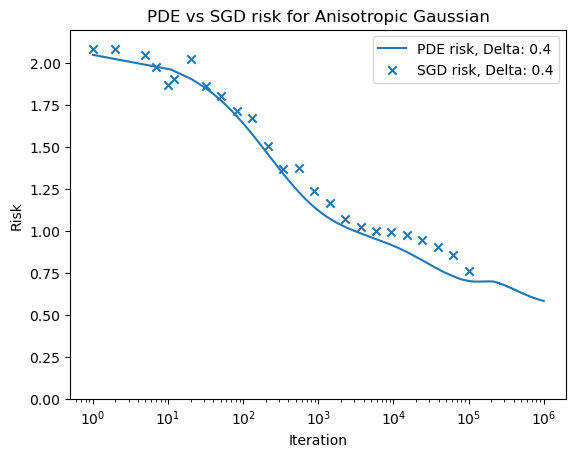

In [125]:
plt.plot(iters, pde_loss(iters),  label = 'PDE risk, Delta: 0.4')
plt.scatter(np.array(indices), risk_SGD, marker = 'x', label = 'SGD risk, Delta: 0.4')
plt.xscale('log')
plt.xlabel('Iteration')
plt.ylabel('Risk')
plt.legend()
plt.title('PDE vs SGD risk for Anisotropic Gaussian')
plt.ylim([0,2.2])

Text(0.5, 1.0, 'PDE vs SGD Mean value of a for Anisotropic Gaussian')

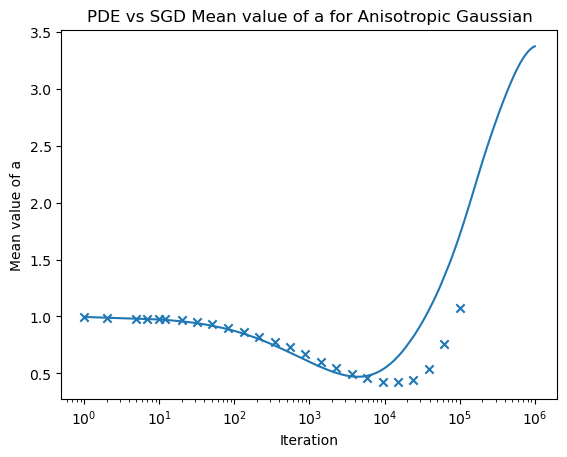

In [126]:
plt.plot(iters, avg_a_pde(iters), label = 'PDE mean value of a, Delta: 0.2')
plt.scatter(np.array(indices), a_SGD, marker = 'x', label = 'SGD mean value of b, Delta: 0.2')
plt.xscale('log')
plt.xlabel('Iteration')
plt.ylabel('Mean value of a')
plt.title('PDE vs SGD Mean value of a for Anisotropic Gaussian')

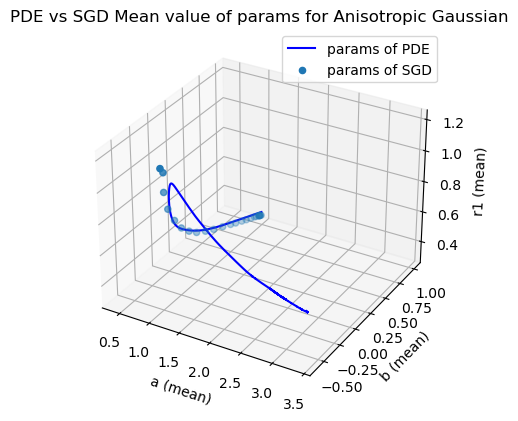

In [127]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(avg_a_pde(iters), avg_b_pde(iters), avg_r1_pde(iters), 'blue', label = 'params of PDE')
ax.scatter(a_SGD, b_SGD, r1_SGD, 'blue', label = 'params of SGD')
ax.set_title('3D Line plot')
ax.set_xlabel('a (mean)')
ax.set_ylabel('b (mean)')
ax.set_zlabel('r1 (mean)')
plt.title('PDE vs SGD Mean value of params for Anisotropic Gaussian')
plt.legend()
plt.show()

Text(0.5, 1.0, 'PDE vs SGD Mean value of r1 for Anisotropic Gaussian')

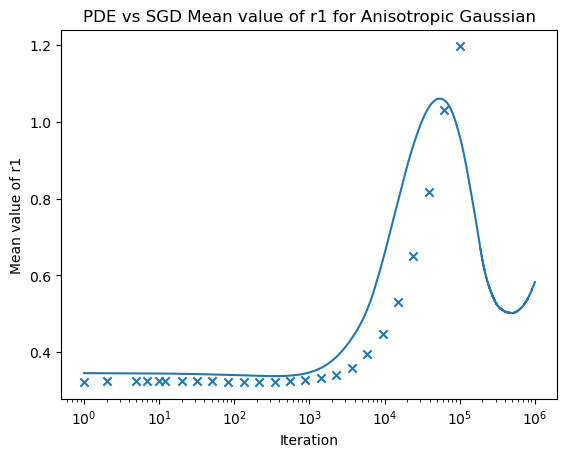

In [128]:
plt.plot(iters, avg_r1_pde(iters), label = 'PDE mean value of r1, Delta: 0.4')
plt.scatter(np.array(indices), r1_SGD, marker = 'x', label = 'SGD mean value of r1, Delta: 0.4')
plt.xscale('log')
plt.xlabel('Iteration')
plt.ylabel('Mean value of r1')
plt.title('PDE vs SGD Mean value of r1 for Anisotropic Gaussian')

# General Observations

- The losses and parameter values observed during the SGD run matches relatively closely the respective values obtained by the distributional dynamics as expected, bearing in mind that the dimensionality of the problem was reduced by a factor of ten to speed up computations
- Here Nesterov accelerated SGD performs the best, outperforming plain SGD, and while in the beginning, the MF-HomSGLD matches the performance of plain SGD, it seems to get stuck for larger iterations.